In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

h = h[-1]
beta = beta[-1]

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-8],]

In [9]:
cm_target

['case15cm_blade1.csv']

In [10]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    #x = np.hstack((t, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [11]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [12]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [13]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [14]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [15]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [16]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [17]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [18]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (5000, 2)
Dimension - heights of Gurney flaps:  (5000, 1)
Dimension - inclination(beta):  (5000, 1)
Dimension - x:  (5000, 1)
Dimension - y:  (5000, 1)


In [19]:
x[:,0] -= 10
x[:,0] /= 5

In [20]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [21]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [22]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [23]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
model_directory = "D:\\TrainedModels\\20221229\\WithoutParameters"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [26]:
ckpt_name = model_directory + "20221229unsteadyPrediction_MLP_WithoutParameters_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [27]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [28]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 2s - loss: 0.2102 - rmse: 0.4584
Epoch 1: val_loss improved from inf to 0.19501, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 1s 134ms/step - loss: 0.2089 - rmse: 0.4569 - val_loss: 0.1950 - val_rmse: 0.4415 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1978 - rmse: 0.4446
Epoch 2: val_loss improved from 0.19501 to 0.18029, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.1953 - rmse: 0.4418 - val_loss: 0.1803 - val_rmse: 0.4245 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1746 - rmse: 0.4177
Epoch 3: val_loss improved from 0.18029 to

3/3 [==============================] - 0s 47ms/step - loss: 0.0778 - rmse: 0.2787 - val_loss: 0.0763 - val_rmse: 0.2760 - lr: 1.0000e-04
Epoch 21/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0765 - rmse: 0.2763
Epoch 21: val_loss improved from 0.07627 to 0.07508, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0753 - rmse: 0.2743 - val_loss: 0.0751 - val_rmse: 0.2738 - lr: 1.0000e-04
Epoch 22/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0789 - rmse: 0.2807
Epoch 22: val_loss improved from 0.07508 to 0.07385, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0751 - rmse: 0.2739 - val_loss: 0.0738 - val_rmse: 0.2716 - lr: 

3/3 [==============================] - 0s 47ms/step - loss: 0.0668 - rmse: 0.2583 - val_loss: 0.0614 - val_rmse: 0.2477 - lr: 1.0000e-04
Epoch 40/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0637 - rmse: 0.2521
Epoch 40: val_loss improved from 0.06145 to 0.06126, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0623 - rmse: 0.2494 - val_loss: 0.0613 - val_rmse: 0.2473 - lr: 1.0000e-04
Epoch 41/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0623 - rmse: 0.2493
Epoch 41: val_loss improved from 0.06126 to 0.06123, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0640 - rmse: 0.2528 - val_loss: 0.0612 - val_rmse: 0.2472 - lr: 

1/3 [=========>....................] - ETA: 0s - loss: 0.0683 - rmse: 0.2611
Epoch 62: val_loss improved from 0.06082 to 0.06080, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0657 - rmse: 0.2561 - val_loss: 0.0608 - val_rmse: 0.2464 - lr: 1.0000e-04
Epoch 63/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0613 - rmse: 0.2474
Epoch 63: val_loss improved from 0.06080 to 0.06077, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0602 - rmse: 0.2452 - val_loss: 0.0608 - val_rmse: 0.2463 - lr: 1.0000e-04
Epoch 64/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0643 - rmse: 0.2533
Epoch 64: val_loss improved from 0.06077 to 0.060

1/3 [=========>....................] - ETA: 0s - loss: 0.0636 - rmse: 0.2520
Epoch 84: val_loss improved from 0.06040 to 0.06036, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 60ms/step - loss: 0.0633 - rmse: 0.2514 - val_loss: 0.0604 - val_rmse: 0.2455 - lr: 1.0000e-04
Epoch 85/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0638 - rmse: 0.2523
Epoch 85: val_loss improved from 0.06036 to 0.06035, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 64ms/step - loss: 0.0642 - rmse: 0.2532 - val_loss: 0.0604 - val_rmse: 0.2455 - lr: 1.0000e-04
Epoch 86/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0581 - rmse: 0.2408
Epoch 86: val_loss did not improve from 0.06035
3

Epoch 107/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0618 - rmse: 0.2484
Epoch 107: val_loss improved from 0.05967 to 0.05957, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0610 - rmse: 0.2469 - val_loss: 0.0596 - val_rmse: 0.2439 - lr: 1.0000e-04
Epoch 108/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0595 - rmse: 0.2437
Epoch 108: val_loss improved from 0.05957 to 0.05952, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 72ms/step - loss: 0.0629 - rmse: 0.2506 - val_loss: 0.0595 - val_rmse: 0.2438 - lr: 1.0000e-04
Epoch 109/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0579 - rmse: 0.2404
Epoch 109: val_loss improved 

3/3 [==============================] - 0s 52ms/step - loss: 0.0603 - rmse: 0.2453 - val_loss: 0.0584 - val_rmse: 0.2414 - lr: 1.0000e-04
Epoch 127/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0629 - rmse: 0.2505
Epoch 127: val_loss improved from 0.05838 to 0.05826, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0634 - rmse: 0.2516 - val_loss: 0.0583 - val_rmse: 0.2412 - lr: 1.0000e-04
Epoch 128/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0612 - rmse: 0.2473
Epoch 128: val_loss improved from 0.05826 to 0.05824, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 58ms/step - loss: 0.0590 - rmse: 0.2427 - val_loss: 0.0582 - val_rmse: 0.2411 - 

3/3 [==============================] - 0s 65ms/step - loss: 0.0583 - rmse: 0.2412 - val_loss: 0.0568 - val_rmse: 0.2381 - lr: 1.0000e-04
Epoch 147/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0599 - rmse: 0.2446
Epoch 147: val_loss did not improve from 0.05681
3/3 [==============================] - 0s 30ms/step - loss: 0.0619 - rmse: 0.2486 - val_loss: 0.0570 - val_rmse: 0.2385 - lr: 1.0000e-04
Epoch 148/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0586 - rmse: 0.2419
Epoch 148: val_loss improved from 0.05681 to 0.05673, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 63ms/step - loss: 0.0595 - rmse: 0.2437 - val_loss: 0.0567 - val_rmse: 0.2380 - lr: 1.0000e-04
Epoch 149/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0601 - rmse: 0.2450
Epoch 149: val_loss improved from 0.05673 to 0.05669

Epoch 169/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0562 - rmse: 0.2368
Epoch 169: val_loss improved from 0.05511 to 0.05495, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0581 - rmse: 0.2409 - val_loss: 0.0550 - val_rmse: 0.2342 - lr: 1.0000e-04
Epoch 170/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0588 - rmse: 0.2424
Epoch 170: val_loss improved from 0.05495 to 0.05492, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 67ms/step - loss: 0.0591 - rmse: 0.2429 - val_loss: 0.0549 - val_rmse: 0.2341 - lr: 1.0000e-04
Epoch 171/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0570 - rmse: 0.2385
Epoch 171: val_loss improved 

Epoch 189/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0610 - rmse: 0.2467
Epoch 189: val_loss improved from 0.05346 to 0.05344, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 63ms/step - loss: 0.0567 - rmse: 0.2380 - val_loss: 0.0534 - val_rmse: 0.2309 - lr: 1.0000e-04
Epoch 190/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0583 - rmse: 0.2412
Epoch 190: val_loss improved from 0.05344 to 0.05329, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 73ms/step - loss: 0.0579 - rmse: 0.2405 - val_loss: 0.0533 - val_rmse: 0.2306 - lr: 1.0000e-04
Epoch 191/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0541 - rmse: 0.2324
Epoch 191: val_loss improved 

1/3 [=========>....................] - ETA: 0s - loss: 0.0552 - rmse: 0.2347
Epoch 209: val_loss improved from 0.05167 to 0.05164, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 65ms/step - loss: 0.0563 - rmse: 0.2371 - val_loss: 0.0516 - val_rmse: 0.2270 - lr: 1.0000e-04
Epoch 210/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0499 - rmse: 0.2232
Epoch 210: val_loss did not improve from 0.05164
3/3 [==============================] - 0s 26ms/step - loss: 0.0544 - rmse: 0.2331 - val_loss: 0.0517 - val_rmse: 0.2271 - lr: 1.0000e-04
Epoch 211/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0556 - rmse: 0.2356
Epoch 211: val_loss improved from 0.05164 to 0.05151, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint

3/3 [==============================] - 0s 20ms/step - loss: 0.0547 - rmse: 0.2337 - val_loss: 0.0503 - val_rmse: 0.2240 - lr: 1.0000e-04
Epoch 231/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0537 - rmse: 0.2316
Epoch 231: val_loss improved from 0.05000 to 0.04995, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 63ms/step - loss: 0.0527 - rmse: 0.2293 - val_loss: 0.0500 - val_rmse: 0.2233 - lr: 1.0000e-04
Epoch 232/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0559 - rmse: 0.2363
Epoch 232: val_loss improved from 0.04995 to 0.04980, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 61ms/step - loss: 0.0540 - rmse: 0.2322 - val_loss: 0.0498 - val_rmse: 0.2229 - 

3/3 [==============================] - 0s 51ms/step - loss: 0.0513 - rmse: 0.2262 - val_loss: 0.0486 - val_rmse: 0.2202 - lr: 1.0000e-04
Epoch 251/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0514 - rmse: 0.2265
Epoch 251: val_loss improved from 0.04859 to 0.04855, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0526 - rmse: 0.2291 - val_loss: 0.0485 - val_rmse: 0.2201 - lr: 1.0000e-04
Epoch 252/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0540 - rmse: 0.2321
Epoch 252: val_loss improved from 0.04855 to 0.04845, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0538 - rmse: 0.2318 - val_loss: 0.0485 - val_rmse: 0.2199 - 

Epoch 274/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0485 - rmse: 0.2200
Epoch 274: val_loss did not improve from 0.04772
3/3 [==============================] - 0s 21ms/step - loss: 0.0508 - rmse: 0.2251 - val_loss: 0.0478 - val_rmse: 0.2183 - lr: 1.0000e-04
Epoch 275/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0534 - rmse: 0.2310
Epoch 275: val_loss did not improve from 0.04772
3/3 [==============================] - 0s 22ms/step - loss: 0.0540 - rmse: 0.2322 - val_loss: 0.0492 - val_rmse: 0.2215 - lr: 1.0000e-04
Epoch 276/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0502 - rmse: 0.2237
Epoch 276: val_loss improved from 0.04772 to 0.04771, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0521 - rmse: 0.2280 - val_loss: 0.0477 - val_rmse: 0.2182 - lr: 1.0000e-04
Epo

Epoch 299/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0485 - rmse: 0.2201
Epoch 299: val_loss did not improve from 0.04716
3/3 [==============================] - 0s 25ms/step - loss: 0.0517 - rmse: 0.2271 - val_loss: 0.0474 - val_rmse: 0.2174 - lr: 1.0000e-04
Epoch 300/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0501 - rmse: 0.2237
Epoch 300: val_loss improved from 0.04716 to 0.04713, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 60ms/step - loss: 0.0510 - rmse: 0.2257 - val_loss: 0.0471 - val_rmse: 0.2169 - lr: 1.0000e-04
Epoch 301/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2344
Epoch 301: val_loss improved from 0.04713 to 0.04707, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256

3/3 [==============================] - 0s 50ms/step - loss: 0.0516 - rmse: 0.2269 - val_loss: 0.0468 - val_rmse: 0.2162 - lr: 1.0000e-04
Epoch 323/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0515 - rmse: 0.2267
Epoch 323: val_loss did not improve from 0.04682
3/3 [==============================] - 0s 21ms/step - loss: 0.0522 - rmse: 0.2283 - val_loss: 0.0474 - val_rmse: 0.2176 - lr: 1.0000e-04
Epoch 324/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0536 - rmse: 0.2312
Epoch 324: val_loss did not improve from 0.04682
3/3 [==============================] - 0s 21ms/step - loss: 0.0512 - rmse: 0.2260 - val_loss: 0.0469 - val_rmse: 0.2164 - lr: 1.0000e-04
Epoch 325/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0505 - rmse: 0.2245
Epoch 325: val_loss did not improve from 0.04682
3/3 [==============================] - 0s 22ms/step - loss: 0.0517 - rmse: 0.2272 - val_loss: 0.0469 - val_rmse: 0.2164 - lr: 1.0000e-04
Epoch 326/10000
1/3 [=====

Epoch 348/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0514 - rmse: 0.2264
Epoch 348: val_loss did not improve from 0.04668
3/3 [==============================] - 0s 20ms/step - loss: 0.0516 - rmse: 0.2270 - val_loss: 0.0470 - val_rmse: 0.2165 - lr: 1.0000e-04
Epoch 349/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0510 - rmse: 0.2255
Epoch 349: val_loss improved from 0.04668 to 0.04663, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 68ms/step - loss: 0.0514 - rmse: 0.2265 - val_loss: 0.0466 - val_rmse: 0.2157 - lr: 1.0000e-04
Epoch 350/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0507 - rmse: 0.2250
Epoch 350: val_loss did not improve from 0.04663
3/3 [==============================] - 0s 21ms/step - loss: 0.0519 - rmse: 0.2275 - val_loss: 0.0471 - val_rmse: 0.2168 - lr: 1.0000e-04
Epo

3/3 [==============================] - 0s 53ms/step - loss: 0.0516 - rmse: 0.2269 - val_loss: 0.0465 - val_rmse: 0.2153 - lr: 1.0000e-04
Epoch 374/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0481 - rmse: 0.2192
Epoch 374: val_loss did not improve from 0.04647
3/3 [==============================] - 0s 20ms/step - loss: 0.0521 - rmse: 0.2280 - val_loss: 0.0474 - val_rmse: 0.2176 - lr: 1.0000e-04
Epoch 375/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0507 - rmse: 0.2250
Epoch 375: val_loss did not improve from 0.04647
3/3 [==============================] - 0s 21ms/step - loss: 0.0496 - rmse: 0.2225 - val_loss: 0.0466 - val_rmse: 0.2158 - lr: 1.0000e-04
Epoch 376/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0506 - rmse: 0.2247
Epoch 376: val_loss did not improve from 0.04647
3/3 [==============================] - 0s 21ms/step - loss: 0.0515 - rmse: 0.2266 - val_loss: 0.0467 - val_rmse: 0.2158 - lr: 1.0000e-04
Epoch 377/10000
1/3 [=====

3/3 [==============================] - 0s 22ms/step - loss: 0.0513 - rmse: 0.2263 - val_loss: 0.0467 - val_rmse: 0.2159 - lr: 1.0000e-04
Epoch 400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0508 - rmse: 0.2252
Epoch 400: val_loss did not improve from 0.04628
3/3 [==============================] - 0s 21ms/step - loss: 0.0512 - rmse: 0.2261 - val_loss: 0.0463 - val_rmse: 0.2150 - lr: 1.0000e-04
Epoch 401/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0540 - rmse: 0.2322
Epoch 401: val_loss improved from 0.04628 to 0.04625, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0508 - rmse: 0.2251 - val_loss: 0.0462 - val_rmse: 0.2148 - lr: 1.0000e-04
Epoch 402/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0502 - rmse: 0.2238
Epoch 402: val_loss did not improve from 0.04625
3/3

Epoch 427/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0499 - rmse: 0.2231
Epoch 427: val_loss did not improve from 0.04622
3/3 [==============================] - 0s 20ms/step - loss: 0.0533 - rmse: 0.2306 - val_loss: 0.0463 - val_rmse: 0.2149 - lr: 1.0000e-04
Epoch 428/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0500 - rmse: 0.2233
Epoch 428: val_loss improved from 0.04622 to 0.04621, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0487 - rmse: 0.2204 - val_loss: 0.0462 - val_rmse: 0.2147 - lr: 1.0000e-04
Epoch 429/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0452 - rmse: 0.2124
Epoch 429: val_loss improved from 0.04621 to 0.04610, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256

3/3 [==============================] - 0s 50ms/step - loss: 0.0513 - rmse: 0.2262 - val_loss: 0.0460 - val_rmse: 0.2143 - lr: 1.0000e-04
Epoch 454/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0463 - rmse: 0.2150
Epoch 454: val_loss did not improve from 0.04601
3/3 [==============================] - 0s 21ms/step - loss: 0.0502 - rmse: 0.2239 - val_loss: 0.0461 - val_rmse: 0.2144 - lr: 1.0000e-04
Epoch 455/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0500 - rmse: 0.2234
Epoch 455: val_loss did not improve from 0.04601
3/3 [==============================] - 0s 21ms/step - loss: 0.0506 - rmse: 0.2248 - val_loss: 0.0461 - val_rmse: 0.2145 - lr: 1.0000e-04
Epoch 456/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0479 - rmse: 0.2187
Epoch 456: val_loss improved from 0.04601 to 0.04598, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3

3/3 [==============================] - 0s 44ms/step - loss: 0.0490 - rmse: 0.2213 - val_loss: 0.0458 - val_rmse: 0.2139 - lr: 1.0000e-04
Epoch 479/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0505 - rmse: 0.2246
Epoch 479: val_loss did not improve from 0.04584
3/3 [==============================] - 0s 21ms/step - loss: 0.0502 - rmse: 0.2239 - val_loss: 0.0458 - val_rmse: 0.2139 - lr: 1.0000e-04
Epoch 480/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0509 - rmse: 0.2254
Epoch 480: val_loss did not improve from 0.04584
3/3 [==============================] - 0s 21ms/step - loss: 0.0507 - rmse: 0.2249 - val_loss: 0.0459 - val_rmse: 0.2140 - lr: 1.0000e-04
Epoch 481/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0503 - rmse: 0.2241
Epoch 481: val_loss did not improve from 0.04584
3/3 [==============================] - 0s 21ms/step - loss: 0.0509 - rmse: 0.2253 - val_loss: 0.0459 - val_rmse: 0.2139 - lr: 1.0000e-04
Epoch 482/10000
1/3 [=====

3/3 [==============================] - 0s 24ms/step - loss: 0.0519 - rmse: 0.2276 - val_loss: 0.0465 - val_rmse: 0.2154 - lr: 1.0000e-04
Epoch 505/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0501 - rmse: 0.2235
Epoch 505: val_loss did not improve from 0.04568
3/3 [==============================] - 0s 24ms/step - loss: 0.0500 - rmse: 0.2233 - val_loss: 0.0459 - val_rmse: 0.2140 - lr: 1.0000e-04
Epoch 506/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0515 - rmse: 0.2268
Epoch 506: val_loss did not improve from 0.04568
3/3 [==============================] - 0s 24ms/step - loss: 0.0509 - rmse: 0.2254 - val_loss: 0.0460 - val_rmse: 0.2143 - lr: 1.0000e-04
Epoch 507/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0481 - rmse: 0.2191
Epoch 507: val_loss improved from 0.04568 to 0.04567, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0462 - rmse: 0.2147
Epoch 529: val_loss did not improve from 0.04543
3/3 [==============================] - 0s 21ms/step - loss: 0.0493 - rmse: 0.2218 - val_loss: 0.0456 - val_rmse: 0.2134 - lr: 1.0000e-04
Epoch 530/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0525 - rmse: 0.2289
Epoch 530: val_loss did not improve from 0.04543
3/3 [==============================] - 0s 21ms/step - loss: 0.0489 - rmse: 0.2209 - val_loss: 0.0456 - val_rmse: 0.2133 - lr: 1.0000e-04
Epoch 531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0545 - rmse: 0.2332
Epoch 531: val_loss did not improve from 0.04543
3/3 [==============================] - 0s 22ms/step - loss: 0.0523 - rmse: 0.2285 - val_loss: 0.0456 - val_rmse: 0.2132 - lr: 1.0000e-04
Epoch 532/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0472 - rmse: 0.2170
Epoch 532: val_loss did not improve from 0.04543
3/3 [==============================] 

Epoch 558/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0470 - rmse: 0.2166
Epoch 558: val_loss did not improve from 0.04540
3/3 [==============================] - 0s 23ms/step - loss: 0.0477 - rmse: 0.2182 - val_loss: 0.0457 - val_rmse: 0.2136 - lr: 1.0000e-04
Epoch 559/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0533 - rmse: 0.2307
Epoch 559: val_loss did not improve from 0.04540
3/3 [==============================] - 0s 21ms/step - loss: 0.0507 - rmse: 0.2249 - val_loss: 0.0454 - val_rmse: 0.2129 - lr: 1.0000e-04
Epoch 560/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0513 - rmse: 0.2264
Epoch 560: val_loss improved from 0.04540 to 0.04529, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0498 - rmse: 0.2229 - val_loss: 0.0453 - val_rmse: 0.2126 - lr: 1.0000e-04
Epo

Epoch 584/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0505 - rmse: 0.2244
Epoch 584: val_loss did not improve from 0.04512
3/3 [==============================] - 0s 22ms/step - loss: 0.0489 - rmse: 0.2210 - val_loss: 0.0454 - val_rmse: 0.2128 - lr: 1.0000e-04
Epoch 585/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0521 - rmse: 0.2280
Epoch 585: val_loss did not improve from 0.04512
3/3 [==============================] - 0s 22ms/step - loss: 0.0499 - rmse: 0.2233 - val_loss: 0.0452 - val_rmse: 0.2123 - lr: 1.0000e-04
Epoch 586/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0452 - rmse: 0.2125
Epoch 586: val_loss did not improve from 0.04512
3/3 [==============================] - 0s 22ms/step - loss: 0.0465 - rmse: 0.2154 - val_loss: 0.0452 - val_rmse: 0.2123 - lr: 1.0000e-04
Epoch 587/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0514 - rmse: 0.2266
Epoch 587: val_loss did not improve from 0.04512
3/3 [================

Epoch 610/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0481 - rmse: 0.2192
Epoch 610: val_loss did not improve from 0.04483
3/3 [==============================] - 0s 22ms/step - loss: 0.0509 - rmse: 0.2254 - val_loss: 0.0449 - val_rmse: 0.2117 - lr: 1.0000e-04
Epoch 611/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0430 - rmse: 0.2072
Epoch 611: val_loss improved from 0.04483 to 0.04478, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0467 - rmse: 0.2160 - val_loss: 0.0448 - val_rmse: 0.2114 - lr: 1.0000e-04
Epoch 612/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0492 - rmse: 0.2215
Epoch 612: val_loss did not improve from 0.04478
3/3 [==============================] - 0s 21ms/step - loss: 0.0493 - rmse: 0.2217 - val_loss: 0.0452 - val_rmse: 0.2123 - lr: 1.0000e-04
Epo

1/3 [=========>....................] - ETA: 0s - loss: 0.0497 - rmse: 0.2227
Epoch 637: val_loss did not improve from 0.04468
3/3 [==============================] - 0s 22ms/step - loss: 0.0482 - rmse: 0.2194 - val_loss: 0.0448 - val_rmse: 0.2114 - lr: 1.0000e-04
Epoch 638/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0519 - rmse: 0.2276
Epoch 638: val_loss did not improve from 0.04468
3/3 [==============================] - 0s 22ms/step - loss: 0.0492 - rmse: 0.2217 - val_loss: 0.0447 - val_rmse: 0.2112 - lr: 1.0000e-04
Epoch 639/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0488 - rmse: 0.2206
Epoch 639: val_loss did not improve from 0.04468
3/3 [==============================] - 0s 22ms/step - loss: 0.0481 - rmse: 0.2192 - val_loss: 0.0452 - val_rmse: 0.2125 - lr: 1.0000e-04
Epoch 640/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0508 - rmse: 0.2252
Epoch 640: val_loss improved from 0.04468 to 0.04461, saving model to D:\TrainedModels

3/3 [==============================] - 0s 22ms/step - loss: 0.0482 - rmse: 0.2193 - val_loss: 0.0443 - val_rmse: 0.2104 - lr: 1.0000e-04
Epoch 663/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0500 - rmse: 0.2234
Epoch 663: val_loss improved from 0.04432 to 0.04430, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0478 - rmse: 0.2183 - val_loss: 0.0443 - val_rmse: 0.2103 - lr: 1.0000e-04
Epoch 664/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0470 - rmse: 0.2166
Epoch 664: val_loss did not improve from 0.04430
3/3 [==============================] - 0s 21ms/step - loss: 0.0491 - rmse: 0.2213 - val_loss: 0.0443 - val_rmse: 0.2104 - lr: 1.0000e-04
Epoch 665/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0480 - rmse: 0.2188
Epoch 665: val_loss improved from 0.04430 to 0.04420

3/3 [==============================] - 0s 21ms/step - loss: 0.0489 - rmse: 0.2210 - val_loss: 0.0440 - val_rmse: 0.2096 - lr: 1.0000e-04
Epoch 689/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0426 - rmse: 0.2062
Epoch 689: val_loss did not improve from 0.04394
3/3 [==============================] - 0s 21ms/step - loss: 0.0474 - rmse: 0.2175 - val_loss: 0.0440 - val_rmse: 0.2095 - lr: 1.0000e-04
Epoch 690/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0504 - rmse: 0.2243
Epoch 690: val_loss improved from 0.04394 to 0.04385, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0483 - rmse: 0.2196 - val_loss: 0.0438 - val_rmse: 0.2092 - lr: 1.0000e-04
Epoch 691/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0491 - rmse: 0.2215
Epoch 691: val_loss did not improve from 0.04385
3/3

3/3 [==============================] - 0s 56ms/step - loss: 0.0483 - rmse: 0.2196 - val_loss: 0.0435 - val_rmse: 0.2083 - lr: 1.0000e-04
Epoch 715/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0431 - rmse: 0.2075
Epoch 715: val_loss did not improve from 0.04346
3/3 [==============================] - 0s 21ms/step - loss: 0.0465 - rmse: 0.2155 - val_loss: 0.0437 - val_rmse: 0.2090 - lr: 1.0000e-04
Epoch 716/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0489 - rmse: 0.2210
Epoch 716: val_loss did not improve from 0.04346
3/3 [==============================] - 0s 21ms/step - loss: 0.0473 - rmse: 0.2174 - val_loss: 0.0435 - val_rmse: 0.2083 - lr: 1.0000e-04
Epoch 717/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0468 - rmse: 0.2161
Epoch 717: val_loss did not improve from 0.04346
3/3 [==============================] - 0s 22ms/step - loss: 0.0478 - rmse: 0.2185 - val_loss: 0.0439 - val_rmse: 0.2094 - lr: 1.0000e-04
Epoch 718/10000
1/3 [=====

Epoch 740/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0487 - rmse: 0.2205
Epoch 740: val_loss did not improve from 0.04293
3/3 [==============================] - 0s 21ms/step - loss: 0.0471 - rmse: 0.2169 - val_loss: 0.0435 - val_rmse: 0.2083 - lr: 1.0000e-04
Epoch 741/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0495 - rmse: 0.2222
Epoch 741: val_loss did not improve from 0.04293
3/3 [==============================] - 0s 21ms/step - loss: 0.0467 - rmse: 0.2159 - val_loss: 0.0431 - val_rmse: 0.2073 - lr: 1.0000e-04
Epoch 742/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0475 - rmse: 0.2178
Epoch 742: val_loss did not improve from 0.04293
3/3 [==============================] - 0s 22ms/step - loss: 0.0471 - rmse: 0.2167 - val_loss: 0.0431 - val_rmse: 0.2075 - lr: 1.0000e-04
Epoch 743/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0500 - rmse: 0.2234
Epoch 743: val_loss did not improve from 0.04293
3/3 [================

3/3 [==============================] - 0s 48ms/step - loss: 0.0467 - rmse: 0.2159 - val_loss: 0.0422 - val_rmse: 0.2053 - lr: 1.0000e-04
Epoch 766/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0430 - rmse: 0.2071
Epoch 766: val_loss did not improve from 0.04223
3/3 [==============================] - 0s 21ms/step - loss: 0.0452 - rmse: 0.2124 - val_loss: 0.0425 - val_rmse: 0.2059 - lr: 1.0000e-04
Epoch 767/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0461 - rmse: 0.2144
Epoch 767: val_loss did not improve from 0.04223
3/3 [==============================] - 0s 21ms/step - loss: 0.0453 - rmse: 0.2127 - val_loss: 0.0424 - val_rmse: 0.2056 - lr: 1.0000e-04
Epoch 768/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0507 - rmse: 0.2251
Epoch 768: val_loss did not improve from 0.04223
3/3 [==============================] - 0s 21ms/step - loss: 0.0470 - rmse: 0.2167 - val_loss: 0.0426 - val_rmse: 0.2062 - lr: 1.0000e-04
Epoch 769/10000
1/3 [=====

Epoch 791/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0454 - rmse: 0.2128
Epoch 791: val_loss did not improve from 0.04181
3/3 [==============================] - 0s 21ms/step - loss: 0.0454 - rmse: 0.2128 - val_loss: 0.0418 - val_rmse: 0.2043 - lr: 1.0000e-04
Epoch 792/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0478 - rmse: 0.2185
Epoch 792: val_loss did not improve from 0.04181
3/3 [==============================] - 0s 21ms/step - loss: 0.0465 - rmse: 0.2154 - val_loss: 0.0421 - val_rmse: 0.2049 - lr: 1.0000e-04
Epoch 793/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0508 - rmse: 0.2252
Epoch 793: val_loss improved from 0.04181 to 0.04156, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0466 - rmse: 0.2158 - val_loss: 0.0416 - val_rmse: 0.2037 - lr: 1.0000e-04
Epo

1/3 [=========>....................] - ETA: 0s - loss: 0.0450 - rmse: 0.2120
Epoch 815: val_loss did not improve from 0.04075
3/3 [==============================] - 0s 21ms/step - loss: 0.0429 - rmse: 0.2070 - val_loss: 0.0408 - val_rmse: 0.2018 - lr: 1.0000e-04
Epoch 816/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0442 - rmse: 0.2100
Epoch 816: val_loss did not improve from 0.04075
3/3 [==============================] - 0s 21ms/step - loss: 0.0463 - rmse: 0.2149 - val_loss: 0.0425 - val_rmse: 0.2059 - lr: 1.0000e-04
Epoch 817/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0460 - rmse: 0.2143
Epoch 817: val_loss did not improve from 0.04075
3/3 [==============================] - 0s 20ms/step - loss: 0.0454 - rmse: 0.2129 - val_loss: 0.0412 - val_rmse: 0.2028 - lr: 1.0000e-04
Epoch 818/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0437 - rmse: 0.2088
Epoch 818: val_loss did not improve from 0.04075
3/3 [==============================] 

3/3 [==============================] - 0s 46ms/step - loss: 0.0435 - rmse: 0.2084 - val_loss: 0.0398 - val_rmse: 0.1994 - lr: 1.0000e-04
Epoch 842/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0437 - rmse: 0.2087
Epoch 842: val_loss did not improve from 0.03984
3/3 [==============================] - 0s 20ms/step - loss: 0.0444 - rmse: 0.2105 - val_loss: 0.0404 - val_rmse: 0.2007 - lr: 1.0000e-04
Epoch 843/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0402 - rmse: 0.2002
Epoch 843: val_loss improved from 0.03984 to 0.03970, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0438 - rmse: 0.2091 - val_loss: 0.0397 - val_rmse: 0.1990 - lr: 1.0000e-04
Epoch 844/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0437 - rmse: 0.2088
Epoch 844: val_loss did not improve from 0.03970
3/3

3/3 [==============================] - 0s 52ms/step - loss: 0.0424 - rmse: 0.2057 - val_loss: 0.0388 - val_rmse: 0.1967 - lr: 1.0000e-04
Epoch 866/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0431 - rmse: 0.2074
Epoch 866: val_loss did not improve from 0.03879
3/3 [==============================] - 0s 21ms/step - loss: 0.0438 - rmse: 0.2091 - val_loss: 0.0392 - val_rmse: 0.1979 - lr: 1.0000e-04
Epoch 867/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0421 - rmse: 0.2050
Epoch 867: val_loss improved from 0.03879 to 0.03876, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0429 - rmse: 0.2070 - val_loss: 0.0388 - val_rmse: 0.1966 - lr: 1.0000e-04
Epoch 868/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0373 - rmse: 0.1929
Epoch 868: val_loss did not improve from 0.03876
3/3

Epoch 891/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0420 - rmse: 0.2046
Epoch 891: val_loss improved from 0.03779 to 0.03774, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 64ms/step - loss: 0.0414 - rmse: 0.2033 - val_loss: 0.0377 - val_rmse: 0.1940 - lr: 1.0000e-04
Epoch 892/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0374 - rmse: 0.1931
Epoch 892: val_loss did not improve from 0.03774
3/3 [==============================] - 0s 20ms/step - loss: 0.0401 - rmse: 0.2000 - val_loss: 0.0383 - val_rmse: 0.1954 - lr: 1.0000e-04
Epoch 893/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0419 - rmse: 0.2044
Epoch 893: val_loss did not improve from 0.03774
3/3 [==============================] - 0s 21ms/step - loss: 0.0415 - rmse: 0.2035 - val_loss: 0.0381 - val_rmse: 0.1949 - lr: 1.0000e-04
Epo

1/3 [=========>....................] - ETA: 0s - loss: 0.0402 - rmse: 0.2003
Epoch 915: val_loss did not improve from 0.03645
3/3 [==============================] - 0s 20ms/step - loss: 0.0390 - rmse: 0.1972 - val_loss: 0.0366 - val_rmse: 0.1910 - lr: 1.0000e-04
Epoch 916/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0406 - rmse: 0.2014
Epoch 916: val_loss did not improve from 0.03645
3/3 [==============================] - 0s 21ms/step - loss: 0.0398 - rmse: 0.1993 - val_loss: 0.0371 - val_rmse: 0.1924 - lr: 1.0000e-04
Epoch 917/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0414 - rmse: 0.2034
Epoch 917: val_loss did not improve from 0.03645
3/3 [==============================] - 0s 20ms/step - loss: 0.0405 - rmse: 0.2010 - val_loss: 0.0372 - val_rmse: 0.1926 - lr: 1.0000e-04
Epoch 918/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0364 - rmse: 0.1907
Epoch 918: val_loss did not improve from 0.03645
3/3 [==============================] 

Epoch 941/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0378 - rmse: 0.1942
Epoch 941: val_loss did not improve from 0.03547
3/3 [==============================] - 0s 21ms/step - loss: 0.0381 - rmse: 0.1949 - val_loss: 0.0363 - val_rmse: 0.1904 - lr: 1.0000e-04
Epoch 942/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0420 - rmse: 0.2047
Epoch 942: val_loss did not improve from 0.03547
3/3 [==============================] - 0s 20ms/step - loss: 0.0393 - rmse: 0.1980 - val_loss: 0.0356 - val_rmse: 0.1884 - lr: 1.0000e-04
Epoch 943/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0389 - rmse: 0.1970
Epoch 943: val_loss did not improve from 0.03547
3/3 [==============================] - 0s 21ms/step - loss: 0.0387 - rmse: 0.1966 - val_loss: 0.0355 - val_rmse: 0.1883 - lr: 1.0000e-04
Epoch 944/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0420 - rmse: 0.2047
Epoch 944: val_loss improved from 0.03547 to 0.03523, saving model to 

Epoch 966/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0304 - rmse: 0.1742
Epoch 966: val_loss did not improve from 0.03413
3/3 [==============================] - 0s 22ms/step - loss: 0.0356 - rmse: 0.1884 - val_loss: 0.0350 - val_rmse: 0.1868 - lr: 1.0000e-04
Epoch 967/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0384 - rmse: 0.1957
Epoch 967: val_loss improved from 0.03413 to 0.03373, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0381 - rmse: 0.1950 - val_loss: 0.0337 - val_rmse: 0.1834 - lr: 1.0000e-04
Epoch 968/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1895
Epoch 968: val_loss improved from 0.03373 to 0.03368, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256

1/3 [=========>....................] - ETA: 0s - loss: 0.0369 - rmse: 0.1920
Epoch 990: val_loss did not improve from 0.03290
3/3 [==============================] - 0s 20ms/step - loss: 0.0365 - rmse: 0.1909 - val_loss: 0.0332 - val_rmse: 0.1820 - lr: 1.0000e-04
Epoch 991/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0367 - rmse: 0.1913
Epoch 991: val_loss did not improve from 0.03290
3/3 [==============================] - 0s 20ms/step - loss: 0.0364 - rmse: 0.1905 - val_loss: 0.0339 - val_rmse: 0.1838 - lr: 1.0000e-04
Epoch 992/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0385 - rmse: 0.1960
Epoch 992: val_loss did not improve from 0.03290
3/3 [==============================] - 0s 21ms/step - loss: 0.0353 - rmse: 0.1878 - val_loss: 0.0329 - val_rmse: 0.1812 - lr: 1.0000e-04
Epoch 993/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0350 - rmse: 0.1867
Epoch 993: val_loss improved from 0.03290 to 0.03276, saving model to D:\TrainedModels

Epoch 1015/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0343 - rmse: 0.1850
Epoch 1015: val_loss did not improve from 0.03145
3/3 [==============================] - 0s 21ms/step - loss: 0.0348 - rmse: 0.1863 - val_loss: 0.0323 - val_rmse: 0.1795 - lr: 1.0000e-04
Epoch 1016/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1831
Epoch 1016: val_loss improved from 0.03145 to 0.03131, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0351 - rmse: 0.1871 - val_loss: 0.0313 - val_rmse: 0.1767 - lr: 1.0000e-04
Epoch 1017/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0323 - rmse: 0.1795
Epoch 1017: val_loss improved from 0.03131 to 0.03107, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5laye

3/3 [==============================] - 0s 64ms/step - loss: 0.0349 - rmse: 0.1867 - val_loss: 0.0300 - val_rmse: 0.1730 - lr: 1.0000e-04
Epoch 1040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0305 - rmse: 0.1745
Epoch 1040: val_loss improved from 0.03000 to 0.02995, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0315 - rmse: 0.1772 - val_loss: 0.0300 - val_rmse: 0.1728 - lr: 1.0000e-04
Epoch 1041/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0346 - rmse: 0.1859
Epoch 1041: val_loss did not improve from 0.02995
3/3 [==============================] - 0s 20ms/step - loss: 0.0322 - rmse: 0.1791 - val_loss: 0.0301 - val_rmse: 0.1733 - lr: 1.0000e-04
Epoch 1042/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0344 - rmse: 0.1853
Epoch 1042: val_loss did not improve from 0.029

Epoch 1063/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0300 - rmse: 0.1730
Epoch 1063: val_loss did not improve from 0.02889
3/3 [==============================] - 0s 21ms/step - loss: 0.0313 - rmse: 0.1768 - val_loss: 0.0302 - val_rmse: 0.1735 - lr: 1.0000e-04
Epoch 1064/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0334 - rmse: 0.1825
Epoch 1064: val_loss did not improve from 0.02889
3/3 [==============================] - 0s 20ms/step - loss: 0.0309 - rmse: 0.1755 - val_loss: 0.0296 - val_rmse: 0.1719 - lr: 1.0000e-04
Epoch 1065/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0313 - rmse: 0.1767
Epoch 1065: val_loss improved from 0.02889 to 0.02885, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0320 - rmse: 0.1788 - val_loss: 0.0289 - val_rmse: 0.1696 - lr: 1.0000e-

1/3 [=========>....................] - ETA: 0s - loss: 0.0285 - rmse: 0.1685
Epoch 1089: val_loss did not improve from 0.02787
3/3 [==============================] - 0s 20ms/step - loss: 0.0296 - rmse: 0.1719 - val_loss: 0.0279 - val_rmse: 0.1668 - lr: 1.0000e-04
Epoch 1090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0319 - rmse: 0.1783
Epoch 1090: val_loss did not improve from 0.02787
3/3 [==============================] - 0s 21ms/step - loss: 0.0309 - rmse: 0.1755 - val_loss: 0.0285 - val_rmse: 0.1687 - lr: 1.0000e-04
Epoch 1091/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0294 - rmse: 0.1713
Epoch 1091: val_loss improved from 0.02787 to 0.02754, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0306 - rmse: 0.1746 - val_loss: 0.0275 - val_rmse: 0.1657 - lr: 1.0000e-04
Epoch 1092/100

1/3 [=========>....................] - ETA: 0s - loss: 0.0266 - rmse: 0.1628
Epoch 1113: val_loss improved from 0.02675 to 0.02648, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0289 - rmse: 0.1697 - val_loss: 0.0265 - val_rmse: 0.1625 - lr: 1.0000e-04
Epoch 1114/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0285 - rmse: 0.1687
Epoch 1114: val_loss did not improve from 0.02648
3/3 [==============================] - 0s 20ms/step - loss: 0.0293 - rmse: 0.1710 - val_loss: 0.0273 - val_rmse: 0.1649 - lr: 1.0000e-04
Epoch 1115/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0288 - rmse: 0.1693
Epoch 1115: val_loss did not improve from 0.02648
3/3 [==============================] - 0s 20ms/step - loss: 0.0282 - rmse: 0.1678 - val_loss: 0.0272 - val_rmse: 0.1648 - lr: 1.0000e-04
Epoch 1116/100

Epoch 1139/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0273 - rmse: 0.1650
Epoch 1139: val_loss did not improve from 0.02562
3/3 [==============================] - 0s 20ms/step - loss: 0.0293 - rmse: 0.1709 - val_loss: 0.0256 - val_rmse: 0.1599 - lr: 1.0000e-04
Epoch 1140/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0260 - rmse: 0.1609
Epoch 1140: val_loss improved from 0.02562 to 0.02558, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0268 - rmse: 0.1635 - val_loss: 0.0256 - val_rmse: 0.1597 - lr: 1.0000e-04
Epoch 1141/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0280 - rmse: 0.1670
Epoch 1141: val_loss did not improve from 0.02558
3/3 [==============================] - 0s 20ms/step - loss: 0.0276 - rmse: 0.1658 - val_loss: 0.0257 - val_rmse: 0.1599 - lr: 1.0000e-

Epoch 1164/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0291 - rmse: 0.1702
Epoch 1164: val_loss did not improve from 0.02488
3/3 [==============================] - 0s 19ms/step - loss: 0.0273 - rmse: 0.1649 - val_loss: 0.0253 - val_rmse: 0.1587 - lr: 1.0000e-04
Epoch 1165/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0280 - rmse: 0.1672
Epoch 1165: val_loss did not improve from 0.02488
3/3 [==============================] - 0s 20ms/step - loss: 0.0268 - rmse: 0.1636 - val_loss: 0.0253 - val_rmse: 0.1589 - lr: 1.0000e-04
Epoch 1166/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0289 - rmse: 0.1698
Epoch 1166: val_loss did not improve from 0.02488
3/3 [==============================] - 0s 20ms/step - loss: 0.0269 - rmse: 0.1638 - val_loss: 0.0251 - val_rmse: 0.1582 - lr: 1.0000e-04
Epoch 1167/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0259 - rmse: 0.1605
Epoch 1167: val_loss improved from 0.02488 to 0.02475, saving m

3/3 [==============================] - 0s 49ms/step - loss: 0.0262 - rmse: 0.1617 - val_loss: 0.0238 - val_rmse: 0.1540 - lr: 1.0000e-04
Epoch 1190/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0243 - rmse: 0.1556
Epoch 1190: val_loss did not improve from 0.02380
3/3 [==============================] - 0s 21ms/step - loss: 0.0249 - rmse: 0.1574 - val_loss: 0.0247 - val_rmse: 0.1570 - lr: 1.0000e-04
Epoch 1191/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0266 - rmse: 0.1627
Epoch 1191: val_loss did not improve from 0.02380
3/3 [==============================] - 0s 21ms/step - loss: 0.0264 - rmse: 0.1622 - val_loss: 0.0239 - val_rmse: 0.1542 - lr: 1.0000e-04
Epoch 1192/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0253 - rmse: 0.1588
Epoch 1192: val_loss did not improve from 0.02380
3/3 [==============================] - 0s 21ms/step - loss: 0.0257 - rmse: 0.1600 - val_loss: 0.0239 - val_rmse: 0.1545 - lr: 1.0000e-04
Epoch 1193/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0230 - rmse: 0.1515
Epoch 1215: val_loss improved from 0.02330 to 0.02294, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0243 - rmse: 0.1558 - val_loss: 0.0229 - val_rmse: 0.1512 - lr: 1.0000e-04
Epoch 1216/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0236 - rmse: 0.1534
Epoch 1216: val_loss did not improve from 0.02294
3/3 [==============================] - 0s 20ms/step - loss: 0.0247 - rmse: 0.1570 - val_loss: 0.0233 - val_rmse: 0.1525 - lr: 1.0000e-04
Epoch 1217/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0252 - rmse: 0.1586
Epoch 1217: val_loss improved from 0.02294 to 0.02293, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_check

Epoch 1240/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0262 - rmse: 0.1617
Epoch 1240: val_loss improved from 0.02261 to 0.02250, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0243 - rmse: 0.1557 - val_loss: 0.0225 - val_rmse: 0.1497 - lr: 1.0000e-04
Epoch 1241/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0221 - rmse: 0.1485
Epoch 1241: val_loss did not improve from 0.02250
3/3 [==============================] - 0s 21ms/step - loss: 0.0242 - rmse: 0.1552 - val_loss: 0.0244 - val_rmse: 0.1559 - lr: 1.0000e-04
Epoch 1242/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0282 - rmse: 0.1677
Epoch 1242: val_loss improved from 0.02250 to 0.02242, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5laye

Epoch 1265/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0244 - rmse: 0.1561
Epoch 1265: val_loss did not improve from 0.02172
3/3 [==============================] - 0s 20ms/step - loss: 0.0237 - rmse: 0.1538 - val_loss: 0.0219 - val_rmse: 0.1477 - lr: 1.0000e-04
Epoch 1266/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0223 - rmse: 0.1490
Epoch 1266: val_loss did not improve from 0.02172
3/3 [==============================] - 0s 20ms/step - loss: 0.0233 - rmse: 0.1524 - val_loss: 0.0221 - val_rmse: 0.1484 - lr: 1.0000e-04
Epoch 1267/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0231 - rmse: 0.1518
Epoch 1267: val_loss did not improve from 0.02172
3/3 [==============================] - 0s 20ms/step - loss: 0.0229 - rmse: 0.1511 - val_loss: 0.0218 - val_rmse: 0.1472 - lr: 1.0000e-04
Epoch 1268/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0214 - rmse: 0.1461
Epoch 1268: val_loss did not improve from 0.02172
3/3 [========

3/3 [==============================] - 0s 48ms/step - loss: 0.0234 - rmse: 0.1527 - val_loss: 0.0210 - val_rmse: 0.1446 - lr: 1.0000e-04
Epoch 1293/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0214 - rmse: 0.1462
Epoch 1293: val_loss did not improve from 0.02099
3/3 [==============================] - 0s 20ms/step - loss: 0.0233 - rmse: 0.1524 - val_loss: 0.0212 - val_rmse: 0.1452 - lr: 1.0000e-04
Epoch 1294/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0193 - rmse: 0.1387
Epoch 1294: val_loss did not improve from 0.02099
3/3 [==============================] - 0s 20ms/step - loss: 0.0220 - rmse: 0.1482 - val_loss: 0.0226 - val_rmse: 0.1502 - lr: 1.0000e-04
Epoch 1295/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0240 - rmse: 0.1547
Epoch 1295: val_loss did not improve from 0.02099
3/3 [==============================] - 0s 20ms/step - loss: 0.0253 - rmse: 0.1589 - val_loss: 0.0213 - val_rmse: 0.1458 - lr: 1.0000e-04
Epoch 1296/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0235 - rmse: 0.1529
Epoch 1318: val_loss did not improve from 0.02058
3/3 [==============================] - 0s 21ms/step - loss: 0.0226 - rmse: 0.1499 - val_loss: 0.0207 - val_rmse: 0.1436 - lr: 1.0000e-04
Epoch 1319/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0242 - rmse: 0.1554
Epoch 1319: val_loss did not improve from 0.02058
3/3 [==============================] - 0s 20ms/step - loss: 0.0227 - rmse: 0.1504 - val_loss: 0.0207 - val_rmse: 0.1435 - lr: 1.0000e-04
Epoch 1320/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0224 - rmse: 0.1492
Epoch 1320: val_loss did not improve from 0.02058
3/3 [==============================] - 0s 20ms/step - loss: 0.0231 - rmse: 0.1517 - val_loss: 0.0206 - val_rmse: 0.1433 - lr: 1.0000e-04
Epoch 1321/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0218 - rmse: 0.1473
Epoch 1321: val_loss improved from 0.02058 to 0.02049, saving model to D:\Traine

1/3 [=========>....................] - ETA: 0s - loss: 0.0223 - rmse: 0.1491
Epoch 1343: val_loss did not improve from 0.02006
3/3 [==============================] - 0s 21ms/step - loss: 0.0221 - rmse: 0.1482 - val_loss: 0.0206 - val_rmse: 0.1432 - lr: 1.0000e-04
Epoch 1344/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0232 - rmse: 0.1522
Epoch 1344: val_loss did not improve from 0.02006
3/3 [==============================] - 0s 20ms/step - loss: 0.0215 - rmse: 0.1463 - val_loss: 0.0203 - val_rmse: 0.1423 - lr: 1.0000e-04
Epoch 1345/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1454
Epoch 1345: val_loss did not improve from 0.02006
3/3 [==============================] - 0s 21ms/step - loss: 0.0223 - rmse: 0.1491 - val_loss: 0.0205 - val_rmse: 0.1429 - lr: 1.0000e-04
Epoch 1346/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - rmse: 0.1378
Epoch 1346: val_loss did not improve from 0.02006
3/3 [=========================

3/3 [==============================] - 0s 20ms/step - loss: 0.0213 - rmse: 0.1455 - val_loss: 0.0198 - val_rmse: 0.1404 - lr: 1.0000e-04
Epoch 1370/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1454
Epoch 1370: val_loss did not improve from 0.01965
3/3 [==============================] - 0s 20ms/step - loss: 0.0213 - rmse: 0.1455 - val_loss: 0.0199 - val_rmse: 0.1406 - lr: 1.0000e-04
Epoch 1371/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1422
Epoch 1371: val_loss did not improve from 0.01965
3/3 [==============================] - 0s 20ms/step - loss: 0.0215 - rmse: 0.1463 - val_loss: 0.0197 - val_rmse: 0.1399 - lr: 1.0000e-04
Epoch 1372/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0194 - rmse: 0.1389
Epoch 1372: val_loss did not improve from 0.01965
3/3 [==============================] - 0s 20ms/step - loss: 0.0216 - rmse: 0.1467 - val_loss: 0.0197 - val_rmse: 0.1399 - lr: 1.0000e-04
Epoch 1373/10000
1/3

Epoch 1397/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0218 - rmse: 0.1473
Epoch 1397: val_loss improved from 0.01934 to 0.01932, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0211 - rmse: 0.1450 - val_loss: 0.0193 - val_rmse: 0.1387 - lr: 1.0000e-04
Epoch 1398/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1467
Epoch 1398: val_loss did not improve from 0.01932
3/3 [==============================] - 0s 20ms/step - loss: 0.0214 - rmse: 0.1460 - val_loss: 0.0200 - val_rmse: 0.1410 - lr: 1.0000e-04
Epoch 1399/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0217 - rmse: 0.1471
Epoch 1399: val_loss did not improve from 0.01932
3/3 [==============================] - 0s 21ms/step - loss: 0.0221 - rmse: 0.1483 - val_loss: 0.0194 - val_rmse: 0.1389 - lr: 1.0000e-

Epoch 1423/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1467
Epoch 1423: val_loss did not improve from 0.01873
3/3 [==============================] - 0s 20ms/step - loss: 0.0208 - rmse: 0.1439 - val_loss: 0.0191 - val_rmse: 0.1378 - lr: 1.0000e-04
Epoch 1424/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0219 - rmse: 0.1478
Epoch 1424: val_loss improved from 0.01873 to 0.01866, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0209 - rmse: 0.1441 - val_loss: 0.0187 - val_rmse: 0.1363 - lr: 1.0000e-04
Epoch 1425/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0193 - rmse: 0.1385
Epoch 1425: val_loss did not improve from 0.01866
3/3 [==============================] - 0s 20ms/step - loss: 0.0203 - rmse: 0.1422 - val_loss: 0.0200 - val_rmse: 0.1411 - lr: 1.0000e-

3/3 [==============================] - 0s 43ms/step - loss: 0.0204 - rmse: 0.1426 - val_loss: 0.0184 - val_rmse: 0.1353 - lr: 1.0000e-04
Epoch 1449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1392
Epoch 1449: val_loss improved from 0.01837 to 0.01829, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0198 - rmse: 0.1404 - val_loss: 0.0183 - val_rmse: 0.1349 - lr: 1.0000e-04
Epoch 1450/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0209 - rmse: 0.1442
Epoch 1450: val_loss did not improve from 0.01829
3/3 [==============================] - 0s 20ms/step - loss: 0.0206 - rmse: 0.1431 - val_loss: 0.0187 - val_rmse: 0.1365 - lr: 1.0000e-04
Epoch 1451/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0183 - rmse: 0.1351
Epoch 1451: val_loss did not improve from 0.018

Epoch 1475/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0206 - rmse: 0.1432
Epoch 1475: val_loss improved from 0.01813 to 0.01801, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0201 - rmse: 0.1414 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 1.0000e-04
Epoch 1476/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - rmse: 0.1378
Epoch 1476: val_loss did not improve from 0.01801
3/3 [==============================] - 0s 20ms/step - loss: 0.0201 - rmse: 0.1415 - val_loss: 0.0199 - val_rmse: 0.1407 - lr: 1.0000e-04
Epoch 1477/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1452
Epoch 1477: val_loss did not improve from 0.01801
3/3 [==============================] - 0s 20ms/step - loss: 0.0206 - rmse: 0.1433 - val_loss: 0.0183 - val_rmse: 0.1349 - lr: 1.0000e-

1/3 [=========>....................] - ETA: 0s - loss: 0.0197 - rmse: 0.1401
Epoch 1501: val_loss did not improve from 0.01768
3/3 [==============================] - 0s 21ms/step - loss: 0.0194 - rmse: 0.1388 - val_loss: 0.0182 - val_rmse: 0.1347 - lr: 1.0000e-04
Epoch 1502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0206 - rmse: 0.1432
Epoch 1502: val_loss improved from 0.01768 to 0.01762, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0199 - rmse: 0.1408 - val_loss: 0.0176 - val_rmse: 0.1324 - lr: 1.0000e-04
Epoch 1503/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0200 - rmse: 0.1413
Epoch 1503: val_loss did not improve from 0.01762
3/3 [==============================] - 0s 21ms/step - loss: 0.0199 - rmse: 0.1406 - val_loss: 0.0192 - val_rmse: 0.1381 - lr: 1.0000e-04
Epoch 1504/100

3/3 [==============================] - 0s 45ms/step - loss: 0.0180 - rmse: 0.1341 - val_loss: 0.0174 - val_rmse: 0.1316 - lr: 1.0000e-04
Epoch 1528/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - rmse: 0.1396
Epoch 1528: val_loss did not improve from 0.01739
3/3 [==============================] - 0s 20ms/step - loss: 0.0191 - rmse: 0.1379 - val_loss: 0.0175 - val_rmse: 0.1318 - lr: 1.0000e-04
Epoch 1529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0198 - rmse: 0.1403
Epoch 1529: val_loss did not improve from 0.01739
3/3 [==============================] - 0s 20ms/step - loss: 0.0187 - rmse: 0.1365 - val_loss: 0.0175 - val_rmse: 0.1320 - lr: 1.0000e-04
Epoch 1530/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0205 - rmse: 0.1427
Epoch 1530: val_loss did not improve from 0.01739
3/3 [==============================] - 0s 21ms/step - loss: 0.0189 - rmse: 0.1373 - val_loss: 0.0175 - val_rmse: 0.1321 - lr: 1.0000e-04
Epoch 1531/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0190 - rmse: 0.1375 - val_loss: 0.0173 - val_rmse: 0.1312 - lr: 1.0000e-04
Epoch 1555/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1421
Epoch 1555: val_loss did not improve from 0.01702
3/3 [==============================] - 0s 20ms/step - loss: 0.0201 - rmse: 0.1413 - val_loss: 0.0171 - val_rmse: 0.1306 - lr: 1.0000e-04
Epoch 1556/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - rmse: 0.1381
Epoch 1556: val_loss did not improve from 0.01702
3/3 [==============================] - 0s 20ms/step - loss: 0.0187 - rmse: 0.1366 - val_loss: 0.0172 - val_rmse: 0.1308 - lr: 1.0000e-04
Epoch 1557/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0185 - rmse: 0.1358
Epoch 1557: val_loss did not improve from 0.01702
3/3 [==============================] - 0s 20ms/step - loss: 0.0185 - rmse: 0.1358 - val_loss: 0.0176 - val_rmse: 0.1324 - lr: 1.0000e-04
Epoch 1558/10000
1/3

3/3 [==============================] - 0s 51ms/step - loss: 0.0189 - rmse: 0.1370 - val_loss: 0.0167 - val_rmse: 0.1290 - lr: 1.0000e-04
Epoch 1582/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1257
Epoch 1582: val_loss did not improve from 0.01672
3/3 [==============================] - 0s 20ms/step - loss: 0.0178 - rmse: 0.1330 - val_loss: 0.0170 - val_rmse: 0.1299 - lr: 1.0000e-04
Epoch 1583/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0198 - rmse: 0.1403
Epoch 1583: val_loss did not improve from 0.01672
3/3 [==============================] - 0s 20ms/step - loss: 0.0189 - rmse: 0.1373 - val_loss: 0.0174 - val_rmse: 0.1315 - lr: 1.0000e-04
Epoch 1584/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0185 - rmse: 0.1357
Epoch 1584: val_loss did not improve from 0.01672
3/3 [==============================] - 0s 20ms/step - loss: 0.0187 - rmse: 0.1365 - val_loss: 0.0174 - val_rmse: 0.1317 - lr: 1.0000e-04
Epoch 1585/10000
1/3

Epoch 1610/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0168 - rmse: 0.1292
Epoch 1610: val_loss did not improve from 0.01654
3/3 [==============================] - 0s 21ms/step - loss: 0.0181 - rmse: 0.1344 - val_loss: 0.0174 - val_rmse: 0.1316 - lr: 1.0000e-04
Epoch 1611/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1394
Epoch 1611: val_loss improved from 0.01654 to 0.01650, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 75ms/step - loss: 0.0197 - rmse: 0.1402 - val_loss: 0.0165 - val_rmse: 0.1282 - lr: 1.0000e-04
Epoch 1612/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0189 - rmse: 0.1372
Epoch 1612: val_loss did not improve from 0.01650
3/3 [==============================] - 0s 22ms/step - loss: 0.0177 - rmse: 0.1329 - val_loss: 0.0176 - val_rmse: 0.1324 - lr: 1.0000e-

Epoch 1637/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0178 - rmse: 0.1330
Epoch 1637: val_loss did not improve from 0.01635
3/3 [==============================] - 0s 19ms/step - loss: 0.0180 - rmse: 0.1338 - val_loss: 0.0164 - val_rmse: 0.1277 - lr: 1.0000e-04
Epoch 1638/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0177 - rmse: 0.1326
Epoch 1638: val_loss did not improve from 0.01635
3/3 [==============================] - 0s 20ms/step - loss: 0.0181 - rmse: 0.1343 - val_loss: 0.0168 - val_rmse: 0.1294 - lr: 1.0000e-04
Epoch 1639/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - rmse: 0.1303
Epoch 1639: val_loss did not improve from 0.01635
3/3 [==============================] - 0s 19ms/step - loss: 0.0173 - rmse: 0.1311 - val_loss: 0.0165 - val_rmse: 0.1281 - lr: 1.0000e-04
Epoch 1640/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - rmse: 0.1311
Epoch 1640: val_loss did not improve from 0.01635
3/3 [========

3/3 [==============================] - 0s 52ms/step - loss: 0.0173 - rmse: 0.1312 - val_loss: 0.0159 - val_rmse: 0.1259 - lr: 1.0000e-04
Epoch 1663/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0189 - rmse: 0.1373
Epoch 1663: val_loss improved from 0.01594 to 0.01591, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 66ms/step - loss: 0.0174 - rmse: 0.1317 - val_loss: 0.0159 - val_rmse: 0.1258 - lr: 1.0000e-04
Epoch 1664/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - rmse: 0.1314
Epoch 1664: val_loss did not improve from 0.01591
3/3 [==============================] - 0s 20ms/step - loss: 0.0180 - rmse: 0.1338 - val_loss: 0.0163 - val_rmse: 0.1273 - lr: 1.0000e-04
Epoch 1665/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1258
Epoch 1665: val_loss did not improve from 0.015

Epoch 1691/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0182 - rmse: 0.1344
Epoch 1691: val_loss did not improve from 0.01574
3/3 [==============================] - 0s 20ms/step - loss: 0.0186 - rmse: 0.1363 - val_loss: 0.0158 - val_rmse: 0.1253 - lr: 1.0000e-04
Epoch 1692/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0163 - rmse: 0.1275
Epoch 1692: val_loss did not improve from 0.01574
3/3 [==============================] - 0s 20ms/step - loss: 0.0172 - rmse: 0.1309 - val_loss: 0.0158 - val_rmse: 0.1254 - lr: 1.0000e-04
Epoch 1693/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0158 - rmse: 0.1254
Epoch 1693: val_loss did not improve from 0.01574
3/3 [==============================] - 0s 20ms/step - loss: 0.0170 - rmse: 0.1300 - val_loss: 0.0160 - val_rmse: 0.1262 - lr: 1.0000e-04
Epoch 1694/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0208 - rmse: 0.1441
Epoch 1694: val_loss did not improve from 0.01574
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0181 - rmse: 0.1343
Epoch 1719: val_loss improved from 0.01554 to 0.01552, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0176 - rmse: 0.1325 - val_loss: 0.0155 - val_rmse: 0.1243 - lr: 1.0000e-04
Epoch 1720/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1261
Epoch 1720: val_loss did not improve from 0.01552
3/3 [==============================] - 0s 20ms/step - loss: 0.0171 - rmse: 0.1304 - val_loss: 0.0156 - val_rmse: 0.1244 - lr: 1.0000e-04
Epoch 1721/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0164 - rmse: 0.1278
Epoch 1721: val_loss did not improve from 0.01552
3/3 [==============================] - 0s 21ms/step - loss: 0.0171 - rmse: 0.1305 - val_loss: 0.0159 - val_rmse: 0.1257 - lr: 1.0000e-04
Epoch 1722/100

1/3 [=========>....................] - ETA: 0s - loss: 0.0186 - rmse: 0.1359
Epoch 1747: val_loss did not improve from 0.01530
3/3 [==============================] - 0s 20ms/step - loss: 0.0176 - rmse: 0.1325 - val_loss: 0.0161 - val_rmse: 0.1264 - lr: 1.0000e-04
Epoch 1748/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0184 - rmse: 0.1354
Epoch 1748: val_loss did not improve from 0.01530
3/3 [==============================] - 0s 20ms/step - loss: 0.0178 - rmse: 0.1330 - val_loss: 0.0159 - val_rmse: 0.1257 - lr: 1.0000e-04
Epoch 1749/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0170 - rmse: 0.1303
Epoch 1749: val_loss did not improve from 0.01530
3/3 [==============================] - 0s 20ms/step - loss: 0.0173 - rmse: 0.1312 - val_loss: 0.0155 - val_rmse: 0.1242 - lr: 1.0000e-04
Epoch 1750/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0155 - rmse: 0.1243
Epoch 1750: val_loss did not improve from 0.01530
3/3 [=========================

3/3 [==============================] - 0s 20ms/step - loss: 0.0184 - rmse: 0.1355 - val_loss: 0.0152 - val_rmse: 0.1231 - lr: 1.0000e-04
Epoch 1775/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0150 - rmse: 0.1223
Epoch 1775: val_loss did not improve from 0.01509
3/3 [==============================] - 0s 20ms/step - loss: 0.0164 - rmse: 0.1278 - val_loss: 0.0160 - val_rmse: 0.1263 - lr: 1.0000e-04
Epoch 1776/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0169 - rmse: 0.1298
Epoch 1776: val_loss did not improve from 0.01509
3/3 [==============================] - 0s 20ms/step - loss: 0.0174 - rmse: 0.1316 - val_loss: 0.0157 - val_rmse: 0.1252 - lr: 1.0000e-04
Epoch 1777/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - rmse: 0.1317
Epoch 1777: val_loss did not improve from 0.01509
3/3 [==============================] - 0s 20ms/step - loss: 0.0168 - rmse: 0.1291 - val_loss: 0.0155 - val_rmse: 0.1240 - lr: 1.0000e-04
Epoch 1778/10000
1/3

Epoch 1801/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0176 - rmse: 0.1324
Epoch 1801: val_loss did not improve from 0.01485
3/3 [==============================] - 0s 20ms/step - loss: 0.0163 - rmse: 0.1275 - val_loss: 0.0151 - val_rmse: 0.1227 - lr: 1.0000e-04
Epoch 1802/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0179 - rmse: 0.1335
Epoch 1802: val_loss did not improve from 0.01485
3/3 [==============================] - 0s 20ms/step - loss: 0.0168 - rmse: 0.1295 - val_loss: 0.0149 - val_rmse: 0.1220 - lr: 1.0000e-04
Epoch 1803/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0176 - rmse: 0.1325
Epoch 1803: val_loss did not improve from 0.01485
3/3 [==============================] - 0s 20ms/step - loss: 0.0166 - rmse: 0.1284 - val_loss: 0.0156 - val_rmse: 0.1246 - lr: 1.0000e-04
Epoch 1804/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - rmse: 0.1317
Epoch 1804: val_loss improved from 0.01485 to 0.01482, saving m

3/3 [==============================] - 0s 48ms/step - loss: 0.0166 - rmse: 0.1287 - val_loss: 0.0146 - val_rmse: 0.1206 - lr: 1.0000e-04
Epoch 1828/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - rmse: 0.1304
Epoch 1828: val_loss did not improve from 0.01462
3/3 [==============================] - 0s 20ms/step - loss: 0.0165 - rmse: 0.1280 - val_loss: 0.0149 - val_rmse: 0.1217 - lr: 1.0000e-04
Epoch 1829/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0178 - rmse: 0.1333
Epoch 1829: val_loss did not improve from 0.01462
3/3 [==============================] - 0s 22ms/step - loss: 0.0164 - rmse: 0.1277 - val_loss: 0.0154 - val_rmse: 0.1238 - lr: 1.0000e-04
Epoch 1830/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - rmse: 0.1315
Epoch 1830: val_loss improved from 0.01462 to 0.01460, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.

Epoch 1854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - rmse: 0.1312
Epoch 1854: val_loss did not improve from 0.01440
3/3 [==============================] - 0s 22ms/step - loss: 0.0165 - rmse: 0.1282 - val_loss: 0.0151 - val_rmse: 0.1225 - lr: 1.0000e-04
Epoch 1855/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - rmse: 0.1289
Epoch 1855: val_loss did not improve from 0.01440
3/3 [==============================] - 0s 20ms/step - loss: 0.0165 - rmse: 0.1281 - val_loss: 0.0145 - val_rmse: 0.1200 - lr: 1.0000e-04
Epoch 1856/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1209
Epoch 1856: val_loss did not improve from 0.01440
3/3 [==============================] - 0s 21ms/step - loss: 0.0162 - rmse: 0.1268 - val_loss: 0.0160 - val_rmse: 0.1261 - lr: 1.0000e-04
Epoch 1857/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1392
Epoch 1857: val_loss did not improve from 0.01440
3/3 [========

3/3 [==============================] - 0s 47ms/step - loss: 0.0160 - rmse: 0.1262 - val_loss: 0.0142 - val_rmse: 0.1188 - lr: 1.0000e-04
Epoch 1882/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1235
Epoch 1882: val_loss did not improve from 0.01419
3/3 [==============================] - 0s 20ms/step - loss: 0.0162 - rmse: 0.1268 - val_loss: 0.0143 - val_rmse: 0.1192 - lr: 1.0000e-04
Epoch 1883/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - rmse: 0.1226
Epoch 1883: val_loss did not improve from 0.01419
3/3 [==============================] - 0s 20ms/step - loss: 0.0155 - rmse: 0.1243 - val_loss: 0.0145 - val_rmse: 0.1199 - lr: 1.0000e-04
Epoch 1884/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0164 - rmse: 0.1276
Epoch 1884: val_loss did not improve from 0.01419
3/3 [==============================] - 0s 21ms/step - loss: 0.0158 - rmse: 0.1254 - val_loss: 0.0143 - val_rmse: 0.1192 - lr: 1.0000e-04
Epoch 1885/10000
1/3

Epoch 1909/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0143 - rmse: 0.1191
Epoch 1909: val_loss did not improve from 0.01400
3/3 [==============================] - 0s 20ms/step - loss: 0.0153 - rmse: 0.1233 - val_loss: 0.0141 - val_rmse: 0.1186 - lr: 1.0000e-04
Epoch 1910/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - rmse: 0.1379
Epoch 1910: val_loss improved from 0.01400 to 0.01400, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0170 - rmse: 0.1299 - val_loss: 0.0140 - val_rmse: 0.1180 - lr: 1.0000e-04
Epoch 1911/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0148 - rmse: 0.1211
Epoch 1911: val_loss did not improve from 0.01400
3/3 [==============================] - 0s 20ms/step - loss: 0.0157 - rmse: 0.1248 - val_loss: 0.0149 - val_rmse: 0.1218 - lr: 1.0000e-

1/3 [=========>....................] - ETA: 0s - loss: 0.0158 - rmse: 0.1255
Epoch 1935: val_loss did not improve from 0.01371
3/3 [==============================] - 0s 22ms/step - loss: 0.0153 - rmse: 0.1235 - val_loss: 0.0138 - val_rmse: 0.1172 - lr: 1.0000e-04
Epoch 1936/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0169 - rmse: 0.1298
Epoch 1936: val_loss did not improve from 0.01371
3/3 [==============================] - 0s 20ms/step - loss: 0.0153 - rmse: 0.1235 - val_loss: 0.0141 - val_rmse: 0.1183 - lr: 1.0000e-04
Epoch 1937/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1235
Epoch 1937: val_loss did not improve from 0.01371
3/3 [==============================] - 0s 20ms/step - loss: 0.0158 - rmse: 0.1256 - val_loss: 0.0139 - val_rmse: 0.1176 - lr: 1.0000e-04
Epoch 1938/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - rmse: 0.1136
Epoch 1938: val_loss did not improve from 0.01371
3/3 [=========================

Epoch 1962/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0138 - rmse: 0.1173
Epoch 1962: val_loss did not improve from 0.01348
3/3 [==============================] - 0s 20ms/step - loss: 0.0149 - rmse: 0.1216 - val_loss: 0.0138 - val_rmse: 0.1170 - lr: 1.0000e-04
Epoch 1963/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0161 - rmse: 0.1265
Epoch 1963: val_loss did not improve from 0.01348
3/3 [==============================] - 0s 20ms/step - loss: 0.0152 - rmse: 0.1230 - val_loss: 0.0136 - val_rmse: 0.1164 - lr: 1.0000e-04
Epoch 1964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1208
Epoch 1964: val_loss did not improve from 0.01348
3/3 [==============================] - 0s 20ms/step - loss: 0.0161 - rmse: 0.1266 - val_loss: 0.0151 - val_rmse: 0.1225 - lr: 1.0000e-04
Epoch 1965/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0146 - rmse: 0.1204
Epoch 1965: val_loss improved from 0.01348 to 0.01344, saving m

1/3 [=========>....................] - ETA: 0s - loss: 0.0163 - rmse: 0.1273
Epoch 1990: val_loss did not improve from 0.01330
3/3 [==============================] - 0s 20ms/step - loss: 0.0156 - rmse: 0.1244 - val_loss: 0.0143 - val_rmse: 0.1191 - lr: 1.0000e-04
Epoch 1991/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - rmse: 0.1225
Epoch 1991: val_loss improved from 0.01330 to 0.01326, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0155 - rmse: 0.1244 - val_loss: 0.0133 - val_rmse: 0.1148 - lr: 1.0000e-04
Epoch 1992/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0137 - rmse: 0.1169
Epoch 1992: val_loss did not improve from 0.01326
3/3 [==============================] - 0s 21ms/step - loss: 0.0147 - rmse: 0.1211 - val_loss: 0.0135 - val_rmse: 0.1159 - lr: 1.0000e-04
Epoch 1993/100

Epoch 2017/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0146 - rmse: 0.1206
Epoch 2017: val_loss did not improve from 0.01314
3/3 [==============================] - 0s 21ms/step - loss: 0.0150 - rmse: 0.1221 - val_loss: 0.0146 - val_rmse: 0.1206 - lr: 1.0000e-04
Epoch 2018/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0181 - rmse: 0.1342
Epoch 2018: val_loss did not improve from 0.01314
3/3 [==============================] - 0s 21ms/step - loss: 0.0155 - rmse: 0.1241 - val_loss: 0.0137 - val_rmse: 0.1167 - lr: 1.0000e-04
Epoch 2019/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0148 - rmse: 0.1214
Epoch 2019: val_loss did not improve from 0.01314
3/3 [==============================] - 0s 21ms/step - loss: 0.0158 - rmse: 0.1252 - val_loss: 0.0134 - val_rmse: 0.1155 - lr: 1.0000e-04
Epoch 2020/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1154
Epoch 2020: val_loss did not improve from 0.01314
3/3 [========

Epoch 2044/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1219
Epoch 2044: val_loss did not improve from 0.01291
3/3 [==============================] - 0s 21ms/step - loss: 0.0144 - rmse: 0.1196 - val_loss: 0.0130 - val_rmse: 0.1136 - lr: 1.0000e-04
Epoch 2045/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1216
Epoch 2045: val_loss did not improve from 0.01291
3/3 [==============================] - 0s 21ms/step - loss: 0.0141 - rmse: 0.1186 - val_loss: 0.0130 - val_rmse: 0.1137 - lr: 1.0000e-04
Epoch 2046/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0161 - rmse: 0.1266
Epoch 2046: val_loss did not improve from 0.01291
3/3 [==============================] - 0s 22ms/step - loss: 0.0148 - rmse: 0.1212 - val_loss: 0.0132 - val_rmse: 0.1146 - lr: 1.0000e-04
Epoch 2047/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0139 - rmse: 0.1176
Epoch 2047: val_loss did not improve from 0.01291
3/3 [========

Epoch 2071/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1090
Epoch 2071: val_loss did not improve from 0.01264
3/3 [==============================] - 0s 21ms/step - loss: 0.0130 - rmse: 0.1135 - val_loss: 0.0127 - val_rmse: 0.1124 - lr: 1.0000e-04
Epoch 2072/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - rmse: 0.1149
Epoch 2072: val_loss did not improve from 0.01264
3/3 [==============================] - 0s 20ms/step - loss: 0.0145 - rmse: 0.1200 - val_loss: 0.0130 - val_rmse: 0.1139 - lr: 1.0000e-04
Epoch 2073/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0141 - rmse: 0.1185
Epoch 2073: val_loss did not improve from 0.01264
3/3 [==============================] - 0s 21ms/step - loss: 0.0146 - rmse: 0.1206 - val_loss: 0.0127 - val_rmse: 0.1124 - lr: 1.0000e-04
Epoch 2074/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1162
Epoch 2074: val_loss did not improve from 0.01264
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0142 - rmse: 0.1188 - val_loss: 0.0125 - val_rmse: 0.1117 - lr: 1.0000e-04
Epoch 2099/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0142 - rmse: 0.1187
Epoch 2099: val_loss did not improve from 0.01245
3/3 [==============================] - 0s 21ms/step - loss: 0.0143 - rmse: 0.1194 - val_loss: 0.0132 - val_rmse: 0.1148 - lr: 1.0000e-04
Epoch 2100/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0152 - rmse: 0.1231
Epoch 2100: val_loss did not improve from 0.01245
3/3 [==============================] - 0s 22ms/step - loss: 0.0138 - rmse: 0.1172 - val_loss: 0.0127 - val_rmse: 0.1122 - lr: 1.0000e-04
Epoch 2101/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1211
Epoch 2101: val_loss improved from 0.01245 to 0.01242, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.

3/3 [==============================] - 0s 20ms/step - loss: 0.0137 - rmse: 0.1166 - val_loss: 0.0123 - val_rmse: 0.1105 - lr: 1.0000e-04
Epoch 2126/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0150 - rmse: 0.1223
Epoch 2126: val_loss improved from 0.01225 to 0.01223, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0140 - rmse: 0.1180 - val_loss: 0.0122 - val_rmse: 0.1103 - lr: 1.0000e-04
Epoch 2127/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0141 - rmse: 0.1182
Epoch 2127: val_loss did not improve from 0.01223
3/3 [==============================] - 0s 21ms/step - loss: 0.0134 - rmse: 0.1155 - val_loss: 0.0123 - val_rmse: 0.1108 - lr: 1.0000e-04
Epoch 2128/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1133
Epoch 2128: val_loss did not improve from 0.012

Epoch 2152/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1163
Epoch 2152: val_loss did not improve from 0.01203
3/3 [==============================] - 0s 20ms/step - loss: 0.0137 - rmse: 0.1166 - val_loss: 0.0121 - val_rmse: 0.1096 - lr: 1.0000e-04
Epoch 2153/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - rmse: 0.1126
Epoch 2153: val_loss did not improve from 0.01203
3/3 [==============================] - 0s 21ms/step - loss: 0.0135 - rmse: 0.1160 - val_loss: 0.0123 - val_rmse: 0.1106 - lr: 1.0000e-04
Epoch 2154/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1158
Epoch 2154: val_loss did not improve from 0.01203
3/3 [==============================] - 0s 21ms/step - loss: 0.0134 - rmse: 0.1156 - val_loss: 0.0123 - val_rmse: 0.1105 - lr: 1.0000e-04
Epoch 2155/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0128 - rmse: 0.1129
Epoch 2155: val_loss did not improve from 0.01203
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1144
Epoch 2178: val_loss did not improve from 0.01174
3/3 [==============================] - 0s 21ms/step - loss: 0.0147 - rmse: 0.1208 - val_loss: 0.0126 - val_rmse: 0.1118 - lr: 1.0000e-04
Epoch 2179/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1140
Epoch 2179: val_loss did not improve from 0.01174
3/3 [==============================] - 0s 21ms/step - loss: 0.0126 - rmse: 0.1121 - val_loss: 0.0118 - val_rmse: 0.1082 - lr: 1.0000e-04
Epoch 2180/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1144
Epoch 2180: val_loss did not improve from 0.01174
3/3 [==============================] - 0s 21ms/step - loss: 0.0138 - rmse: 0.1173 - val_loss: 0.0130 - val_rmse: 0.1136 - lr: 1.0000e-04
Epoch 2181/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1155
Epoch 2181: val_loss did not improve from 0.01174
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0135 - rmse: 0.1160 - val_loss: 0.0118 - val_rmse: 0.1084 - lr: 1.0000e-04
Epoch 2206/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0122 - rmse: 0.1102
Epoch 2206: val_loss did not improve from 0.01161
3/3 [==============================] - 0s 22ms/step - loss: 0.0132 - rmse: 0.1148 - val_loss: 0.0119 - val_rmse: 0.1088 - lr: 1.0000e-04
Epoch 2207/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0125 - rmse: 0.1113
Epoch 2207: val_loss did not improve from 0.01161
3/3 [==============================] - 0s 21ms/step - loss: 0.0130 - rmse: 0.1138 - val_loss: 0.0118 - val_rmse: 0.1082 - lr: 1.0000e-04
Epoch 2208/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1208
Epoch 2208: val_loss did not improve from 0.01161
3/3 [==============================] - 0s 22ms/step - loss: 0.0143 - rmse: 0.1194 - val_loss: 0.0130 - val_rmse: 0.1138 - lr: 1.0000e-04
Epoch 2209/10000
1/3

Epoch 2233/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - rmse: 0.1148
Epoch 2233: val_loss did not improve from 0.01133
3/3 [==============================] - 0s 21ms/step - loss: 0.0127 - rmse: 0.1123 - val_loss: 0.0115 - val_rmse: 0.1068 - lr: 1.0000e-04
Epoch 2234/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1179
Epoch 2234: val_loss did not improve from 0.01133
3/3 [==============================] - 0s 21ms/step - loss: 0.0130 - rmse: 0.1139 - val_loss: 0.0113 - val_rmse: 0.1061 - lr: 1.0000e-04
Epoch 2235/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0119 - rmse: 0.1090
Epoch 2235: val_loss did not improve from 0.01133
3/3 [==============================] - 0s 21ms/step - loss: 0.0126 - rmse: 0.1118 - val_loss: 0.0114 - val_rmse: 0.1064 - lr: 1.0000e-04
Epoch 2236/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1085
Epoch 2236: val_loss did not improve from 0.01133
3/3 [========

Epoch 2260/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - rmse: 0.1118
Epoch 2260: val_loss did not improve from 0.01112
3/3 [==============================] - 0s 21ms/step - loss: 0.0130 - rmse: 0.1138 - val_loss: 0.0116 - val_rmse: 0.1075 - lr: 1.0000e-04
Epoch 2261/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1145
Epoch 2261: val_loss did not improve from 0.01112
3/3 [==============================] - 0s 22ms/step - loss: 0.0129 - rmse: 0.1133 - val_loss: 0.0116 - val_rmse: 0.1074 - lr: 1.0000e-04
Epoch 2262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0119 - rmse: 0.1089
Epoch 2262: val_loss did not improve from 0.01112
3/3 [==============================] - 0s 23ms/step - loss: 0.0122 - rmse: 0.1102 - val_loss: 0.0115 - val_rmse: 0.1067 - lr: 1.0000e-04
Epoch 2263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1182
Epoch 2263: val_loss did not improve from 0.01112
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0145 - rmse: 0.1201
Epoch 2286: val_loss did not improve from 0.01079
3/3 [==============================] - 0s 20ms/step - loss: 0.0134 - rmse: 0.1153 - val_loss: 0.0125 - val_rmse: 0.1113 - lr: 1.0000e-04
Epoch 2287/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0144 - rmse: 0.1197
Epoch 2287: val_loss did not improve from 0.01079
3/3 [==============================] - 0s 20ms/step - loss: 0.0140 - rmse: 0.1180 - val_loss: 0.0109 - val_rmse: 0.1042 - lr: 1.0000e-04
Epoch 2288/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1097
Epoch 2288: val_loss did not improve from 0.01079
3/3 [==============================] - 0s 20ms/step - loss: 0.0120 - rmse: 0.1091 - val_loss: 0.0135 - val_rmse: 0.1159 - lr: 1.0000e-04
Epoch 2289/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0141 - rmse: 0.1184
Epoch 2289: val_loss did not improve from 0.01079
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0123 - rmse: 0.1104 - val_loss: 0.0113 - val_rmse: 0.1058 - lr: 1.0000e-04
Epoch 2313/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - rmse: 0.1120
Epoch 2313: val_loss did not improve from 0.01053
3/3 [==============================] - 0s 20ms/step - loss: 0.0124 - rmse: 0.1111 - val_loss: 0.0111 - val_rmse: 0.1050 - lr: 1.0000e-04
Epoch 2314/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1146
Epoch 2314: val_loss did not improve from 0.01053
3/3 [==============================] - 0s 20ms/step - loss: 0.0122 - rmse: 0.1100 - val_loss: 0.0106 - val_rmse: 0.1027 - lr: 1.0000e-04
Epoch 2315/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0125 - rmse: 0.1116
Epoch 2315: val_loss did not improve from 0.01053
3/3 [==============================] - 0s 20ms/step - loss: 0.0132 - rmse: 0.1146 - val_loss: 0.0119 - val_rmse: 0.1088 - lr: 1.0000e-04
Epoch 2316/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0128 - rmse: 0.1128 - val_loss: 0.0104 - val_rmse: 0.1017 - lr: 1.0000e-04
Epoch 2340/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1038
Epoch 2340: val_loss did not improve from 0.01037
3/3 [==============================] - 0s 21ms/step - loss: 0.0112 - rmse: 0.1055 - val_loss: 0.0104 - val_rmse: 0.1017 - lr: 1.0000e-04
Epoch 2341/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1083
Epoch 2341: val_loss improved from 0.01037 to 0.01029, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0116 - rmse: 0.1074 - val_loss: 0.0103 - val_rmse: 0.1011 - lr: 1.0000e-04
Epoch 2342/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1082
Epoch 2342: val_loss did not improve from 0.010

3/3 [==============================] - 0s 20ms/step - loss: 0.0110 - rmse: 0.1047 - val_loss: 0.0102 - val_rmse: 0.1006 - lr: 1.0000e-04
Epoch 2367/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0122 - rmse: 0.1103
Epoch 2367: val_loss did not improve from 0.01017
3/3 [==============================] - 0s 20ms/step - loss: 0.0117 - rmse: 0.1078 - val_loss: 0.0102 - val_rmse: 0.1007 - lr: 1.0000e-04
Epoch 2368/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1058
Epoch 2368: val_loss improved from 0.01017 to 0.01011, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0116 - rmse: 0.1074 - val_loss: 0.0101 - val_rmse: 0.1002 - lr: 1.0000e-04
Epoch 2369/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0106 - rmse: 0.1028
Epoch 2369: val_loss did not improve from 0.010

Epoch 2394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1002
Epoch 2394: val_loss improved from 0.00999 to 0.00984, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0117 - rmse: 0.1077 - val_loss: 0.0098 - val_rmse: 0.0988 - lr: 1.0000e-04
Epoch 2395/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1014
Epoch 2395: val_loss did not improve from 0.00984
3/3 [==============================] - 0s 21ms/step - loss: 0.0108 - rmse: 0.1036 - val_loss: 0.0102 - val_rmse: 0.1007 - lr: 1.0000e-04
Epoch 2396/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1018
Epoch 2396: val_loss did not improve from 0.00984
3/3 [==============================] - 0s 21ms/step - loss: 0.0109 - rmse: 0.1042 - val_loss: 0.0099 - val_rmse: 0.0989 - lr: 1.0000e-

1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1033
Epoch 2419: val_loss did not improve from 0.00954
3/3 [==============================] - 0s 20ms/step - loss: 0.0110 - rmse: 0.1047 - val_loss: 0.0098 - val_rmse: 0.0985 - lr: 1.0000e-04
Epoch 2420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - rmse: 0.1122
Epoch 2420: val_loss did not improve from 0.00954
3/3 [==============================] - 0s 20ms/step - loss: 0.0110 - rmse: 0.1046 - val_loss: 0.0109 - val_rmse: 0.1040 - lr: 1.0000e-04
Epoch 2421/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - rmse: 0.1077
Epoch 2421: val_loss did not improve from 0.00954
3/3 [==============================] - 0s 21ms/step - loss: 0.0115 - rmse: 0.1070 - val_loss: 0.0104 - val_rmse: 0.1018 - lr: 1.0000e-04
Epoch 2422/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - rmse: 0.1041
Epoch 2422: val_loss did not improve from 0.00954
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0114 - rmse: 0.1066
Epoch 2447: val_loss did not improve from 0.00938
3/3 [==============================] - 0s 21ms/step - loss: 0.0113 - rmse: 0.1062 - val_loss: 0.0116 - val_rmse: 0.1072 - lr: 1.0000e-04
Epoch 2448/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0137 - rmse: 0.1168
Epoch 2448: val_loss did not improve from 0.00938
3/3 [==============================] - 0s 21ms/step - loss: 0.0123 - rmse: 0.1105 - val_loss: 0.0108 - val_rmse: 0.1037 - lr: 1.0000e-04
Epoch 2449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0122 - rmse: 0.1100
Epoch 2449: val_loss did not improve from 0.00938
3/3 [==============================] - 0s 21ms/step - loss: 0.0112 - rmse: 0.1056 - val_loss: 0.0104 - val_rmse: 0.1015 - lr: 1.0000e-04
Epoch 2450/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1093
Epoch 2450: val_loss did not improve from 0.00938
3/3 [=========================

3/3 [==============================] - 0s 22ms/step - loss: 0.0108 - rmse: 0.1036 - val_loss: 0.0094 - val_rmse: 0.0964 - lr: 1.0000e-04
Epoch 2475/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1008
Epoch 2475: val_loss improved from 0.00915 to 0.00913, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0101 - rmse: 0.1002 - val_loss: 0.0091 - val_rmse: 0.0951 - lr: 1.0000e-04
Epoch 2476/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1006
Epoch 2476: val_loss did not improve from 0.00913
3/3 [==============================] - 0s 21ms/step - loss: 0.0103 - rmse: 0.1014 - val_loss: 0.0095 - val_rmse: 0.0972 - lr: 1.0000e-04
Epoch 2477/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0968
Epoch 2477: val_loss improved from 0.00913 to 0

Epoch 2500/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0100 - rmse: 0.0998
Epoch 2500: val_loss improved from 0.00885 to 0.00885, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0101 - rmse: 0.1003 - val_loss: 0.0088 - val_rmse: 0.0937 - lr: 1.0000e-04
Epoch 2501/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0985
Epoch 2501: val_loss did not improve from 0.00885
3/3 [==============================] - 0s 22ms/step - loss: 0.0097 - rmse: 0.0981 - val_loss: 0.0089 - val_rmse: 0.0939 - lr: 1.0000e-04
Epoch 2502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1046
Epoch 2502: val_loss improved from 0.00885 to 0.00884, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5laye

1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - rmse: 0.1078
Epoch 2526: val_loss did not improve from 0.00859
3/3 [==============================] - 0s 21ms/step - loss: 0.0104 - rmse: 0.1015 - val_loss: 0.0096 - val_rmse: 0.0974 - lr: 1.0000e-04
Epoch 2527/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1037
Epoch 2527: val_loss did not improve from 0.00859
3/3 [==============================] - 0s 21ms/step - loss: 0.0103 - rmse: 0.1014 - val_loss: 0.0089 - val_rmse: 0.0937 - lr: 1.0000e-04
Epoch 2528/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1000
Epoch 2528: val_loss did not improve from 0.00859
3/3 [==============================] - 0s 21ms/step - loss: 0.0102 - rmse: 0.1007 - val_loss: 0.0086 - val_rmse: 0.0924 - lr: 1.0000e-04
Epoch 2529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0106 - rmse: 0.1024
Epoch 2529: val_loss did not improve from 0.00859
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0969
Epoch 2554: val_loss did not improve from 0.00838
3/3 [==============================] - 0s 20ms/step - loss: 0.0103 - rmse: 0.1012 - val_loss: 0.0088 - val_rmse: 0.0935 - lr: 1.0000e-04
Epoch 2555/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - rmse: 0.1022
Epoch 2555: val_loss did not improve from 0.00838
3/3 [==============================] - 0s 20ms/step - loss: 0.0097 - rmse: 0.0981 - val_loss: 0.0087 - val_rmse: 0.0929 - lr: 1.0000e-04
Epoch 2556/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0960
Epoch 2556: val_loss did not improve from 0.00838
3/3 [==============================] - 0s 20ms/step - loss: 0.0099 - rmse: 0.0994 - val_loss: 0.0090 - val_rmse: 0.0943 - lr: 1.0000e-04
Epoch 2557/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0100 - rmse: 0.0997
Epoch 2557: val_loss did not improve from 0.00838
3/3 [=========================

Epoch 2581/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0966
Epoch 2581: val_loss did not improve from 0.00812
3/3 [==============================] - 0s 22ms/step - loss: 0.0094 - rmse: 0.0965 - val_loss: 0.0082 - val_rmse: 0.0903 - lr: 1.0000e-04
Epoch 2582/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0882
Epoch 2582: val_loss did not improve from 0.00812
3/3 [==============================] - 0s 22ms/step - loss: 0.0092 - rmse: 0.0955 - val_loss: 0.0081 - val_rmse: 0.0898 - lr: 1.0000e-04
Epoch 2583/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0942
Epoch 2583: val_loss did not improve from 0.00812
3/3 [==============================] - 0s 21ms/step - loss: 0.0089 - rmse: 0.0940 - val_loss: 0.0082 - val_rmse: 0.0901 - lr: 1.0000e-04
Epoch 2584/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1001
Epoch 2584: val_loss did not improve from 0.00812
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0100 - rmse: 0.0998 - val_loss: 0.0080 - val_rmse: 0.0889 - lr: 1.0000e-04
Epoch 2609/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0906
Epoch 2609: val_loss did not improve from 0.00796
3/3 [==============================] - 0s 21ms/step - loss: 0.0098 - rmse: 0.0988 - val_loss: 0.0096 - val_rmse: 0.0975 - lr: 1.0000e-04
Epoch 2610/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1017
Epoch 2610: val_loss did not improve from 0.00796
3/3 [==============================] - 0s 21ms/step - loss: 0.0103 - rmse: 0.1009 - val_loss: 0.0117 - val_rmse: 0.1079 - lr: 1.0000e-04
Epoch 2611/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1144
Epoch 2611: val_loss did not improve from 0.00796
3/3 [==============================] - 0s 21ms/step - loss: 0.0111 - rmse: 0.1050 - val_loss: 0.0097 - val_rmse: 0.0979 - lr: 1.0000e-04
Epoch 2612/10000
1/3

Epoch 2635/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0911
Epoch 2635: val_loss did not improve from 0.00767
3/3 [==============================] - 0s 22ms/step - loss: 0.0087 - rmse: 0.0930 - val_loss: 0.0078 - val_rmse: 0.0879 - lr: 1.0000e-04
Epoch 2636/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0896
Epoch 2636: val_loss did not improve from 0.00767
3/3 [==============================] - 0s 22ms/step - loss: 0.0091 - rmse: 0.0952 - val_loss: 0.0077 - val_rmse: 0.0873 - lr: 1.0000e-04
Epoch 2637/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0910
Epoch 2637: val_loss improved from 0.00767 to 0.00762, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0083 - rmse: 0.0909 - val_loss: 0.0076 - val_rmse: 0.0869 - lr: 1.0000e-

Epoch 2662/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0959
Epoch 2662: val_loss did not improve from 0.00755
3/3 [==============================] - 0s 21ms/step - loss: 0.0088 - rmse: 0.0936 - val_loss: 0.0085 - val_rmse: 0.0917 - lr: 1.0000e-04
Epoch 2663/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0936
Epoch 2663: val_loss did not improve from 0.00755
3/3 [==============================] - 0s 21ms/step - loss: 0.0088 - rmse: 0.0935 - val_loss: 0.0081 - val_rmse: 0.0894 - lr: 1.0000e-04
Epoch 2664/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0938
Epoch 2664: val_loss improved from 0.00755 to 0.00755, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0087 - rmse: 0.0927 - val_loss: 0.0075 - val_rmse: 0.0865 - lr: 1.0000e-

1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0905
Epoch 2688: val_loss did not improve from 0.00712
3/3 [==============================] - 0s 21ms/step - loss: 0.0096 - rmse: 0.0976 - val_loss: 0.0074 - val_rmse: 0.0855 - lr: 1.0000e-04
Epoch 2689/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0860
Epoch 2689: val_loss did not improve from 0.00712
3/3 [==============================] - 0s 22ms/step - loss: 0.0084 - rmse: 0.0913 - val_loss: 0.0079 - val_rmse: 0.0887 - lr: 1.0000e-04
Epoch 2690/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1008
Epoch 2690: val_loss did not improve from 0.00712
3/3 [==============================] - 0s 22ms/step - loss: 0.0091 - rmse: 0.0952 - val_loss: 0.0101 - val_rmse: 0.1004 - lr: 1.0000e-04
Epoch 2691/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - rmse: 0.1054
Epoch 2691: val_loss did not improve from 0.00712
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0075 - rmse: 0.0863 - val_loss: 0.0071 - val_rmse: 0.0835 - lr: 1.0000e-04
Epoch 2716/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0918
Epoch 2716: val_loss did not improve from 0.00695
3/3 [==============================] - 0s 20ms/step - loss: 0.0082 - rmse: 0.0899 - val_loss: 0.0078 - val_rmse: 0.0877 - lr: 1.0000e-04
Epoch 2717/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0950
Epoch 2717: val_loss did not improve from 0.00695
3/3 [==============================] - 0s 21ms/step - loss: 0.0084 - rmse: 0.0914 - val_loss: 0.0079 - val_rmse: 0.0884 - lr: 1.0000e-04
Epoch 2718/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0928
Epoch 2718: val_loss did not improve from 0.00695
3/3 [==============================] - 0s 21ms/step - loss: 0.0082 - rmse: 0.0902 - val_loss: 0.0072 - val_rmse: 0.0844 - lr: 1.0000e-04
Epoch 2719/10000
1/3

Epoch 2742/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0918
Epoch 2742: val_loss did not improve from 0.00671
3/3 [==============================] - 0s 23ms/step - loss: 0.0080 - rmse: 0.0889 - val_loss: 0.0077 - val_rmse: 0.0871 - lr: 1.0000e-04
Epoch 2743/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0936
Epoch 2743: val_loss did not improve from 0.00671
3/3 [==============================] - 0s 22ms/step - loss: 0.0096 - rmse: 0.0977 - val_loss: 0.0076 - val_rmse: 0.0868 - lr: 1.0000e-04
Epoch 2744/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0920
Epoch 2744: val_loss did not improve from 0.00671
3/3 [==============================] - 0s 21ms/step - loss: 0.0083 - rmse: 0.0910 - val_loss: 0.0067 - val_rmse: 0.0815 - lr: 1.0000e-04
Epoch 2745/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0868
Epoch 2745: val_loss improved from 0.00671 to 0.00669, saving m

1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0913
Epoch 2768: val_loss did not improve from 0.00651
3/3 [==============================] - 0s 21ms/step - loss: 0.0080 - rmse: 0.0888 - val_loss: 0.0065 - val_rmse: 0.0804 - lr: 1.0000e-04
Epoch 2769/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0863
Epoch 2769: val_loss did not improve from 0.00651
3/3 [==============================] - 0s 21ms/step - loss: 0.0085 - rmse: 0.0916 - val_loss: 0.0069 - val_rmse: 0.0825 - lr: 1.0000e-04
Epoch 2770/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0848
Epoch 2770: val_loss did not improve from 0.00651
3/3 [==============================] - 0s 21ms/step - loss: 0.0082 - rmse: 0.0901 - val_loss: 0.0066 - val_rmse: 0.0806 - lr: 1.0000e-04
Epoch 2771/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0839
Epoch 2771: val_loss did not improve from 0.00651
3/3 [=========================

Epoch 2795/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0814
Epoch 2795: val_loss did not improve from 0.00627
3/3 [==============================] - 0s 21ms/step - loss: 0.0071 - rmse: 0.0841 - val_loss: 0.0064 - val_rmse: 0.0793 - lr: 1.0000e-04
Epoch 2796/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0837
Epoch 2796: val_loss did not improve from 0.00627
3/3 [==============================] - 0s 20ms/step - loss: 0.0071 - rmse: 0.0839 - val_loss: 0.0065 - val_rmse: 0.0799 - lr: 1.0000e-04
Epoch 2797/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0853
Epoch 2797: val_loss did not improve from 0.00627
3/3 [==============================] - 0s 21ms/step - loss: 0.0072 - rmse: 0.0845 - val_loss: 0.0065 - val_rmse: 0.0801 - lr: 1.0000e-04
Epoch 2798/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0842
Epoch 2798: val_loss improved from 0.00627 to 0.00624, saving m

3/3 [==============================] - 0s 23ms/step - loss: 0.0069 - rmse: 0.0824 - val_loss: 0.0062 - val_rmse: 0.0784 - lr: 1.0000e-04
Epoch 2823/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0794
Epoch 2823: val_loss did not improve from 0.00612
3/3 [==============================] - 0s 22ms/step - loss: 0.0067 - rmse: 0.0813 - val_loss: 0.0062 - val_rmse: 0.0782 - lr: 1.0000e-04
Epoch 2824/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0826
Epoch 2824: val_loss improved from 0.00612 to 0.00606, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0069 - rmse: 0.0826 - val_loss: 0.0061 - val_rmse: 0.0774 - lr: 1.0000e-04
Epoch 2825/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0839
Epoch 2825: val_loss improved from 0.00606 to 0

Epoch 2850/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0948
Epoch 2850: val_loss did not improve from 0.00592
3/3 [==============================] - 0s 21ms/step - loss: 0.0081 - rmse: 0.0897 - val_loss: 0.0074 - val_rmse: 0.0856 - lr: 1.0000e-04
Epoch 2851/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0903
Epoch 2851: val_loss did not improve from 0.00592
3/3 [==============================] - 0s 20ms/step - loss: 0.0071 - rmse: 0.0836 - val_loss: 0.0068 - val_rmse: 0.0822 - lr: 1.0000e-04
Epoch 2852/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0864
Epoch 2852: val_loss did not improve from 0.00592
3/3 [==============================] - 0s 21ms/step - loss: 0.0076 - rmse: 0.0868 - val_loss: 0.0068 - val_rmse: 0.0819 - lr: 1.0000e-04
Epoch 2853/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0830
Epoch 2853: val_loss did not improve from 0.00592
3/3 [========

Epoch 2877/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0834
Epoch 2877: val_loss did not improve from 0.00570
3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0805 - val_loss: 0.0066 - val_rmse: 0.0809 - lr: 1.0000e-04
Epoch 2878/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0816
Epoch 2878: val_loss did not improve from 0.00570
3/3 [==============================] - 0s 22ms/step - loss: 0.0067 - rmse: 0.0813 - val_loss: 0.0065 - val_rmse: 0.0805 - lr: 1.0000e-04
Epoch 2879/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0858
Epoch 2879: val_loss did not improve from 0.00570
3/3 [==============================] - 0s 21ms/step - loss: 0.0067 - rmse: 0.0817 - val_loss: 0.0065 - val_rmse: 0.0801 - lr: 1.0000e-04
Epoch 2880/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0827
Epoch 2880: val_loss did not improve from 0.00570
3/3 [========

Epoch 2904/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0837
Epoch 2904: val_loss did not improve from 0.00554
3/3 [==============================] - 0s 20ms/step - loss: 0.0069 - rmse: 0.0827 - val_loss: 0.0078 - val_rmse: 0.0877 - lr: 1.0000e-04
Epoch 2905/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0942
Epoch 2905: val_loss did not improve from 0.00554
3/3 [==============================] - 0s 21ms/step - loss: 0.0079 - rmse: 0.0884 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 1.0000e-04
Epoch 2906/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0909
Epoch 2906: val_loss did not improve from 0.00554
3/3 [==============================] - 0s 22ms/step - loss: 0.0077 - rmse: 0.0875 - val_loss: 0.0081 - val_rmse: 0.0898 - lr: 1.0000e-04
Epoch 2907/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0856
Epoch 2907: val_loss did not improve from 0.00554
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0807
Epoch 2930: val_loss did not improve from 0.00538
3/3 [==============================] - 0s 21ms/step - loss: 0.0064 - rmse: 0.0792 - val_loss: 0.0055 - val_rmse: 0.0736 - lr: 1.0000e-04
Epoch 2931/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0763
Epoch 2931: val_loss did not improve from 0.00538
3/3 [==============================] - 0s 21ms/step - loss: 0.0061 - rmse: 0.0779 - val_loss: 0.0054 - val_rmse: 0.0733 - lr: 1.0000e-04
Epoch 2932/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0778
Epoch 2932: val_loss did not improve from 0.00538
3/3 [==============================] - 0s 20ms/step - loss: 0.0064 - rmse: 0.0798 - val_loss: 0.0055 - val_rmse: 0.0738 - lr: 1.0000e-04
Epoch 2933/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0753
Epoch 2933: val_loss did not improve from 0.00538
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0068 - rmse: 0.0820 - val_loss: 0.0055 - val_rmse: 0.0736 - lr: 1.0000e-04
Epoch 2958/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0784
Epoch 2958: val_loss did not improve from 0.00526
3/3 [==============================] - 0s 21ms/step - loss: 0.0069 - rmse: 0.0828 - val_loss: 0.0055 - val_rmse: 0.0739 - lr: 1.0000e-04
Epoch 2959/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0775
Epoch 2959: val_loss did not improve from 0.00526
3/3 [==============================] - 0s 20ms/step - loss: 0.0060 - rmse: 0.0771 - val_loss: 0.0061 - val_rmse: 0.0776 - lr: 1.0000e-04
Epoch 2960/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0835
Epoch 2960: val_loss did not improve from 0.00526
3/3 [==============================] - 0s 20ms/step - loss: 0.0062 - rmse: 0.0783 - val_loss: 0.0067 - val_rmse: 0.0812 - lr: 1.0000e-04
Epoch 2961/10000
1/3

Epoch 2984/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0738
Epoch 2984: val_loss did not improve from 0.00506
3/3 [==============================] - 0s 21ms/step - loss: 0.0058 - rmse: 0.0756 - val_loss: 0.0056 - val_rmse: 0.0743 - lr: 1.0000e-04
Epoch 2985/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0782
Epoch 2985: val_loss did not improve from 0.00506
3/3 [==============================] - 0s 20ms/step - loss: 0.0060 - rmse: 0.0771 - val_loss: 0.0056 - val_rmse: 0.0743 - lr: 1.0000e-04
Epoch 2986/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0787
Epoch 2986: val_loss did not improve from 0.00506
3/3 [==============================] - 0s 21ms/step - loss: 0.0062 - rmse: 0.0785 - val_loss: 0.0058 - val_rmse: 0.0756 - lr: 1.0000e-04
Epoch 2987/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0768
Epoch 2987: val_loss did not improve from 0.00506
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0055 - rmse: 0.0736 - val_loss: 0.0050 - val_rmse: 0.0700 - lr: 1.0000e-04
Epoch 3012/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0747
Epoch 3012: val_loss did not improve from 0.00490
3/3 [==============================] - 0s 20ms/step - loss: 0.0055 - rmse: 0.0736 - val_loss: 0.0049 - val_rmse: 0.0697 - lr: 1.0000e-04
Epoch 3013/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0722
Epoch 3013: val_loss did not improve from 0.00490
3/3 [==============================] - 0s 20ms/step - loss: 0.0055 - rmse: 0.0737 - val_loss: 0.0050 - val_rmse: 0.0705 - lr: 1.0000e-04
Epoch 3014/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0740
Epoch 3014: val_loss did not improve from 0.00490
3/3 [==============================] - 0s 21ms/step - loss: 0.0054 - rmse: 0.0731 - val_loss: 0.0050 - val_rmse: 0.0700 - lr: 1.0000e-04
Epoch 3015/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0053 - rmse: 0.0723 - val_loss: 0.0048 - val_rmse: 0.0688 - lr: 1.0000e-04
Epoch 3039/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0704
Epoch 3039: val_loss improved from 0.00478 to 0.00478, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0055 - rmse: 0.0739 - val_loss: 0.0048 - val_rmse: 0.0686 - lr: 1.0000e-04
Epoch 3040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0709
Epoch 3040: val_loss did not improve from 0.00478
3/3 [==============================] - 0s 21ms/step - loss: 0.0058 - rmse: 0.0757 - val_loss: 0.0050 - val_rmse: 0.0699 - lr: 1.0000e-04
Epoch 3041/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0718
Epoch 3041: val_loss did not improve from 0.004

Epoch 3065/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0786
Epoch 3065: val_loss did not improve from 0.00463
3/3 [==============================] - 0s 21ms/step - loss: 0.0058 - rmse: 0.0760 - val_loss: 0.0058 - val_rmse: 0.0759 - lr: 1.0000e-04
Epoch 3066/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0817
Epoch 3066: val_loss did not improve from 0.00463
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0792 - val_loss: 0.0052 - val_rmse: 0.0717 - lr: 1.0000e-04
Epoch 3067/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0793
Epoch 3067: val_loss did not improve from 0.00463
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0790 - val_loss: 0.0052 - val_rmse: 0.0716 - lr: 1.0000e-04
Epoch 3068/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0763
Epoch 3068: val_loss did not improve from 0.00463
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0719
Epoch 3093: val_loss improved from 0.00459 to 0.00456, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 59ms/step - loss: 0.0052 - rmse: 0.0713 - val_loss: 0.0046 - val_rmse: 0.0670 - lr: 1.0000e-04
Epoch 3094/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0720
Epoch 3094: val_loss did not improve from 0.00456
3/3 [==============================] - 0s 21ms/step - loss: 0.0056 - rmse: 0.0741 - val_loss: 0.0046 - val_rmse: 0.0675 - lr: 1.0000e-04
Epoch 3095/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0712
Epoch 3095: val_loss did not improve from 0.00456
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0698 - val_loss: 0.0050 - val_rmse: 0.0702 - lr: 1.0000e-04
Epoch 3096/100

3/3 [==============================] - 0s 21ms/step - loss: 0.0052 - rmse: 0.0719 - val_loss: 0.0044 - val_rmse: 0.0661 - lr: 1.0000e-04
Epoch 3120/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0688
Epoch 3120: val_loss did not improve from 0.00440
3/3 [==============================] - 0s 22ms/step - loss: 0.0051 - rmse: 0.0711 - val_loss: 0.0047 - val_rmse: 0.0681 - lr: 1.0000e-04
Epoch 3121/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0679
Epoch 3121: val_loss did not improve from 0.00440
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0691 - val_loss: 0.0045 - val_rmse: 0.0666 - lr: 1.0000e-04
Epoch 3122/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0725
Epoch 3122: val_loss did not improve from 0.00440
3/3 [==============================] - 0s 21ms/step - loss: 0.0050 - rmse: 0.0700 - val_loss: 0.0047 - val_rmse: 0.0679 - lr: 1.0000e-04
Epoch 3123/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0686
Epoch 3148: val_loss improved from 0.00434 to 0.00432, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0053 - rmse: 0.0723 - val_loss: 0.0043 - val_rmse: 0.0652 - lr: 1.0000e-04
Epoch 3149/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0671
Epoch 3149: val_loss did not improve from 0.00432
3/3 [==============================] - 0s 21ms/step - loss: 0.0047 - rmse: 0.0684 - val_loss: 0.0045 - val_rmse: 0.0662 - lr: 1.0000e-04
Epoch 3150/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0715
Epoch 3150: val_loss did not improve from 0.00432
3/3 [==============================] - 0s 21ms/step - loss: 0.0053 - rmse: 0.0720 - val_loss: 0.0046 - val_rmse: 0.0670 - lr: 1.0000e-04
Epoch 3151/100

1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0665
Epoch 3173: val_loss improved from 0.00415 to 0.00413, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 60ms/step - loss: 0.0046 - rmse: 0.0672 - val_loss: 0.0041 - val_rmse: 0.0637 - lr: 1.0000e-04
Epoch 3174/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0657
Epoch 3174: val_loss did not improve from 0.00413
3/3 [==============================] - 0s 21ms/step - loss: 0.0047 - rmse: 0.0684 - val_loss: 0.0041 - val_rmse: 0.0637 - lr: 1.0000e-04
Epoch 3175/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0659
Epoch 3175: val_loss did not improve from 0.00413
3/3 [==============================] - 0s 22ms/step - loss: 0.0047 - rmse: 0.0677 - val_loss: 0.0049 - val_rmse: 0.0698 - lr: 1.0000e-04
Epoch 3176/100

Epoch 3202/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0687
Epoch 3202: val_loss improved from 0.00413 to 0.00408, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0046 - rmse: 0.0675 - val_loss: 0.0041 - val_rmse: 0.0633 - lr: 1.0000e-04
Epoch 3203/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0625
Epoch 3203: val_loss did not improve from 0.00408
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0651 - val_loss: 0.0043 - val_rmse: 0.0653 - lr: 1.0000e-04
Epoch 3204/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0702
Epoch 3204: val_loss did not improve from 0.00408
3/3 [==============================] - 0s 21ms/step - loss: 0.0047 - rmse: 0.0679 - val_loss: 0.0041 - val_rmse: 0.0634 - lr: 1.0000e-

Epoch 3228/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0644
Epoch 3228: val_loss did not improve from 0.00396
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0672 - val_loss: 0.0040 - val_rmse: 0.0626 - lr: 1.0000e-04
Epoch 3229/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0631
Epoch 3229: val_loss did not improve from 0.00396
3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0662 - val_loss: 0.0041 - val_rmse: 0.0637 - lr: 1.0000e-04
Epoch 3230/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0629
Epoch 3230: val_loss did not improve from 0.00396
3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0663 - val_loss: 0.0041 - val_rmse: 0.0633 - lr: 1.0000e-04
Epoch 3231/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0661
Epoch 3231: val_loss did not improve from 0.00396
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0673
Epoch 3257: val_loss did not improve from 0.00396
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0671 - val_loss: 0.0047 - val_rmse: 0.0681 - lr: 1.0000e-04
Epoch 3258/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0680
Epoch 3258: val_loss did not improve from 0.00396
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0662 - val_loss: 0.0041 - val_rmse: 0.0635 - lr: 1.0000e-04
Epoch 3259/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0660
Epoch 3259: val_loss did not improve from 0.00396
3/3 [==============================] - 0s 20ms/step - loss: 0.0044 - rmse: 0.0656 - val_loss: 0.0040 - val_rmse: 0.0626 - lr: 1.0000e-04
Epoch 3260/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0632
Epoch 3260: val_loss did not improve from 0.00396
3/3 [=========================

Epoch 3283/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0700
Epoch 3283: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0674 - val_loss: 0.0048 - val_rmse: 0.0689 - lr: 1.0000e-04
Epoch 3284/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0700
Epoch 3284: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0670 - val_loss: 0.0047 - val_rmse: 0.0678 - lr: 1.0000e-04
Epoch 3285/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0702
Epoch 3285: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 22ms/step - loss: 0.0047 - rmse: 0.0677 - val_loss: 0.0048 - val_rmse: 0.0686 - lr: 1.0000e-04
Epoch 3286/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0715
Epoch 3286: val_loss did not improve from 0.00374
3/3 [========

3/3 [==============================] - 0s 46ms/step - loss: 0.0042 - rmse: 0.0642 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 1.0000e-04
Epoch 3311/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0609
Epoch 3311: val_loss did not improve from 0.00367
3/3 [==============================] - 0s 20ms/step - loss: 0.0039 - rmse: 0.0620 - val_loss: 0.0038 - val_rmse: 0.0611 - lr: 1.0000e-04
Epoch 3312/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0641
Epoch 3312: val_loss did not improve from 0.00367
3/3 [==============================] - 0s 20ms/step - loss: 0.0040 - rmse: 0.0630 - val_loss: 0.0037 - val_rmse: 0.0604 - lr: 1.0000e-04
Epoch 3313/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0649
Epoch 3313: val_loss improved from 0.00367 to 0.00366, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.

Epoch 3339/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0641
Epoch 3339: val_loss did not improve from 0.00362
3/3 [==============================] - 0s 20ms/step - loss: 0.0039 - rmse: 0.0619 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 1.0000e-04
Epoch 3340/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0650
Epoch 3340: val_loss did not improve from 0.00362
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0667 - val_loss: 0.0036 - val_rmse: 0.0596 - lr: 1.0000e-04
Epoch 3341/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0619
Epoch 3341: val_loss did not improve from 0.00362
3/3 [==============================] - 0s 20ms/step - loss: 0.0043 - rmse: 0.0647 - val_loss: 0.0040 - val_rmse: 0.0626 - lr: 1.0000e-04
Epoch 3342/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0644
Epoch 3342: val_loss did not improve from 0.00362
3/3 [========

Epoch 3366/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0649
Epoch 3366: val_loss did not improve from 0.00352
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0618 - val_loss: 0.0035 - val_rmse: 0.0589 - lr: 1.0000e-04
Epoch 3367/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 3367: val_loss did not improve from 0.00352
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0616 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-04
Epoch 3368/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0620
Epoch 3368: val_loss did not improve from 0.00352
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-04
Epoch 3369/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 3369: val_loss improved from 0.00352 to 0.00349, saving m

3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0622 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 1.0000e-04
Epoch 3394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 3394: val_loss did not improve from 0.00345
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0597 - val_loss: 0.0036 - val_rmse: 0.0596 - lr: 1.0000e-04
Epoch 3395/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 3395: val_loss did not improve from 0.00345
3/3 [==============================] - 0s 20ms/step - loss: 0.0043 - rmse: 0.0648 - val_loss: 0.0045 - val_rmse: 0.0666 - lr: 1.0000e-04
Epoch 3396/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0692
Epoch 3396: val_loss did not improve from 0.00345
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0646 - val_loss: 0.0060 - val_rmse: 0.0768 - lr: 1.0000e-04
Epoch 3397/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 3419: val_loss did not improve from 0.00334
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0034 - val_rmse: 0.0578 - lr: 1.0000e-04
Epoch 3420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0626
Epoch 3420: val_loss did not improve from 0.00334
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0611 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-04
Epoch 3421/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 3421: val_loss did not improve from 0.00334
3/3 [==============================] - 0s 20ms/step - loss: 0.0037 - rmse: 0.0601 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-04
Epoch 3422/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0626
Epoch 3422: val_loss did not improve from 0.00334
3/3 [=========================

3/3 [==============================] - 0s 45ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-04
Epoch 3447/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 3447: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0035 - val_rmse: 0.0584 - lr: 1.0000e-04
Epoch 3448/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0607
Epoch 3448: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0035 - val_rmse: 0.0582 - lr: 1.0000e-04
Epoch 3449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 3449: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-04
Epoch 3450/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0628 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 1.0000e-04
Epoch 3474/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0629
Epoch 3474: val_loss did not improve from 0.00324
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0594 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 1.0000e-04
Epoch 3475/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0653
Epoch 3475: val_loss did not improve from 0.00324
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0609 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-04
Epoch 3476/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 3476: val_loss did not improve from 0.00324
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - rmse: 0.0590 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-04
Epoch 3477/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0572 - val_loss: 0.0035 - val_rmse: 0.0583 - lr: 1.0000e-04
Epoch 3501/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 3501: val_loss did not improve from 0.00314
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0601 - val_loss: 0.0044 - val_rmse: 0.0657 - lr: 1.0000e-04
Epoch 3502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0663
Epoch 3502: val_loss did not improve from 0.00314
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0607 - val_loss: 0.0044 - val_rmse: 0.0656 - lr: 1.0000e-04
Epoch 3503/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0702
Epoch 3503: val_loss did not improve from 0.00314
3/3 [==============================] - 0s 22ms/step - loss: 0.0052 - rmse: 0.0717 - val_loss: 0.0033 - val_rmse: 0.0567 - lr: 1.0000e-04
Epoch 3504/10000
1/3

Epoch 3529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 3529: val_loss did not improve from 0.00308
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0613 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-04
Epoch 3530/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0620
Epoch 3530: val_loss did not improve from 0.00308
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0643 - val_loss: 0.0050 - val_rmse: 0.0701 - lr: 1.0000e-04
Epoch 3531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0711
Epoch 3531: val_loss did not improve from 0.00308
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0652 - val_loss: 0.0043 - val_rmse: 0.0653 - lr: 1.0000e-04
Epoch 3532/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0668
Epoch 3532: val_loss did not improve from 0.00308
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 3557/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 3557: val_loss did not improve from 0.00304
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-04
Epoch 3558/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 3558: val_loss improved from 0.00304 to 0.00301, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0038 - rmse: 0.0611 - val_loss: 0.0030 - val_rmse: 0.0542 - lr: 1.0000e-04
Epoch 3559/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 3559: val_loss did not improve from 0.003

Epoch 3584/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 3584: val_loss did not improve from 0.00293
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0032 - val_rmse: 0.0558 - lr: 1.0000e-04
Epoch 3585/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0581
Epoch 3585: val_loss did not improve from 0.00293
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0033 - val_rmse: 0.0564 - lr: 1.0000e-04
Epoch 3586/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0582
Epoch 3586: val_loss did not improve from 0.00293
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 3587/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0573
Epoch 3587: val_loss did not improve from 0.00293
3/3 [========

Epoch 3613/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0599
Epoch 3613: val_loss did not improve from 0.00292
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-04
Epoch 3614/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 3614: val_loss did not improve from 0.00292
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0563 - val_loss: 0.0030 - val_rmse: 0.0540 - lr: 1.0000e-04
Epoch 3615/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0528
Epoch 3615: val_loss improved from 0.00292 to 0.00288, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0031 - rmse: 0.0547 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-

Epoch 3640/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0690
Epoch 3640: val_loss did not improve from 0.00283
3/3 [==============================] - 0s 20ms/step - loss: 0.0041 - rmse: 0.0637 - val_loss: 0.0057 - val_rmse: 0.0750 - lr: 1.0000e-04
Epoch 3641/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0760
Epoch 3641: val_loss did not improve from 0.00283
3/3 [==============================] - 0s 20ms/step - loss: 0.0043 - rmse: 0.0653 - val_loss: 0.0051 - val_rmse: 0.0707 - lr: 1.0000e-04
Epoch 3642/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0708
Epoch 3642: val_loss did not improve from 0.00283
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0645 - val_loss: 0.0043 - val_rmse: 0.0650 - lr: 1.0000e-04
Epoch 3643/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0665
Epoch 3643: val_loss did not improve from 0.00283
3/3 [========

Epoch 3669/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 3669: val_loss did not improve from 0.00283
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0551 - val_loss: 0.0029 - val_rmse: 0.0528 - lr: 1.0000e-04
Epoch 3670/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0555
Epoch 3670: val_loss did not improve from 0.00283
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-04
Epoch 3671/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 3671: val_loss did not improve from 0.00283
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0556 - val_loss: 0.0029 - val_rmse: 0.0534 - lr: 1.0000e-04
Epoch 3672/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 3672: val_loss did not improve from 0.00283
3/3 [========

3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-04
Epoch 3697/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 3697: val_loss did not improve from 0.00274
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0546 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 3698/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0642
Epoch 3698: val_loss did not improve from 0.00274
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0029 - val_rmse: 0.0534 - lr: 1.0000e-04
Epoch 3699/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 3699: val_loss did not improve from 0.00274
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0597 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 1.0000e-04
Epoch 3700/10000
1/3

3/3 [==============================] - 0s 48ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-04
Epoch 3725/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 3725: val_loss did not improve from 0.00269
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0553 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-04
Epoch 3726/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 3726: val_loss did not improve from 0.00269
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0028 - val_rmse: 0.0526 - lr: 1.0000e-04
Epoch 3727/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 3727: val_loss did not improve from 0.00269
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0546 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-04
Epoch 3728/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0519 - val_loss: 0.0027 - val_rmse: 0.0515 - lr: 1.0000e-04
Epoch 3752/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 3752: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0027 - val_rmse: 0.0510 - lr: 1.0000e-04
Epoch 3753/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 3753: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0522 - val_loss: 0.0029 - val_rmse: 0.0529 - lr: 1.0000e-04
Epoch 3754/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0537
Epoch 3754: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-04
Epoch 3755/10000
1/3

Epoch 3779/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0572
Epoch 3779: val_loss did not improve from 0.00257
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-04
Epoch 3780/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0587
Epoch 3780: val_loss did not improve from 0.00257
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0027 - val_rmse: 0.0515 - lr: 1.0000e-04
Epoch 3781/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0528
Epoch 3781: val_loss did not improve from 0.00257
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0522 - val_loss: 0.0036 - val_rmse: 0.0594 - lr: 1.0000e-04
Epoch 3782/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 3782: val_loss did not improve from 0.00257
3/3 [========

3/3 [==============================] - 0s 55ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-04
Epoch 3808/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 3808: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0028 - val_rmse: 0.0518 - lr: 1.0000e-04
Epoch 3809/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 3809: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0505 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-04
Epoch 3810/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0591
Epoch 3810: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0528 - val_loss: 0.0027 - val_rmse: 0.0511 - lr: 1.0000e-04
Epoch 3811/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 3836: val_loss did not improve from 0.00252
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0578 - val_loss: 0.0033 - val_rmse: 0.0564 - lr: 1.0000e-04
Epoch 3837/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 3837: val_loss did not improve from 0.00252
3/3 [==============================] - 0s 22ms/step - loss: 0.0042 - rmse: 0.0646 - val_loss: 0.0044 - val_rmse: 0.0659 - lr: 1.0000e-04
Epoch 3838/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0658
Epoch 3838: val_loss did not improve from 0.00252
3/3 [==============================] - 0s 20ms/step - loss: 0.0042 - rmse: 0.0642 - val_loss: 0.0045 - val_rmse: 0.0665 - lr: 1.0000e-04
Epoch 3839/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0664
Epoch 3839: val_loss did not improve from 0.00252
3/3 [=========================

Epoch 3865/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 3865: val_loss did not improve from 0.00247
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0029 - val_rmse: 0.0535 - lr: 1.0000e-04
Epoch 3866/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0527
Epoch 3866: val_loss did not improve from 0.00247
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0531 - val_loss: 0.0027 - val_rmse: 0.0510 - lr: 1.0000e-04
Epoch 3867/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 3867: val_loss did not improve from 0.00247
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0030 - val_rmse: 0.0545 - lr: 1.0000e-04
Epoch 3868/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 3868: val_loss did not improve from 0.00247
3/3 [========

3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0549 - val_loss: 0.0042 - val_rmse: 0.0641 - lr: 1.0000e-04
Epoch 3893/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0645
Epoch 3893: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0047 - val_rmse: 0.0681 - lr: 1.0000e-04
Epoch 3894/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0702
Epoch 3894: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0041 - val_rmse: 0.0635 - lr: 1.0000e-04
Epoch 3895/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0636
Epoch 3895: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 1.0000e-04
Epoch 3896/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 3921: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 1.0000e-04
Epoch 3922/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 3922: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0027 - val_rmse: 0.0510 - lr: 1.0000e-04
Epoch 3923/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0528
Epoch 3923: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 1.0000e-04
Epoch 3924/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 3924: val_loss did not improve from 0.00239
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-04
Epoch 3949/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 3949: val_loss improved from 0.00233 to 0.00233, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 1.0000e-04
Epoch 3950/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 3950: val_loss improved from 0.00233 to 0.00232, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0023 - val_rmse: 0.047

Epoch 3976/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0509
Epoch 3976: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0533 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-04
Epoch 3977/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0546
Epoch 3977: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-04
Epoch 3978/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 3978: val_loss improved from 0.00232 to 0.00229, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 1.0000e-

Epoch 4003/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0489
Epoch 4003: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 4004/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 4004: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 4005/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0478
Epoch 4005: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 4006/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 4006: val_loss did not improve from 0.00227
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 4031: val_loss did not improve from 0.00224
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 4032/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 4032: val_loss did not improve from 0.00224
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 1.0000e-04
Epoch 4033/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 4033: val_loss improved from 0.00224 to 0.00224, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0022 - val_rmse: 0.0465 - lr: 1.0000e-04
Epoch 4034/100

3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0549 - val_loss: 0.0023 - val_rmse: 0.0473 - lr: 1.0000e-04
Epoch 4059/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 4059: val_loss did not improve from 0.00222
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0537 - val_loss: 0.0022 - val_rmse: 0.0466 - lr: 1.0000e-04
Epoch 4060/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 4060: val_loss did not improve from 0.00222
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 1.0000e-04
Epoch 4061/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0509
Epoch 4061: val_loss did not improve from 0.00222
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0538 - val_loss: 0.0026 - val_rmse: 0.0507 - lr: 1.0000e-04
Epoch 4062/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0467
Epoch 4087: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0027 - val_rmse: 0.0510 - lr: 1.0000e-04
Epoch 4088/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 4088: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-04
Epoch 4089/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 4089: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-04
Epoch 4090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 4090: val_loss did not improve from 0.00219
3/3 [=========================

Epoch 4114/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 4114: val_loss did not improve from 0.00215
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0022 - val_rmse: 0.0463 - lr: 1.0000e-04
Epoch 4115/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 4115: val_loss did not improve from 0.00215
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0023 - val_rmse: 0.0467 - lr: 1.0000e-04
Epoch 4116/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 4116: val_loss did not improve from 0.00215
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0506 - val_loss: 0.0022 - val_rmse: 0.0466 - lr: 1.0000e-04
Epoch 4117/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 4117: val_loss did not improve from 0.00215
3/3 [========

3/3 [==============================] - 0s 94ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0021 - val_rmse: 0.0450 - lr: 1.0000e-04
Epoch 4143/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0418
Epoch 4143: val_loss did not improve from 0.00209
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-04
Epoch 4144/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0489
Epoch 4144: val_loss did not improve from 0.00209
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-04
Epoch 4145/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 4145: val_loss did not improve from 0.00209
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0022 - val_rmse: 0.0460 - lr: 1.0000e-04
Epoch 4146/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 4171: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-04
Epoch 4172/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 4172: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0498 - val_loss: 0.0025 - val_rmse: 0.0491 - lr: 1.0000e-04
Epoch 4173/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 4173: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 1.0000e-04
Epoch 4174/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 4174: val_loss did not improve from 0.00207
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0452
Epoch 4200: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0462 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 4201/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0456
Epoch 4201: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0458 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-04
Epoch 4202/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 4202: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 4203/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 4203: val_loss did not improve from 0.00207
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 4229: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 4230/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 4230: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0023 - val_rmse: 0.0473 - lr: 1.0000e-04
Epoch 4231/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0457
Epoch 4231: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0022 - val_rmse: 0.0466 - lr: 1.0000e-04
Epoch 4232/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 4232: val_loss did not improve from 0.00207
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 4257: val_loss did not improve from 0.00202
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0035 - val_rmse: 0.0585 - lr: 1.0000e-04
Epoch 4258/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 4258: val_loss did not improve from 0.00202
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0024 - val_rmse: 0.0486 - lr: 1.0000e-04
Epoch 4259/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 4259: val_loss did not improve from 0.00202
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0498 - val_loss: 0.0022 - val_rmse: 0.0464 - lr: 1.0000e-04
Epoch 4260/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 4260: val_loss did not improve from 0.00202
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0022 - val_rmse: 0.0460 - lr: 1.0000e-04
Epoch 4285/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 4285: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 1.0000e-04
Epoch 4286/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 4286: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0457 - val_loss: 0.0021 - val_rmse: 0.0446 - lr: 1.0000e-04
Epoch 4287/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0431
Epoch 4287: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0022 - val_rmse: 0.0461 - lr: 1.0000e-04
Epoch 4288/10000
1/3

Epoch 4313/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0503
Epoch 4313: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0458 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 4314/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0468
Epoch 4314: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0449 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 1.0000e-04
Epoch 4315/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 4315: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0020 - val_rmse: 0.0442 - lr: 1.0000e-04
Epoch 4316/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 4316: val_loss did not improve from 0.00196
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0022 - val_rmse: 0.0463 - lr: 1.0000e-04
Epoch 4341/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 4341: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.0000e-04
Epoch 4342/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 4342: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-04
Epoch 4343/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 4343: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 1.0000e-04
Epoch 4344/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 4369: val_loss did not improve from 0.00193
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0519 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-04
Epoch 4370/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 4370: val_loss did not improve from 0.00193
3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0454 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 4371/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 4371: val_loss did not improve from 0.00193
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-04
Epoch 4372/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0431
Epoch 4372: val_loss did not improve from 0.00193
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0426
Epoch 4398: val_loss improved from 0.00193 to 0.00191, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0020 - rmse: 0.0434 - val_loss: 0.0019 - val_rmse: 0.0429 - lr: 1.0000e-04
Epoch 4399/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0431
Epoch 4399: val_loss did not improve from 0.00191
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0020 - val_rmse: 0.0434 - lr: 1.0000e-04
Epoch 4400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0421
Epoch 4400: val_loss did not improve from 0.00191
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-04
Epoch 4401/100

Epoch 4425/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 4425: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0435 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 4426/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 4426: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0021 - val_rmse: 0.0456 - lr: 1.0000e-04
Epoch 4427/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0465
Epoch 4427: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 4428/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 4428: val_loss did not improve from 0.00187
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0420
Epoch 4453: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 1.0000e-04
Epoch 4454/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 4454: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0449 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 4455/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0436
Epoch 4455: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0467 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-04
Epoch 4456/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0445
Epoch 4456: val_loss did not improve from 0.00184
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 4482: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.0000e-04
Epoch 4483/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 4483: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0019 - val_rmse: 0.0422 - lr: 1.0000e-04
Epoch 4484/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 4484: val_loss improved from 0.00184 to 0.00184, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0019 - rmse: 0.0424 - val_loss: 0.0018 - val_rmse: 0.0421 - lr: 1.0000e-04
Epoch 4485/100

3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0422 - val_loss: 0.0018 - val_rmse: 0.0419 - lr: 1.0000e-04
Epoch 4510/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 4510: val_loss did not improve from 0.00182
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0448 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.0000e-04
Epoch 4511/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 4511: val_loss did not improve from 0.00182
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-04
Epoch 4512/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0445
Epoch 4512: val_loss did not improve from 0.00182
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0431 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 4513/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0443
Epoch 4538: val_loss improved from 0.00180 to 0.00177, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0019 - rmse: 0.0423 - val_loss: 0.0018 - val_rmse: 0.0413 - lr: 1.0000e-04
Epoch 4539/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 4539: val_loss did not improve from 0.00177
3/3 [==============================] - 0s 20ms/step - loss: 0.0017 - rmse: 0.0406 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 4540/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0424
Epoch 4540: val_loss did not improve from 0.00177
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0022 - val_rmse: 0.0462 - lr: 1.0000e-04
Epoch 4541/100

3/3 [==============================] - 0s 45ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0018 - val_rmse: 0.0411 - lr: 1.0000e-04
Epoch 4566/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0420
Epoch 4566: val_loss did not improve from 0.00176
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0022 - val_rmse: 0.0465 - lr: 1.0000e-04
Epoch 4567/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 4567: val_loss did not improve from 0.00176
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0438 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 1.0000e-04
Epoch 4568/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 4568: val_loss improved from 0.00176 to 0.00176, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.

1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0632
Epoch 4594: val_loss did not improve from 0.00176
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 4595/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 4595: val_loss did not improve from 0.00176
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-04
Epoch 4596/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0423
Epoch 4596: val_loss did not improve from 0.00176
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0454 - val_loss: 0.0029 - val_rmse: 0.0532 - lr: 1.0000e-04
Epoch 4597/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 4597: val_loss did not improve from 0.00176
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 4622: val_loss did not improve from 0.00174
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0018 - val_rmse: 0.0412 - lr: 1.0000e-04
Epoch 4623/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0411
Epoch 4623: val_loss did not improve from 0.00174
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0434 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-04
Epoch 4624/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0410
Epoch 4624: val_loss did not improve from 0.00174
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0418 - val_loss: 0.0019 - val_rmse: 0.0432 - lr: 1.0000e-04
Epoch 4625/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0443
Epoch 4625: val_loss did not improve from 0.00174
3/3 [=========================

3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0424 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-04
Epoch 4650/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0392
Epoch 4650: val_loss did not improve from 0.00171
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0406 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 4651/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0415
Epoch 4651: val_loss did not improve from 0.00171
3/3 [==============================] - 0s 20ms/step - loss: 0.0017 - rmse: 0.0408 - val_loss: 0.0018 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 4652/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0408
Epoch 4652: val_loss did not improve from 0.00171
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0418 - val_loss: 0.0018 - val_rmse: 0.0421 - lr: 1.0000e-04
Epoch 4653/10000
1/3

Epoch 4679/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 4679: val_loss did not improve from 0.00171
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0478 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 4680/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 4680: val_loss did not improve from 0.00171
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-04
Epoch 4681/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 4681: val_loss did not improve from 0.00171
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0019 - val_rmse: 0.0428 - lr: 1.0000e-04
Epoch 4682/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0425
Epoch 4682: val_loss did not improve from 0.00171
3/3 [========

Epoch 4706/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0429
Epoch 4706: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0428 - val_loss: 0.0017 - val_rmse: 0.0402 - lr: 1.0000e-04
Epoch 4707/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0409
Epoch 4707: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0406 - val_loss: 0.0017 - val_rmse: 0.0400 - lr: 1.0000e-04
Epoch 4708/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0380
Epoch 4708: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0395 - val_loss: 0.0017 - val_rmse: 0.0402 - lr: 1.0000e-04
Epoch 4709/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0401
Epoch 4709: val_loss did not improve from 0.00166
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 4735: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0018 - val_rmse: 0.0414 - lr: 1.0000e-04
Epoch 4736/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0411
Epoch 4736: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 4737/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0574
Epoch 4737: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0026 - val_rmse: 0.0503 - lr: 1.0000e-04
Epoch 4738/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 4738: val_loss did not improve from 0.00166
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0403
Epoch 4764: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0422 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 4765/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0415
Epoch 4765: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0428 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-04
Epoch 4766/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 4766: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0431 - val_loss: 0.0026 - val_rmse: 0.0499 - lr: 1.0000e-04
Epoch 4767/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 4767: val_loss did not improve from 0.00166
3/3 [=========================

3/3 [==============================] - 0s 44ms/step - loss: 0.0016 - rmse: 0.0396 - val_loss: 0.0016 - val_rmse: 0.0395 - lr: 1.0000e-04
Epoch 4792/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0417
Epoch 4792: val_loss did not improve from 0.00163
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0398 - val_loss: 0.0017 - val_rmse: 0.0397 - lr: 1.0000e-04
Epoch 4793/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0390
Epoch 4793: val_loss improved from 0.00163 to 0.00163, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0016 - rmse: 0.0392 - val_loss: 0.0016 - val_rmse: 0.0394 - lr: 1.0000e-04
Epoch 4794/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0446
Epoch 4794: val_loss did not improve from 0.001

Epoch 4820/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0402
Epoch 4820: val_loss did not improve from 0.00161
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0395 - val_loss: 0.0016 - val_rmse: 0.0395 - lr: 1.0000e-04
Epoch 4821/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0380
Epoch 4821: val_loss did not improve from 0.00161
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.0000e-04
Epoch 4822/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0448
Epoch 4822: val_loss did not improve from 0.00161
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0420 - val_loss: 0.0016 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 4823/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0394
Epoch 4823: val_loss did not improve from 0.00161
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0426
Epoch 4849: val_loss did not improve from 0.00161
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0431 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 1.0000e-04
Epoch 4850/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 4850: val_loss did not improve from 0.00161
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0435 - val_loss: 0.0018 - val_rmse: 0.0415 - lr: 1.0000e-04
Epoch 4851/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 4851: val_loss did not improve from 0.00161
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0446 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-04
Epoch 4852/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 4852: val_loss did not improve from 0.00161
3/3 [=========================

Epoch 4878/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0408
Epoch 4878: val_loss did not improve from 0.00160
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0016 - val_rmse: 0.0397 - lr: 1.0000e-04
Epoch 4879/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0390
Epoch 4879: val_loss did not improve from 0.00160
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0411 - val_loss: 0.0019 - val_rmse: 0.0424 - lr: 1.0000e-04
Epoch 4880/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 4880: val_loss did not improve from 0.00160
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0416 - val_loss: 0.0022 - val_rmse: 0.0461 - lr: 1.0000e-04
Epoch 4881/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 4881: val_loss did not improve from 0.00160
3/3 [========

3/3 [==============================] - 0s 20ms/step - loss: 0.0016 - rmse: 0.0396 - val_loss: 0.0017 - val_rmse: 0.0399 - lr: 1.0000e-04
Epoch 4906/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0392
Epoch 4906: val_loss did not improve from 0.00156
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0387 - val_loss: 0.0017 - val_rmse: 0.0399 - lr: 1.0000e-04
Epoch 4907/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 4907: val_loss did not improve from 0.00156
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0411 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 4908/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0388
Epoch 4908: val_loss did not improve from 0.00156
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0396 - val_loss: 0.0017 - val_rmse: 0.0407 - lr: 1.0000e-04
Epoch 4909/10000
1/3

Epoch 4935/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 4935: val_loss did not improve from 0.00156
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 4936/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 4936: val_loss did not improve from 0.00156
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0020 - val_rmse: 0.0434 - lr: 1.0000e-04
Epoch 4937/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0419
Epoch 4937: val_loss did not improve from 0.00156
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 4938/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0468
Epoch 4938: val_loss did not improve from 0.00156
3/3 [========

Epoch 4964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 4964: val_loss improved from 0.00155 to 0.00153, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0015 - val_rmse: 0.0382 - lr: 1.0000e-04
Epoch 4965/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 4965: val_loss did not improve from 0.00153
3/3 [==============================] - 0s 20ms/step - loss: 0.0017 - rmse: 0.0398 - val_loss: 0.0017 - val_rmse: 0.0400 - lr: 1.0000e-04
Epoch 4966/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0392
Epoch 4966: val_loss did not improve from 0.00153
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0397 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-

3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 4992/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0416
Epoch 4992: val_loss did not improve from 0.00152
3/3 [==============================] - 0s 23ms/step - loss: 0.0018 - rmse: 0.0414 - val_loss: 0.0019 - val_rmse: 0.0432 - lr: 1.0000e-04
Epoch 4993/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0438
Epoch 4993: val_loss did not improve from 0.00152
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0406 - val_loss: 0.0018 - val_rmse: 0.0414 - lr: 1.0000e-04
Epoch 4994/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0419
Epoch 4994: val_loss did not improve from 0.00152
3/3 [==============================] - 0s 23ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.0000e-04
Epoch 4995/10000
1/3

3/3 [==============================] - 0s 49ms/step - loss: 0.0016 - rmse: 0.0388 - val_loss: 0.0015 - val_rmse: 0.0379 - lr: 1.0000e-04
Epoch 5019/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0390
Epoch 5019: val_loss did not improve from 0.00151
3/3 [==============================] - 0s 20ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0015 - val_rmse: 0.0379 - lr: 1.0000e-04
Epoch 5020/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0383
Epoch 5020: val_loss did not improve from 0.00151
3/3 [==============================] - 0s 20ms/step - loss: 0.0015 - rmse: 0.0380 - val_loss: 0.0017 - val_rmse: 0.0398 - lr: 1.0000e-04
Epoch 5021/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0408
Epoch 5021: val_loss did not improve from 0.00151
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 0.0019 - val_rmse: 0.0425 - lr: 1.0000e-04
Epoch 5022/10000
1/3

Epoch 5047/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0393
Epoch 5047: val_loss did not improve from 0.00150
3/3 [==============================] - 0s 20ms/step - loss: 0.0016 - rmse: 0.0395 - val_loss: 0.0015 - val_rmse: 0.0382 - lr: 1.0000e-04
Epoch 5048/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0389
Epoch 5048: val_loss improved from 0.00150 to 0.00150, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0014 - rmse: 0.0365 - val_loss: 0.0015 - val_rmse: 0.0377 - lr: 1.0000e-04
Epoch 5049/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 5049: val_loss did not improve from 0.00150
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0370 - val_loss: 0.0015 - val_rmse: 0.0380 - lr: 1.0000e-

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 5075: val_loss did not improve from 0.00149
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0412 - val_loss: 0.0017 - val_rmse: 0.0401 - lr: 1.0000e-04
Epoch 5076/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0397
Epoch 5076: val_loss did not improve from 0.00149
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0028 - val_rmse: 0.0521 - lr: 1.0000e-04
Epoch 5077/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 5077: val_loss did not improve from 0.00149
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0467 - val_loss: 0.0021 - val_rmse: 0.0446 - lr: 1.0000e-04
Epoch 5078/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0446
Epoch 5078: val_loss did not improve from 0.00149
3/3 [=========================

3/3 [==============================] - 0s 62ms/step - loss: 0.0017 - rmse: 0.0403 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 5104/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0349
Epoch 5104: val_loss did not improve from 0.00148
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0381 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 5105/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0394
Epoch 5105: val_loss did not improve from 0.00148
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0383 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 5106/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0370
Epoch 5106: val_loss did not improve from 0.00148
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 0.0016 - val_rmse: 0.0396 - lr: 1.0000e-04
Epoch 5107/10000
1/3

Epoch 5132/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0385
Epoch 5132: val_loss did not improve from 0.00145
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0381 - val_loss: 0.0015 - val_rmse: 0.0374 - lr: 1.0000e-04
Epoch 5133/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0386
Epoch 5133: val_loss did not improve from 0.00145
3/3 [==============================] - 0s 20ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0015 - val_rmse: 0.0371 - lr: 1.0000e-04
Epoch 5134/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0402
Epoch 5134: val_loss did not improve from 0.00145
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0387 - val_loss: 0.0015 - val_rmse: 0.0380 - lr: 1.0000e-04
Epoch 5135/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0372
Epoch 5135: val_loss did not improve from 0.00145
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0426
Epoch 5161: val_loss did not improve from 0.00145
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0414 - val_loss: 0.0016 - val_rmse: 0.0387 - lr: 1.0000e-04
Epoch 5162/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0382
Epoch 5162: val_loss did not improve from 0.00145
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 5163/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0392
Epoch 5163: val_loss did not improve from 0.00145
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0384 - val_loss: 0.0015 - val_rmse: 0.0378 - lr: 1.0000e-04
Epoch 5164/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0352
Epoch 5164: val_loss did not improve from 0.00145
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0399
Epoch 5189: val_loss did not improve from 0.00143
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0369 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 5190/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0358
Epoch 5190: val_loss improved from 0.00143 to 0.00143, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0015 - rmse: 0.0372 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 5191/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 5191: val_loss did not improve from 0.00143
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0361 - val_loss: 0.0015 - val_rmse: 0.0374 - lr: 1.0000e-04
Epoch 5192/100

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0427
Epoch 5217: val_loss improved from 0.00142 to 0.00142, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0017 - rmse: 0.0408 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 5218/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0376
Epoch 5218: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0405 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-04
Epoch 5219/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 5219: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0383 - val_loss: 0.0017 - val_rmse: 0.0409 - lr: 1.0000e-04
Epoch 5220/100

Epoch 5246/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0360
Epoch 5246: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 5247/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0394
Epoch 5247: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 20ms/step - loss: 0.0015 - rmse: 0.0381 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 5248/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 5248: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 20ms/step - loss: 0.0016 - rmse: 0.0390 - val_loss: 0.0016 - val_rmse: 0.0394 - lr: 1.0000e-04
Epoch 5249/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0384
Epoch 5249: val_loss improved from 0.00142 to 0.00139, saving m

Epoch 5275/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 5275: val_loss did not improve from 0.00139
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0445 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 5276/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0393
Epoch 5276: val_loss did not improve from 0.00139
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0379 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-04
Epoch 5277/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0420
Epoch 5277: val_loss did not improve from 0.00139
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0423 - val_loss: 0.0016 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 5278/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0372
Epoch 5278: val_loss did not improve from 0.00139
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 5304: val_loss did not improve from 0.00139
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0449 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 5305/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0551
Epoch 5305: val_loss did not improve from 0.00139
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0015 - val_rmse: 0.0380 - lr: 1.0000e-04
Epoch 5306/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0413
Epoch 5306: val_loss did not improve from 0.00139
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0018 - val_rmse: 0.0412 - lr: 1.0000e-04
Epoch 5307/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 5307: val_loss did not improve from 0.00139
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 5332: val_loss did not improve from 0.00137
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0360 - val_loss: 0.0014 - val_rmse: 0.0370 - lr: 1.0000e-04
Epoch 5333/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0385
Epoch 5333: val_loss did not improve from 0.00137
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 5334/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 5334: val_loss did not improve from 0.00137
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0397 - val_loss: 0.0017 - val_rmse: 0.0409 - lr: 1.0000e-04
Epoch 5335/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 5335: val_loss did not improve from 0.00137
3/3 [=========================

Epoch 5361/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0373
Epoch 5361: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0019 - val_rmse: 0.0424 - lr: 1.0000e-04
Epoch 5362/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 5362: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0379 - val_loss: 0.0018 - val_rmse: 0.0414 - lr: 1.0000e-04
Epoch 5363/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0426
Epoch 5363: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0407 - val_loss: 0.0014 - val_rmse: 0.0363 - lr: 1.0000e-04
Epoch 5364/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0353
Epoch 5364: val_loss did not improve from 0.00135
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0401
Epoch 5390: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0396 - val_loss: 0.0014 - val_rmse: 0.0358 - lr: 1.0000e-04
Epoch 5391/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 5391: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0369 - val_loss: 0.0018 - val_rmse: 0.0418 - lr: 1.0000e-04
Epoch 5392/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0409
Epoch 5392: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0409 - val_loss: 0.0015 - val_rmse: 0.0374 - lr: 1.0000e-04
Epoch 5393/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0366
Epoch 5393: val_loss did not improve from 0.00135
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0359
Epoch 5419: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0379 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-04
Epoch 5420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0434
Epoch 5420: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0417 - val_loss: 0.0014 - val_rmse: 0.0371 - lr: 1.0000e-04
Epoch 5421/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 5421: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0390 - val_loss: 0.0020 - val_rmse: 0.0440 - lr: 1.0000e-04
Epoch 5422/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 5422: val_loss did not improve from 0.00135
3/3 [=========================

Epoch 5448/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 5448: val_loss did not improve from 0.00134
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0432 - val_loss: 0.0028 - val_rmse: 0.0526 - lr: 1.0000e-04
Epoch 5449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0518
Epoch 5449: val_loss did not improve from 0.00134
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0027 - val_rmse: 0.0510 - lr: 1.0000e-04
Epoch 5450/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 5450: val_loss did not improve from 0.00134
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0488 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 5451/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0359
Epoch 5451: val_loss did not improve from 0.00134

Epoch 5451: 

Epoch 5475/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0359
Epoch 5475: val_loss did not improve from 0.00132
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0359 - val_loss: 0.0013 - val_rmse: 0.0355 - lr: 5.0000e-05
Epoch 5476/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0330
Epoch 5476: val_loss improved from 0.00132 to 0.00131, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0013 - rmse: 0.0345 - val_loss: 0.0013 - val_rmse: 0.0351 - lr: 5.0000e-05
Epoch 5477/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 5477: val_loss did not improve from 0.00131
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0356 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 5.0000e-

1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0375
Epoch 5503: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0372 - val_loss: 0.0015 - val_rmse: 0.0377 - lr: 5.0000e-05
Epoch 5504/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 5504: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0373 - val_loss: 0.0014 - val_rmse: 0.0362 - lr: 5.0000e-05
Epoch 5505/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0367
Epoch 5505: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 20ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 5.0000e-05
Epoch 5506/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 5506: val_loss did not improve from 0.00130
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0330
Epoch 5531: val_loss did not improve from 0.00129
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0014 - val_rmse: 0.0368 - lr: 5.0000e-05
Epoch 5532/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0371
Epoch 5532: val_loss did not improve from 0.00129
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0354 - val_loss: 0.0013 - val_rmse: 0.0353 - lr: 5.0000e-05
Epoch 5533/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 5533: val_loss did not improve from 0.00129
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0357 - val_loss: 0.0015 - val_rmse: 0.0379 - lr: 5.0000e-05
Epoch 5534/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0391
Epoch 5534: val_loss did not improve from 0.00129
3/3 [=========================

Epoch 5560/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 5560: val_loss improved from 0.00129 to 0.00128, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 0.0013 - val_rmse: 0.0348 - lr: 5.0000e-05
Epoch 5561/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0342
Epoch 5561: val_loss did not improve from 0.00128
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0351 - val_loss: 0.0013 - val_rmse: 0.0357 - lr: 5.0000e-05
Epoch 5562/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 5562: val_loss did not improve from 0.00128
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0346 - val_loss: 0.0013 - val_rmse: 0.0352 - lr: 5.0000e-

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 5588: val_loss did not improve from 0.00128
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0357 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 5.0000e-05
Epoch 5589/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 5589: val_loss did not improve from 0.00128
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0360 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 5.0000e-05
Epoch 5590/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0341
Epoch 5590: val_loss did not improve from 0.00128
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 5.0000e-05
Epoch 5591/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 5591: val_loss did not improve from 0.00128
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 5616: val_loss did not improve from 0.00128
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0353 - val_loss: 0.0013 - val_rmse: 0.0351 - lr: 5.0000e-05
Epoch 5617/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 5617: val_loss did not improve from 0.00128
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0354 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 5.0000e-05
Epoch 5618/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0364
Epoch 5618: val_loss did not improve from 0.00128
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0356 - val_loss: 0.0014 - val_rmse: 0.0360 - lr: 5.0000e-05
Epoch 5619/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0359
Epoch 5619: val_loss did not improve from 0.00128
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 5644: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0353 - val_loss: 0.0013 - val_rmse: 0.0350 - lr: 5.0000e-05
Epoch 5645/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0345
Epoch 5645: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0351 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 5.0000e-05
Epoch 5646/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 5646: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 5.0000e-05
Epoch 5647/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0359
Epoch 5647: val_loss did not improve from 0.00127
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 5.0000e-05
Epoch 5672/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 5672: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 0.0013 - val_rmse: 0.0348 - lr: 5.0000e-05
Epoch 5673/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 5673: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 5.0000e-05
Epoch 5674/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 5674: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0351 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 5.0000e-05
Epoch 5675/10000
1/3

3/3 [==============================] - 0s 45ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 0.0013 - val_rmse: 0.0344 - lr: 5.0000e-05
Epoch 5699/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 5699: val_loss did not improve from 0.00125
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0346 - val_loss: 0.0013 - val_rmse: 0.0345 - lr: 5.0000e-05
Epoch 5700/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 5700: val_loss did not improve from 0.00125
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0013 - val_rmse: 0.0344 - lr: 5.0000e-05
Epoch 5701/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 5701: val_loss improved from 0.00125 to 0.00125, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 5727: val_loss did not improve from 0.00125
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0345 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 5.0000e-05
Epoch 5728/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 5728: val_loss did not improve from 0.00125
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0348 - val_loss: 0.0013 - val_rmse: 0.0350 - lr: 5.0000e-05
Epoch 5729/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 5729: val_loss did not improve from 0.00125
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0351 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 5.0000e-05
Epoch 5730/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 5730: val_loss did not improve from 0.00125
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 5756: val_loss did not improve from 0.00125
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0013 - val_rmse: 0.0355 - lr: 5.0000e-05
Epoch 5757/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 5757: val_loss did not improve from 0.00125
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0345 - val_loss: 0.0013 - val_rmse: 0.0351 - lr: 5.0000e-05
Epoch 5758/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0375
Epoch 5758: val_loss did not improve from 0.00125
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 5.0000e-05
Epoch 5759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 5759: val_loss did not improve from 0.00125
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0365
Epoch 5784: val_loss did not improve from 0.00124
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 5.0000e-05
Epoch 5785/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7886e-04 - rmse: 0.0301
Epoch 5785: val_loss did not improve from 0.00124

Epoch 5785: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0013 - val_rmse: 0.0344 - lr: 5.0000e-05
Epoch 5786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0345
Epoch 5786: val_loss improved from 0.00124 to 0.00124, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 66ms/step - loss: 0.0012 

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 5810: val_loss did not improve from 0.00123
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0346 - val_loss: 0.0012 - val_rmse: 0.0341 - lr: 2.5000e-05
Epoch 5811/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 5811: val_loss did not improve from 0.00123
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0012 - val_rmse: 0.0341 - lr: 2.5000e-05
Epoch 5812/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 5812: val_loss did not improve from 0.00123
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0340 - lr: 2.5000e-05
Epoch 5813/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0336
Epoch 5813: val_loss did not improve from 0.00123
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 5839: val_loss did not improve from 0.00123
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0344 - val_loss: 0.0013 - val_rmse: 0.0344 - lr: 2.5000e-05
Epoch 5840/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0357
Epoch 5840: val_loss did not improve from 0.00123
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0348 - val_loss: 0.0013 - val_rmse: 0.0344 - lr: 2.5000e-05
Epoch 5841/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0345
Epoch 5841: val_loss did not improve from 0.00123
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 2.5000e-05
Epoch 5842/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0376
Epoch 5842: val_loss did not improve from 0.00123
3/3 [=========================

3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0341 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 2.5000e-05
Epoch 5866/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 5866: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0012 - val_rmse: 0.0342 - lr: 2.5000e-05
Epoch 5867/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 5867: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 2.5000e-05
Epoch 5868/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 5868: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0344 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 2.5000e-05
Epoch 5869/10000
1/3

Epoch 5895/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0325
Epoch 5895: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0345 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 2.5000e-05
Epoch 5896/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 5896: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0013 - val_rmse: 0.0345 - lr: 2.5000e-05
Epoch 5897/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 5897: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 2.5000e-05
Epoch 5898/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 5898: val_loss did not improve from 0.00122
3/3 [========

Epoch 5924/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 5924: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0012 - val_rmse: 0.0342 - lr: 2.5000e-05
Epoch 5925/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 5925: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 2.5000e-05
Epoch 5926/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0336
Epoch 5926: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 2.5000e-05
Epoch 5927/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 5927: val_loss did not improve from 0.00121
3/3 [========

3/3 [==============================] - 0s 46ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 2.5000e-05
Epoch 5952/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 5952: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 2.5000e-05
Epoch 5953/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0323
Epoch 5953: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 2.5000e-05
Epoch 5954/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0360
Epoch 5954: val_loss did not improve from 0.00121

Epoch 5954: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 5979: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.2500e-05
Epoch 5980/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 5980: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0343 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.2500e-05
Epoch 5981/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0313
Epoch 5981: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.2500e-05
Epoch 5982/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 5982: val_loss did not improve from 0.00120
3/3 [=========================

Epoch 6006/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 6006: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.2500e-05
Epoch 6007/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0325
Epoch 6007: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.2500e-05
Epoch 6008/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0323
Epoch 6008: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.2500e-05
Epoch 6009/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6789e-04 - rmse: 0.0299
Epoch 6009: val_loss did not improve from 0.00120
3/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 6035: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 0.0012 - val_rmse: 0.0340 - lr: 1.2500e-05
Epoch 6036/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0359
Epoch 6036: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0012 - val_rmse: 0.0338 - lr: 1.2500e-05
Epoch 6037/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 6037: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0338 - lr: 1.2500e-05
Epoch 6038/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 6038: val_loss did not improve from 0.00120
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0342
Epoch 6063: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.2500e-05
Epoch 6064/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 6064: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.2500e-05
Epoch 6065/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 6065: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.2500e-05
Epoch 6066/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7505e-04 - rmse: 0.0301
Epoch 6066: val_loss did not improve from 0.00119
3/3 [=====================

1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 6092: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.2500e-05
Epoch 6093/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 6093: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.2500e-05
Epoch 6094/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 6094: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.2500e-05
Epoch 6095/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0329
Epoch 6095: val_loss did not improve from 0.00119
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0344
Epoch 6121: val_loss improved from 0.00119 to 0.00119, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.2500e-05
Epoch 6122/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 6122: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.2500e-05
Epoch 6123/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 6123: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0329 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.2500e-05
Epoch 6124/100

1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0325
Epoch 6149: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0329 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.2500e-05
Epoch 6150/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0351
Epoch 6150: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.2500e-05
Epoch 6151/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 6151: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.2500e-05
Epoch 6152/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 6152: val_loss did not improve from 0.00119
3/3 [=========================

Epoch 6177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 6177: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-05
Epoch 6178/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 6178: val_loss improved from 0.00118 to 0.00118, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 90ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-05
Epoch 6179/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0336
Epoch 6179: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-

3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-05
Epoch 6205/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 6205: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0327 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.0000e-05
Epoch 6206/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 6206: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-05
Epoch 6207/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 6207: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.0000e-05
Epoch 6208/10000
1/3

Epoch 6234/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 6234: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-05
Epoch 6235/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0323
Epoch 6235: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0327 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-05
Epoch 6236/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 6236: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-05
Epoch 6237/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 6237: val_loss did not improve from 0.00118
3/3 [========

3/3 [==============================] - 0s 45ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-05
Epoch 6263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 6263: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-05
Epoch 6264/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0326
Epoch 6264: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0327 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-05
Epoch 6265/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 6265: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-05
Epoch 6266/10000
1/3

Epoch 6291/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 6291: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-05
Epoch 6292/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 6292: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-05
Epoch 6293/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 6293: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-05
Epoch 6294/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0329
Epoch 6294: val_loss did not improve from 0.00117
3/3 [========

Epoch 6320/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 6320: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-05
Epoch 6321/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 6321: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-05
Epoch 6322/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 6322: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-05
Epoch 6323/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0342
Epoch 6323: val_loss did not improve from 0.00117
3/3 [========

Epoch 6349/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 6349: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0329 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-05
Epoch 6350/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 6350: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-05
Epoch 6351/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 6351: val_loss improved from 0.00117 to 0.00117, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-

Epoch 6378/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0373
Epoch 6378: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0344 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-05
Epoch 6379/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 6379: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-05
Epoch 6380/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0326
Epoch 6380: val_loss improved from 0.00117 to 0.00117, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0012 - rmse: 0.0329 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-

Epoch 6406/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 6406: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-05
Epoch 6407/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 6407: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0350 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-05
Epoch 6408/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0329
Epoch 6408: val_loss improved from 0.00117 to 0.00117, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-

3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-05
Epoch 6434/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 6434: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-05
Epoch 6435/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 6435: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-05
Epoch 6436/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 6436: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-05
Epoch 6437/10000
1/3

Epoch 6463/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 6463: val_loss improved from 0.00116 to 0.00116, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-05
Epoch 6464/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 6464: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-05
Epoch 6465/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 6465: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0349
Epoch 6491: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-05
Epoch 6492/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 6492: val_loss improved from 0.00116 to 0.00116, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0012 - val_rmse: 0.0329 - lr: 1.0000e-05
Epoch 6493/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 6493: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0327 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-05
Epoch 6494/100

3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-05
Epoch 6519/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 6519: val_loss improved from 0.00116 to 0.00115, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0012 - val_rmse: 0.0329 - lr: 1.0000e-05
Epoch 6520/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 6520: val_loss did not improve from 0.00115
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-05
Epoch 6521/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 6521: val_loss did not improve from 0.001

3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-05
Epoch 6547/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 6547: val_loss did not improve from 0.00115
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0321 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-05
Epoch 6548/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 6548: val_loss did not improve from 0.00115
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-05
Epoch 6549/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0346
Epoch 6549: val_loss did not improve from 0.00115
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.0000e-05
Epoch 6550/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 6575: val_loss did not improve from 0.00115
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-05
Epoch 6576/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 6576: val_loss did not improve from 0.00115
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 0.0012 - val_rmse: 0.0340 - lr: 1.0000e-05
Epoch 6577/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 6577: val_loss did not improve from 0.00115
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0329 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 1.0000e-05
Epoch 6578/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 6578: val_loss did not improve from 0.00115
3/3 [=========================

Epoch 6604/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 6604: val_loss improved from 0.00115 to 0.00115, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0011 - val_rmse: 0.0328 - lr: 1.0000e-05
Epoch 6605/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0329
Epoch 6605: val_loss improved from 0.00115 to 0.00115, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0011 - val_rmse: 0.0328 - lr: 1.0000e-05
Epoch 6606/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2986e-04 - rmse: 0.0293
Epoch 6606: val_loss

3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-05
Epoch 6632/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 6632: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0329 - val_loss: 0.0011 - val_rmse: 0.0328 - lr: 1.0000e-05
Epoch 6633/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0330
Epoch 6633: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0011 - val_rmse: 0.0328 - lr: 1.0000e-05
Epoch 6634/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0349
Epoch 6634: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 6635/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 9.5186e-04 - rmse: 0.0297
Epoch 6660: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0012 - val_rmse: 0.0328 - lr: 1.0000e-05
Epoch 6661/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 6661: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0321 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 6662/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0358
Epoch 6662: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0327 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-05
Epoch 6663/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 6663: val_loss did not improve from 0.00114
3/3 [=====================

1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 6688: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0329 - val_loss: 0.0012 - val_rmse: 0.0340 - lr: 1.0000e-05
Epoch 6689/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 6689: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-05
Epoch 6690/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1524e-04 - rmse: 0.0290
Epoch 6690: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-05
Epoch 6691/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 6691: val_loss did not improve from 0.00114
3/3 [=====================

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0343
Epoch 6716: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0011 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 6717/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 6717: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 6718/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0359
Epoch 6718: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 6719/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 6719: val_loss improved from 0.00114 to 0.00113, saving model to D:\Traine

Epoch 6745/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0351
Epoch 6745: val_loss did not improve from 0.00113
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0011 - val_rmse: 0.0328 - lr: 1.0000e-05
Epoch 6746/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0193e-04 - rmse: 0.0288
Epoch 6746: val_loss did not improve from 0.00113
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0011 - val_rmse: 0.0328 - lr: 1.0000e-05
Epoch 6747/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 6747: val_loss did not improve from 0.00113
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-05
Epoch 6748/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 6748: val_loss did not improve from 0.00113
3/3 [====

Epoch 6774/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 6774: val_loss did not improve from 0.00113
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-05
Epoch 6775/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 6775: val_loss did not improve from 0.00113
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0011 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 6776/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5537e-04 - rmse: 0.0297
Epoch 6776: val_loss did not improve from 0.00113
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0011 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 6777/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 6777: val_loss did not improve from 0.00113
3/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 6803: val_loss did not improve from 0.00113
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0325 - val_loss: 0.0011 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 6804/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9809e-04 - rmse: 0.0304
Epoch 6804: val_loss did not improve from 0.00113
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0328 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-05
Epoch 6805/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 6805: val_loss did not improve from 0.00113
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-05
Epoch 6806/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0358
Epoch 6806: val_loss improved from 0.00113 to 0.00113, saving model to D:\Tr

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 6829: val_loss did not improve from 0.00112
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 6830/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0554e-04 - rmse: 0.0289
Epoch 6830: val_loss did not improve from 0.00112
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-05
Epoch 6831/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 6831: val_loss did not improve from 0.00112
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 6832/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7652e-04 - rmse: 0.0301
Epoch 6832: val_loss did not improve from 0.00112
3/3 [=================

1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 6858: val_loss did not improve from 0.00112
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 6859/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0323
Epoch 6859: val_loss did not improve from 0.00112
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-05
Epoch 6860/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0322
Epoch 6860: val_loss did not improve from 0.00112
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-05
Epoch 6861/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 6861: val_loss did not improve from 0.00112
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 6886: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-05
Epoch 6887/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 6887: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0327 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-05
Epoch 6888/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 6888: val_loss improved from 0.00111 to 0.00111, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-05
Epoch 6889/100

1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 6914: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0321 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-05
Epoch 6915/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0326
Epoch 6915: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-05
Epoch 6916/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0330
Epoch 6916: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-05
Epoch 6917/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3773e-04 - rmse: 0.0277
Epoch 6917: val_loss did not improve from 0.00111
3/3 [=====================

Epoch 6941/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 6941: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-05
Epoch 6942/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0359
Epoch 6942: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0329 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-05
Epoch 6943/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 6943: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-05
Epoch 6944/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 6944: val_loss did not improve from 0.00111
3/3 [========

Epoch 6970/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 6970: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-05
Epoch 6971/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 6971: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0350 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-05
Epoch 6972/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4242e-04 - rmse: 0.0295
Epoch 6972: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-05
Epoch 6973/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 6973: val_loss did not improve from 0.00111
3/3 [====

Epoch 6999/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5171e-04 - rmse: 0.0297
Epoch 6999: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-05
Epoch 7000/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0356
Epoch 7000: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-05
Epoch 7001/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 7001: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-05
Epoch 7002/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0306
Epoch 7002: val_loss did not improve from 0.00111
3/3 [====

3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-05
Epoch 7027/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 7027: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0329 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-05
Epoch 7028/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 7028: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0321 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-05
Epoch 7029/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 7029: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-05
Epoch 7030/10000
1/3

Epoch 7055/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0336
Epoch 7055: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-05
Epoch 7056/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0313
Epoch 7056: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-05
Epoch 7057/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 7057: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0325 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-05
Epoch 7058/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6376e-04 - rmse: 0.0281
Epoch 7058: val_loss did not improve from 0.00110
3/3 [====

3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-05
Epoch 7084/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 7084: val_loss did not improve from 0.00109
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 7085/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 7085: val_loss did not improve from 0.00109
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-05
Epoch 7086/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 7086: val_loss did not improve from 0.00109
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-05
Epoch 7087/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 7112: val_loss did not improve from 0.00109
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-05
Epoch 7113/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 7113: val_loss improved from 0.00109 to 0.00109, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0011 - rmse: 0.0321 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-05
Epoch 7114/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 7114: val_loss did not improve from 0.00109
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-05
Epoch 7115/100

3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-05
Epoch 7140/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0330
Epoch 7140: val_loss did not improve from 0.00109
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-05
Epoch 7141/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 7141: val_loss did not improve from 0.00109
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-05
Epoch 7142/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0325
Epoch 7142: val_loss did not improve from 0.00109
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-05
Epoch 7143/10000
1/3

Epoch 7167/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 7167: val_loss did not improve from 0.00109
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-05
Epoch 7168/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0323
Epoch 7168: val_loss did not improve from 0.00109
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-05
Epoch 7169/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 7169: val_loss improved from 0.00109 to 0.00108, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-

3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-05
Epoch 7195/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2943e-04 - rmse: 0.0293
Epoch 7195: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-05
Epoch 7196/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 7196: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-05
Epoch 7197/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 7197: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-05
Epoch 7198/10000

Epoch 7223/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 7223: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-05
Epoch 7224/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 7224: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-05
Epoch 7225/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8114e-04 - rmse: 0.0284
Epoch 7225: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-05
Epoch 7226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 7226: val_loss did not improve from 0.00108
3/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 9.8660e-04 - rmse: 0.0302
Epoch 7252: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-05
Epoch 7253/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0849e-04 - rmse: 0.0289
Epoch 7253: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-05
Epoch 7254/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5414e-04 - rmse: 0.0297
Epoch 7254: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-05
Epoch 7255/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 7255: val_loss did not improve from 0.00108
3/3 [=============

Epoch 7280/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 7280: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-05
Epoch 7281/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6847e-04 - rmse: 0.0299
Epoch 7281: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-05
Epoch 7282/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 7282: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0012 - val_rmse: 0.0329 - lr: 1.0000e-05
Epoch 7283/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 7283: val_loss did not improve from 0.00108
3/3 [====

3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-05
Epoch 7308/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3972e-04 - rmse: 0.0277
Epoch 7308: val_loss did not improve from 0.00107
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-05
Epoch 7309/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 7309: val_loss did not improve from 0.00107
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-05
Epoch 7310/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 7310: val_loss did not improve from 0.00107
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-05
Epoch 7311/10000

1/3 [=========>....................] - ETA: 0s - loss: 8.5926e-04 - rmse: 0.0281
Epoch 7336: val_loss did not improve from 0.00107
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-05
Epoch 7337/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 7337: val_loss did not improve from 0.00107
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-05
Epoch 7338/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9518e-04 - rmse: 0.0287
Epoch 7338: val_loss did not improve from 0.00107
3/3 [==============================] - 0s 20ms/step - loss: 9.5735e-04 - rmse: 0.0298 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-05
Epoch 7339/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 7339: val_loss did not improve from 0.00107
3/3 [=============

1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 7365: val_loss did not improve from 0.00107
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-05
Epoch 7366/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 7366: val_loss did not improve from 0.00107
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0321 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-05
Epoch 7367/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 7367: val_loss did not improve from 0.00107
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-05
Epoch 7368/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 7368: val_loss did not improve from 0.00107
3/3 [=========================

3/3 [==============================] - 0s 24ms/step - loss: 0.0011 - rmse: 0.0321 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-05
Epoch 7393/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 7393: val_loss improved from 0.00106 to 0.00106, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-05
Epoch 7394/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8883e-04 - rmse: 0.0303
Epoch 7394: val_loss did not improve from 0.00106
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-05
Epoch 7395/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4035e-04 - rmse: 0.0295
Epoch 7395: val_loss improved from 0.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 7419: val_loss did not improve from 0.00106
3/3 [==============================] - 0s 29ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-05
Epoch 7420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 7420: val_loss improved from 0.00106 to 0.00106, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 59ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-05
Epoch 7421/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9646e-04 - rmse: 0.0304
Epoch 7421: val_loss improved from 0.00106 to 0.00106, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_c

3/3 [==============================] - 0s 23ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-05
Epoch 7447/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9900e-04 - rmse: 0.0305
Epoch 7447: val_loss improved from 0.00106 to 0.00106, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-05
Epoch 7448/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 7448: val_loss did not improve from 0.00106
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-05
Epoch 7449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 7449: val_loss did not improve from 0

1/3 [=========>....................] - ETA: 0s - loss: 9.4373e-04 - rmse: 0.0295
Epoch 7473: val_loss did not improve from 0.00106
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-05
Epoch 7474/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 7474: val_loss did not improve from 0.00106
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-05
Epoch 7475/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0644e-04 - rmse: 0.0289
Epoch 7475: val_loss did not improve from 0.00106
3/3 [==============================] - 0s 21ms/step - loss: 8.8691e-04 - rmse: 0.0286 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-05
Epoch 7476/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 7476: val_loss did not improve from 0.00106
3/3 [=============

Epoch 7501/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9421e-04 - rmse: 0.0304
Epoch 7501: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0011 - val_rmse: 0.0313 - lr: 1.0000e-05
Epoch 7502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 7502: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 21ms/step - loss: 9.7902e-04 - rmse: 0.0301 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-05
Epoch 7503/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 7503: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 0.0011 - val_rmse: 0.0313 - lr: 1.0000e-05
Epoch 7504/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 7504: val_loss did not improve from 0.00105
3/3 [

Epoch 7530/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 7530: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 34ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-05
Epoch 7531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 7531: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 21ms/step - loss: 9.7366e-04 - rmse: 0.0300 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-05
Epoch 7532/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 7532: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 24ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-05
Epoch 7533/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 7533: val_loss did not improve from 0.00105
3/3 [====

Epoch 7558/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 7558: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0010 - val_rmse: 0.0312 - lr: 1.0000e-05
Epoch 7559/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9986e-04 - rmse: 0.0305
Epoch 7559: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-05
Epoch 7560/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 7560: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-05
Epoch 7561/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 7561: val_loss did not improve from 0.00104
3/3 [====

3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0325 - val_loss: 0.0011 - val_rmse: 0.0313 - lr: 1.0000e-05
Epoch 7587/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0687e-04 - rmse: 0.0289
Epoch 7587: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 20ms/step - loss: 9.6194e-04 - rmse: 0.0298 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-05
Epoch 7588/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0329
Epoch 7588: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-05
Epoch 7589/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 7589: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-05
Epoch 7590/1

Epoch 7615/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1738e-04 - rmse: 0.0291
Epoch 7615: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-05
Epoch 7616/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0325
Epoch 7616: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0010 - val_rmse: 0.0312 - lr: 1.0000e-05
Epoch 7617/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0606e-04 - rmse: 0.0289
Epoch 7617: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-05
Epoch 7618/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 7618: val_loss did not improve from 0.00104
3/3 [

Epoch 7643/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0330
Epoch 7643: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 0.0010 - val_rmse: 0.0312 - lr: 1.0000e-05
Epoch 7644/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0326
Epoch 7644: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0011 - val_rmse: 0.0313 - lr: 1.0000e-05
Epoch 7645/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7824e-04 - rmse: 0.0301
Epoch 7645: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-05
Epoch 7646/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 7646: val_loss did not improve from 0.00104
3/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 7.7663e-04 - rmse: 0.0265
Epoch 7671: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-05
Epoch 7672/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0313
Epoch 7672: val_loss did not improve from 0.00104
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0010 - val_rmse: 0.0313 - lr: 1.0000e-05
Epoch 7673/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 7673: val_loss improved from 0.00104 to 0.00103, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-05
Epoch 7674

1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 7698: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-05
Epoch 7699/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 7699: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-05
Epoch 7700/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 7700: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-05
Epoch 7701/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7053e-04 - rmse: 0.0300
Epoch 7701: val_loss did not improve from 0.00103
3/3 [=====================

Epoch 7726/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7016e-04 - rmse: 0.0300
Epoch 7726: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-05
Epoch 7727/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 7727: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-05
Epoch 7728/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 7728: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-05
Epoch 7729/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8890e-04 - rmse: 0.0303
Epoch 7729: val_loss did not improve from 0.00103
3/3 [

1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 7753: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-05
Epoch 7754/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6843e-04 - rmse: 0.0299
Epoch 7754: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 9.9829e-04 - rmse: 0.0304 - val_loss: 0.0010 - val_rmse: 0.0312 - lr: 1.0000e-05
Epoch 7755/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 7755: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-05
Epoch 7756/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0325
Epoch 7756: val_loss improved from 0.00102 to 0.00102, saving model to D

3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0313 - val_loss: 0.0010 - val_rmse: 0.0313 - lr: 1.0000e-05
Epoch 7782/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0524e-04 - rmse: 0.0289
Epoch 7782: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 9.5800e-04 - rmse: 0.0298 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-05
Epoch 7783/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0322
Epoch 7783: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 9.7886e-04 - rmse: 0.0301 - val_loss: 0.0010 - val_rmse: 0.0312 - lr: 1.0000e-05
Epoch 7784/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 7784: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-05
Epoch 77

Epoch 7810/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 7810: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-05
Epoch 7811/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 7811: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 0.0011 - val_rmse: 0.0313 - lr: 1.0000e-05
Epoch 7812/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 7812: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 0.0011 - val_rmse: 0.0313 - lr: 1.0000e-05
Epoch 7813/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 7813: val_loss did not improve from 0.00102
3/3 [========

Epoch 7838/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 7838: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-05
Epoch 7839/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 7839: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-05
Epoch 7840/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 7840: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-05
Epoch 7841/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 7841: val_loss did not improve from 0.00102
3/3 [========

3/3 [==============================] - 0s 45ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-05
Epoch 7866/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 7866: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0313 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-05
Epoch 7867/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 7867: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 0.0010 - val_rmse: 0.0313 - lr: 1.0000e-05
Epoch 7868/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5819e-04 - rmse: 0.0298
Epoch 7868: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 9.7987e-04 - rmse: 0.0301 - val_loss: 0.0010 - val_rmse: 0.0312 - lr: 1.0000e-05
Epoch 7869/1

1/3 [=========>....................] - ETA: 0s - loss: 9.9303e-04 - rmse: 0.0304
Epoch 7893: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-05
Epoch 7894/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 7894: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-05
Epoch 7895/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7144e-04 - rmse: 0.0283
Epoch 7895: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 9.6245e-04 - rmse: 0.0298 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-05
Epoch 7896/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0342
Epoch 7896: val_loss did not improve from 0.00101
3/3 [=============

1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 7921: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-05
Epoch 7922/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9783e-04 - rmse: 0.0269
Epoch 7922: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 22ms/step - loss: 9.4304e-04 - rmse: 0.0295 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-05
Epoch 7923/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 7923: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-05
Epoch 7924/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 7924: val_loss did not improve from 0.00101
3/3 [=================

Epoch 7949/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0325
Epoch 7949: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 22ms/step - loss: 9.9652e-04 - rmse: 0.0304 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-05
Epoch 7950/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 7950: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 9.7225e-04 - rmse: 0.0300 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-05
Epoch 7951/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8018e-04 - rmse: 0.0301
Epoch 7951: val_loss improved from 0.00101 to 0.00101, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 0.0010 - val_rmse: 0.0306 - 

Epoch 7977/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0306
Epoch 7977: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 22ms/step - loss: 9.6717e-04 - rmse: 0.0299 - val_loss: 0.0010 - val_rmse: 0.0306 - lr: 1.0000e-05
Epoch 7978/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 7978: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 0.0010 - val_rmse: 0.0306 - lr: 1.0000e-05
Epoch 7979/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4023e-04 - rmse: 0.0295
Epoch 7979: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 22ms/step - loss: 9.8787e-04 - rmse: 0.0303 - val_loss: 0.0010 - val_rmse: 0.0306 - lr: 1.0000e-05
Epoch 7980/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5401e-04 - rmse: 0.0280
Epoch 7980: val_loss did not improve from 0.001

Epoch 8005/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8312e-04 - rmse: 0.0302
Epoch 8005: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 21ms/step - loss: 9.8575e-04 - rmse: 0.0302 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-05
Epoch 8006/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 8006: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-05
Epoch 8007/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8841e-04 - rmse: 0.0303
Epoch 8007: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 22ms/step - loss: 9.6993e-04 - rmse: 0.0300 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-05
Epoch 8008/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4808e-04 - rmse: 0.0296
Epoch 8008: val_loss did not improve from 0

1/3 [=========>....................] - ETA: 0s - loss: 9.3863e-04 - rmse: 0.0294
Epoch 8033: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 21ms/step - loss: 9.9069e-04 - rmse: 0.0303 - val_loss: 0.0010 - val_rmse: 0.0305 - lr: 1.0000e-05
Epoch 8034/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 8034: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 22ms/step - loss: 9.7399e-04 - rmse: 0.0300 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-05
Epoch 8035/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 8035: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 0.0010 - val_rmse: 0.0305 - lr: 1.0000e-05
Epoch 8036/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4646e-04 - rmse: 0.0296
Epoch 8036: val_loss did not improve from 0.00100
3/3 [=========

1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 8061: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 22ms/step - loss: 9.9540e-04 - rmse: 0.0304 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-05
Epoch 8062/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 8062: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 22ms/step - loss: 9.4658e-04 - rmse: 0.0296 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-05
Epoch 8063/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 8063: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 9.9589e-04 - val_rmse: 0.0304 - lr: 1.0000e-05
Epoch 8064/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0306
Epoch 8064: val_loss did not improve from 0.00099
3/3 [=============

Epoch 8089/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 8089: val_loss improved from 0.00099 to 0.00099, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 9.7078e-04 - rmse: 0.0300 - val_loss: 9.8936e-04 - val_rmse: 0.0303 - lr: 1.0000e-05
Epoch 8090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0329
Epoch 8090: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 25ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 9.8999e-04 - val_rmse: 0.0303 - lr: 1.0000e-05
Epoch 8091/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 8091: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 26ms/step - loss: 9.4781e-04 - rmse: 0.0296 - val_loss: 0.0010 - val_rmse: 0.030

3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 9.9896e-04 - val_rmse: 0.0305 - lr: 1.0000e-05
Epoch 8117/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 8117: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 21ms/step - loss: 9.9751e-04 - rmse: 0.0304 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-05
Epoch 8118/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4857e-04 - rmse: 0.0296
Epoch 8118: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 22ms/step - loss: 9.8104e-04 - rmse: 0.0302 - val_loss: 9.9696e-04 - val_rmse: 0.0304 - lr: 1.0000e-05
Epoch 8119/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8507e-04 - rmse: 0.0302
Epoch 8119: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 9.9842e-04 - val_rmse: 0.0304 - lr: 1.0

Epoch 8144/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 8144: val_loss improved from 0.00099 to 0.00099, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 9.9890e-04 - rmse: 0.0304 - val_loss: 9.8661e-04 - val_rmse: 0.0302 - lr: 1.0000e-05
Epoch 8145/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 8145: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 22ms/step - loss: 9.8702e-04 - rmse: 0.0303 - val_loss: 9.8757e-04 - val_rmse: 0.0303 - lr: 1.0000e-05
Epoch 8146/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1667e-04 - rmse: 0.0291
Epoch 8146: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 21ms/step - loss: 9.1966e-04 - rmse: 0.0291 - val_loss: 9.9231e-04 - val

Epoch 8171/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3242e-04 - rmse: 0.0293
Epoch 8171: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 22ms/step - loss: 9.8047e-04 - rmse: 0.0301 - val_loss: 9.8820e-04 - val_rmse: 0.0303 - lr: 1.0000e-05
Epoch 8172/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 8172: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 21ms/step - loss: 9.8151e-04 - rmse: 0.0302 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-05
Epoch 8173/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0322
Epoch 8173: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-05
Epoch 8174/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9204e-04 - rmse: 0.0286
Epoch 8174: val_loss did not improve from 0

3/3 [==============================] - 0s 67ms/step - loss: 9.8967e-04 - rmse: 0.0303 - val_loss: 9.7950e-04 - val_rmse: 0.0301 - lr: 1.0000e-05
Epoch 8198/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5650e-04 - rmse: 0.0280
Epoch 8198: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 21ms/step - loss: 9.5002e-04 - rmse: 0.0296 - val_loss: 9.8322e-04 - val_rmse: 0.0302 - lr: 1.0000e-05
Epoch 8199/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3612e-04 - rmse: 0.0294
Epoch 8199: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 9.8532e-04 - val_rmse: 0.0302 - lr: 1.0000e-05
Epoch 8200/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1811e-04 - rmse: 0.0291
Epoch 8200: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 21ms/step - loss: 9.2567e-04 - rmse: 0.0292 - val_loss: 9.8998e-04 - val_rmse: 0.03

3/3 [==============================] - 0s 39ms/step - loss: 9.9449e-04 - rmse: 0.0304 - val_loss: 9.7898e-04 - val_rmse: 0.0301 - lr: 1.0000e-05
Epoch 8226/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3902e-04 - rmse: 0.0277
Epoch 8226: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 21ms/step - loss: 9.8082e-04 - rmse: 0.0302 - val_loss: 9.7996e-04 - val_rmse: 0.0301 - lr: 1.0000e-05
Epoch 8227/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8357e-04 - rmse: 0.0302
Epoch 8227: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 21ms/step - loss: 8.9817e-04 - rmse: 0.0287 - val_loss: 9.8735e-04 - val_rmse: 0.0303 - lr: 1.0000e-05
Epoch 8228/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4293e-04 - rmse: 0.0295
Epoch 8228: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 9.8050e-04 - val_rmse: 0.03

1/3 [=========>....................] - ETA: 0s - loss: 9.3741e-04 - rmse: 0.0294
Epoch 8253: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 21ms/step - loss: 9.5898e-04 - rmse: 0.0298 - val_loss: 9.9578e-04 - val_rmse: 0.0304 - lr: 1.0000e-05
Epoch 8254/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 8254: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 22ms/step - loss: 9.9392e-04 - rmse: 0.0304 - val_loss: 9.7872e-04 - val_rmse: 0.0301 - lr: 1.0000e-05
Epoch 8255/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 8255: val_loss improved from 0.00098 to 0.00098, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 76ms/step - loss: 9.8329e-04 - rmse: 0.0302 - val_loss: 9.7617e-04 - val_rmse: 0.0301 - l

3/3 [==============================] - 0s 22ms/step - loss: 9.6261e-04 - rmse: 0.0298 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-05
Epoch 8281/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9017e-04 - rmse: 0.0303
Epoch 8281: val_loss did not improve from 0.00097
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 9.8484e-04 - val_rmse: 0.0302 - lr: 1.0000e-05
Epoch 8282/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6480e-04 - rmse: 0.0263
Epoch 8282: val_loss did not improve from 0.00097
3/3 [==============================] - 0s 21ms/step - loss: 9.4898e-04 - rmse: 0.0296 - val_loss: 0.0010 - val_rmse: 0.0305 - lr: 1.0000e-05
Epoch 8283/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2643e-04 - rmse: 0.0292
Epoch 8283: val_loss did not improve from 0.00097
3/3 [==============================] - 0s 22ms/step - loss: 9.0830e-04 - rmse: 0.0289 - val_loss: 9.8008e-04 - val_rmse: 0.0301 - lr:

1/3 [=========>....................] - ETA: 0s - loss: 7.6176e-04 - rmse: 0.0263
Epoch 8307: val_loss did not improve from 0.00097
3/3 [==============================] - 0s 22ms/step - loss: 9.2941e-04 - rmse: 0.0293 - val_loss: 9.9149e-04 - val_rmse: 0.0303 - lr: 1.0000e-05
Epoch 8308/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0306
Epoch 8308: val_loss did not improve from 0.00097
3/3 [==============================] - 0s 23ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 9.8456e-04 - val_rmse: 0.0302 - lr: 1.0000e-05
Epoch 8309/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4953e-04 - rmse: 0.0296
Epoch 8309: val_loss did not improve from 0.00097
3/3 [==============================] - 0s 22ms/step - loss: 9.9801e-04 - rmse: 0.0304 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-05
Epoch 8310/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9192e-04 - rmse: 0.0303
Epoch 8310: val_loss did not improve from 0.00097
3/

1/3 [=========>....................] - ETA: 0s - loss: 7.6977e-04 - rmse: 0.0264
Epoch 8334: val_loss did not improve from 0.00097
3/3 [==============================] - 0s 22ms/step - loss: 9.5857e-04 - rmse: 0.0298 - val_loss: 9.9655e-04 - val_rmse: 0.0304 - lr: 1.0000e-05
Epoch 8335/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0993e-04 - rmse: 0.0290
Epoch 8335: val_loss did not improve from 0.00097
3/3 [==============================] - 0s 21ms/step - loss: 9.7708e-04 - rmse: 0.0301 - val_loss: 0.0010 - val_rmse: 0.0306 - lr: 1.0000e-05
Epoch 8336/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 8336: val_loss did not improve from 0.00097
3/3 [==============================] - 0s 22ms/step - loss: 9.6488e-04 - rmse: 0.0299 - val_loss: 9.8001e-04 - val_rmse: 0.0301 - lr: 1.0000e-05
Epoch 8337/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9095e-04 - rmse: 0.0303
Epoch 8337: val_loss did not improve from 0.0009

Epoch 8362/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 8362: val_loss did not improve from 0.00097
3/3 [==============================] - 0s 23ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 9.8604e-04 - val_rmse: 0.0302 - lr: 1.0000e-05
Epoch 8363/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3640e-04 - rmse: 0.0294
Epoch 8363: val_loss did not improve from 0.00097
3/3 [==============================] - 0s 21ms/step - loss: 9.5889e-04 - rmse: 0.0298 - val_loss: 9.8324e-04 - val_rmse: 0.0302 - lr: 1.0000e-05
Epoch 8364/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8391e-04 - rmse: 0.0302
Epoch 8364: val_loss did not improve from 0.00097
3/3 [==============================] - 0s 21ms/step - loss: 9.5116e-04 - rmse: 0.0297 - val_loss: 9.7016e-04 - val_rmse: 0.0300 - lr: 1.0000e-05
Epoch 8365/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0313
Epoch 8365: val_loss did not improv

Epoch 8388/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 8388: val_loss did not improve from 0.00096
3/3 [==============================] - 0s 21ms/step - loss: 9.5608e-04 - rmse: 0.0297 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-05
Epoch 8389/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6147e-04 - rmse: 0.0298
Epoch 8389: val_loss did not improve from 0.00096
3/3 [==============================] - 0s 22ms/step - loss: 9.4275e-04 - rmse: 0.0295 - val_loss: 9.9178e-04 - val_rmse: 0.0303 - lr: 1.0000e-05
Epoch 8390/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 8390: val_loss did not improve from 0.00096
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 9.8158e-04 - val_rmse: 0.0302 - lr: 1.0000e-05
Epoch 8391/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8835e-04 - rmse: 0.0286
Epoch 8391: val_loss did not improve fr

Epoch 8416/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9396e-04 - rmse: 0.0304
Epoch 8416: val_loss did not improve from 0.00096
3/3 [==============================] - 0s 21ms/step - loss: 9.9923e-04 - rmse: 0.0305 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-05
Epoch 8417/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3894e-04 - rmse: 0.0294
Epoch 8417: val_loss did not improve from 0.00096
3/3 [==============================] - 0s 21ms/step - loss: 9.7547e-04 - rmse: 0.0301 - val_loss: 9.8084e-04 - val_rmse: 0.0302 - lr: 1.0000e-05
Epoch 8418/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 8418: val_loss did not improve from 0.00096
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 9.7784e-04 - val_rmse: 0.0301 - lr: 1.0000e-05
Epoch 8419/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9129e-04 - rmse: 0.0286
Epoch 8419: val_loss did not improv

3/3 [==============================] - 0s 43ms/step - loss: 9.3563e-04 - rmse: 0.0294 - val_loss: 9.5581e-04 - val_rmse: 0.0297 - lr: 1.0000e-05
Epoch 8444/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6038e-04 - rmse: 0.0298
Epoch 8444: val_loss did not improve from 0.00096
3/3 [==============================] - 0s 20ms/step - loss: 9.5772e-04 - rmse: 0.0298 - val_loss: 9.5981e-04 - val_rmse: 0.0298 - lr: 1.0000e-05
Epoch 8445/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 8445: val_loss did not improve from 0.00096
3/3 [==============================] - 0s 20ms/step - loss: 9.9008e-04 - rmse: 0.0303 - val_loss: 9.5778e-04 - val_rmse: 0.0298 - lr: 1.0000e-05
Epoch 8446/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8804e-04 - rmse: 0.0248
Epoch 8446: val_loss did not improve from 0.00096
3/3 [==============================] - 0s 21ms/step - loss: 9.0229e-04 - rmse: 0.0288 - val_loss: 9.6162e-04 - val_rmse: 0.02

1/3 [=========>....................] - ETA: 0s - loss: 9.4611e-04 - rmse: 0.0296
Epoch 8471: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 9.7751e-04 - rmse: 0.0301 - val_loss: 9.6301e-04 - val_rmse: 0.0299 - lr: 1.0000e-05
Epoch 8472/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2437e-04 - rmse: 0.0292
Epoch 8472: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 9.1227e-04 - rmse: 0.0290 - val_loss: 9.6945e-04 - val_rmse: 0.0300 - lr: 1.0000e-05
Epoch 8473/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0306
Epoch 8473: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 9.4066e-04 - rmse: 0.0295 - val_loss: 9.5897e-04 - val_rmse: 0.0298 - lr: 1.0000e-05
Epoch 8474/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 8474: val_loss did not improve from 0.0009

1/3 [=========>....................] - ETA: 0s - loss: 9.6543e-04 - rmse: 0.0299
Epoch 8498: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 9.9236e-04 - rmse: 0.0303 - val_loss: 9.5543e-04 - val_rmse: 0.0297 - lr: 1.0000e-05
Epoch 8499/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5685e-04 - rmse: 0.0280
Epoch 8499: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 20ms/step - loss: 8.8328e-04 - rmse: 0.0285 - val_loss: 9.7103e-04 - val_rmse: 0.0300 - lr: 1.0000e-05
Epoch 8500/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 8500: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 20ms/step - loss: 9.7546e-04 - rmse: 0.0301 - val_loss: 9.5631e-04 - val_rmse: 0.0297 - lr: 1.0000e-05
Epoch 8501/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0357e-04 - rmse: 0.0271
Epoch 8501: val_loss did not improve from 0.

Epoch 8526/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 8526: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 9.5529e-04 - rmse: 0.0297 - val_loss: 9.5619e-04 - val_rmse: 0.0297 - lr: 1.0000e-05
Epoch 8527/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8529e-04 - rmse: 0.0285
Epoch 8527: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 9.4926e-04 - rmse: 0.0296 - val_loss: 9.5284e-04 - val_rmse: 0.0297 - lr: 1.0000e-05
Epoch 8528/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2228e-04 - rmse: 0.0274
Epoch 8528: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 20ms/step - loss: 9.4892e-04 - rmse: 0.0296 - val_loss: 9.6727e-04 - val_rmse: 0.0299 - lr: 1.0000e-05
Epoch 8529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 8529: val_loss improved f

Epoch 8554/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 8554: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 22ms/step - loss: 9.9058e-04 - rmse: 0.0303 - val_loss: 9.6485e-04 - val_rmse: 0.0299 - lr: 1.0000e-05
Epoch 8555/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5039e-04 - rmse: 0.0296
Epoch 8555: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 9.6535e-04 - rmse: 0.0299 - val_loss: 9.5282e-04 - val_rmse: 0.0297 - lr: 1.0000e-05
Epoch 8556/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8367e-04 - rmse: 0.0285
Epoch 8556: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 22ms/step - loss: 9.2887e-04 - rmse: 0.0293 - val_loss: 9.5694e-04 - val_rmse: 0.0298 - lr: 1.0000e-05
Epoch 8557/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9453e-04 - rmse: 0.0304
Epoch 8557: val_loss did no

3/3 [==============================] - 0s 44ms/step - loss: 9.2386e-04 - rmse: 0.0292 - val_loss: 9.4417e-04 - val_rmse: 0.0295 - lr: 1.0000e-05
Epoch 8581/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 8581: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 20ms/step - loss: 9.5287e-04 - rmse: 0.0297 - val_loss: 9.6103e-04 - val_rmse: 0.0298 - lr: 1.0000e-05
Epoch 8582/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4932e-04 - rmse: 0.0279
Epoch 8582: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 20ms/step - loss: 9.1276e-04 - rmse: 0.0290 - val_loss: 9.5061e-04 - val_rmse: 0.0296 - lr: 1.0000e-05
Epoch 8583/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 8583: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 20ms/step - loss: 9.4036e-04 - rmse: 0.0295 - val_loss: 9.5353e-04 - val_rmse: 0.0297 -

1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 8608: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 9.6367e-04 - val_rmse: 0.0299 - lr: 1.0000e-05
Epoch 8609/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1965e-04 - rmse: 0.0291
Epoch 8609: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 20ms/step - loss: 9.6332e-04 - rmse: 0.0299 - val_loss: 9.9724e-04 - val_rmse: 0.0304 - lr: 1.0000e-05
Epoch 8610/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6891e-04 - rmse: 0.0300
Epoch 8610: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 20ms/step - loss: 9.8701e-04 - rmse: 0.0303 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-05
Epoch 8611/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2540e-04 - rmse: 0.0292
Epoch 8611: val_loss did not improve from 0.00094
3/

1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 8635: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 9.7724e-04 - val_rmse: 0.0301 - lr: 1.0000e-05
Epoch 8636/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9394e-04 - rmse: 0.0287
Epoch 8636: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 20ms/step - loss: 9.9164e-04 - rmse: 0.0303 - val_loss: 9.4700e-04 - val_rmse: 0.0296 - lr: 1.0000e-05
Epoch 8637/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6924e-04 - rmse: 0.0300
Epoch 8637: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 9.7580e-04 - rmse: 0.0301 - val_loss: 9.6770e-04 - val_rmse: 0.0299 - lr: 1.0000e-05
Epoch 8638/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9141e-04 - rmse: 0.0286
Epoch 8638: val_loss did not improve from 0.0009

Epoch 8663/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 8663: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 20ms/step - loss: 9.5180e-04 - rmse: 0.0297 - val_loss: 9.4138e-04 - val_rmse: 0.0295 - lr: 1.0000e-05
Epoch 8664/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3379e-04 - rmse: 0.0294
Epoch 8664: val_loss improved from 0.00094 to 0.00094, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 9.5199e-04 - rmse: 0.0297 - val_loss: 9.3718e-04 - val_rmse: 0.0294 - lr: 1.0000e-05
Epoch 8665/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6569e-04 - rmse: 0.0299
Epoch 8665: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 20ms/step - loss: 9.4407e-04 - rmse: 0.0295 - val_loss: 9.4473e-04 -

1/3 [=========>....................] - ETA: 0s - loss: 9.4108e-04 - rmse: 0.0295
Epoch 8690: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 9.3665e-04 - rmse: 0.0294 - val_loss: 9.3856e-04 - val_rmse: 0.0294 - lr: 1.0000e-05
Epoch 8691/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4956e-04 - rmse: 0.0296
Epoch 8691: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 20ms/step - loss: 8.7763e-04 - rmse: 0.0284 - val_loss: 9.4508e-04 - val_rmse: 0.0296 - lr: 1.0000e-05
Epoch 8692/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2841e-04 - rmse: 0.0275
Epoch 8692: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 9.7222e-04 - rmse: 0.0300 - val_loss: 9.4120e-04 - val_rmse: 0.0295 - lr: 1.0000e-05
Epoch 8693/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5635e-04 - rmse: 0.0280
Epoch 8693: val_loss improved from 0.000

1/3 [=========>....................] - ETA: 0s - loss: 9.5826e-04 - rmse: 0.0298
Epoch 8717: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 20ms/step - loss: 9.1987e-04 - rmse: 0.0291 - val_loss: 9.3442e-04 - val_rmse: 0.0294 - lr: 1.0000e-05
Epoch 8718/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3412e-04 - rmse: 0.0294
Epoch 8718: val_loss improved from 0.00093 to 0.00093, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 9.6571e-04 - rmse: 0.0299 - val_loss: 9.3272e-04 - val_rmse: 0.0293 - lr: 1.0000e-05
Epoch 8719/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2879e-04 - rmse: 0.0293
Epoch 8719: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 20ms/step - loss: 9.6244e-04 - rmse: 0.0298 - val_loss: 9.4826e-04 - val_rmse: 0.

3/3 [==============================] - 0s 20ms/step - loss: 8.6672e-04 - rmse: 0.0282 - val_loss: 9.3951e-04 - val_rmse: 0.0295 - lr: 1.0000e-05
Epoch 8744/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3363e-04 - rmse: 0.0294
Epoch 8744: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 9.4894e-04 - rmse: 0.0296 - val_loss: 9.4871e-04 - val_rmse: 0.0296 - lr: 1.0000e-05
Epoch 8745/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4948e-04 - rmse: 0.0279
Epoch 8745: val_loss improved from 0.00093 to 0.00093, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 9.2925e-04 - rmse: 0.0293 - val_loss: 9.2880e-04 - val_rmse: 0.0293 - lr: 1.0000e-05
Epoch 8746/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4337e-04 - rmse: 0.0295
Epoch 8746:

3/3 [==============================] - 0s 20ms/step - loss: 9.8152e-04 - rmse: 0.0302 - val_loss: 9.9188e-04 - val_rmse: 0.0303 - lr: 1.0000e-05
Epoch 8771/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3335e-04 - rmse: 0.0294
Epoch 8771: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 9.6145e-04 - rmse: 0.0298 - val_loss: 9.3316e-04 - val_rmse: 0.0294 - lr: 1.0000e-05
Epoch 8772/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0546e-04 - rmse: 0.0289
Epoch 8772: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 20ms/step - loss: 9.0958e-04 - rmse: 0.0289 - val_loss: 9.5897e-04 - val_rmse: 0.0298 - lr: 1.0000e-05
Epoch 8773/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2152e-04 - rmse: 0.0292
Epoch 8773: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 20ms/step - loss: 9.4253e-04 - rmse: 0.0295 - val_loss: 9.8276e-04 - val_rmse: 

Epoch 8798/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 8798: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 9.2628e-04 - val_rmse: 0.0292 - lr: 1.0000e-05
Epoch 8799/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8624e-04 - rmse: 0.0285
Epoch 8799: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 9.0600e-04 - rmse: 0.0289 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-05
Epoch 8800/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 8800: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 20ms/step - loss: 9.8898e-04 - rmse: 0.0303 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-05
Epoch 8801/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5440e-04 - rmse: 0.0297
Epoch 8801: val_loss did not improve from 0

3/3 [==============================] - 0s 20ms/step - loss: 9.1168e-04 - rmse: 0.0290 - val_loss: 9.2365e-04 - val_rmse: 0.0292 - lr: 1.0000e-05
Epoch 8825/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2393e-04 - rmse: 0.0274
Epoch 8825: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 9.4138e-04 - rmse: 0.0295 - val_loss: 9.3991e-04 - val_rmse: 0.0295 - lr: 1.0000e-05
Epoch 8826/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2995e-04 - rmse: 0.0275
Epoch 8826: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 20ms/step - loss: 8.5325e-04 - rmse: 0.0280 - val_loss: 9.3414e-04 - val_rmse: 0.0294 - lr: 1.0000e-05
Epoch 8827/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0035e-04 - rmse: 0.0288
Epoch 8827: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 20ms/step - loss: 9.8112e-04 - rmse: 0.0302 - val_loss: 9.8067e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 9.6166e-04 - rmse: 0.0298 - val_loss: 9.2167e-04 - val_rmse: 0.0292 - lr: 1.0000e-05
Epoch 8852/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 8852: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 8.8241e-04 - rmse: 0.0285 - val_loss: 9.9168e-04 - val_rmse: 0.0303 - lr: 1.0000e-05
Epoch 8853/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7557e-04 - rmse: 0.0301
Epoch 8853: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 9.4306e-04 - rmse: 0.0295 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-05
Epoch 8854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0330
Epoch 8854: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 9.2746e-04 - val_rmse: 0.0293 - lr: 1.0

3/3 [==============================] - 0s 22ms/step - loss: 9.6748e-04 - rmse: 0.0299 - val_loss: 9.1876e-04 - val_rmse: 0.0291 - lr: 1.0000e-05
Epoch 8879/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6732e-04 - rmse: 0.0264
Epoch 8879: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 8.6475e-04 - rmse: 0.0282 - val_loss: 9.1730e-04 - val_rmse: 0.0291 - lr: 1.0000e-05
Epoch 8880/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2973e-04 - rmse: 0.0275
Epoch 8880: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 8.9259e-04 - rmse: 0.0287 - val_loss: 9.3361e-04 - val_rmse: 0.0294 - lr: 1.0000e-05
Epoch 8881/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8557e-04 - rmse: 0.0302
Epoch 8881: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 9.3411e-04 - rmse: 0.0294 - val_loss: 9.3146e-04 - val_rmse: 

Epoch 8905/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2531e-04 - rmse: 0.0292
Epoch 8905: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 21ms/step - loss: 8.9413e-04 - rmse: 0.0287 - val_loss: 9.2557e-04 - val_rmse: 0.0292 - lr: 1.0000e-05
Epoch 8906/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 8906: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 20ms/step - loss: 9.6397e-04 - rmse: 0.0299 - val_loss: 9.3341e-04 - val_rmse: 0.0294 - lr: 1.0000e-05
Epoch 8907/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9817e-04 - rmse: 0.0287
Epoch 8907: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 21ms/step - loss: 8.9727e-04 - rmse: 0.0287 - val_loss: 9.1985e-04 - val_rmse: 0.0291 - lr: 1.0000e-05
Epoch 8908/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 8908: val_loss did not im

Epoch 8933/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1634e-04 - rmse: 0.0291
Epoch 8933: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 20ms/step - loss: 9.3335e-04 - rmse: 0.0294 - val_loss: 9.2910e-04 - val_rmse: 0.0293 - lr: 1.0000e-05
Epoch 8934/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5714e-04 - rmse: 0.0280
Epoch 8934: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 21ms/step - loss: 8.8320e-04 - rmse: 0.0285 - val_loss: 9.2387e-04 - val_rmse: 0.0292 - lr: 1.0000e-05
Epoch 8935/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9794e-04 - rmse: 0.0287
Epoch 8935: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 21ms/step - loss: 9.2970e-04 - rmse: 0.0293 - val_loss: 9.4662e-04 - val_rmse: 0.0296 - lr: 1.0000e-05
Epoch 8936/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4537e-04 - rmse: 0.0296
Epoch 8936: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 8961: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 21ms/step - loss: 9.0166e-04 - rmse: 0.0288 - val_loss: 9.1396e-04 - val_rmse: 0.0290 - lr: 1.0000e-05
Epoch 8962/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3024e-04 - rmse: 0.0293
Epoch 8962: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 21ms/step - loss: 9.3300e-04 - rmse: 0.0293 - val_loss: 9.1412e-04 - val_rmse: 0.0290 - lr: 1.0000e-05
Epoch 8963/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9799e-04 - rmse: 0.0287
Epoch 8963: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 20ms/step - loss: 9.0345e-04 - rmse: 0.0288 - val_loss: 9.1922e-04 - val_rmse: 0.0291 - lr: 1.0000e-05
Epoch 8964/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9563e-04 - rmse: 0.0269
Epoch 8964: val_loss did not improve from 0.

1/3 [=========>....................] - ETA: 0s - loss: 9.6310e-04 - rmse: 0.0299
Epoch 8988: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 21ms/step - loss: 8.7876e-04 - rmse: 0.0284 - val_loss: 9.0901e-04 - val_rmse: 0.0289 - lr: 1.0000e-05
Epoch 8989/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3809e-04 - rmse: 0.0294
Epoch 8989: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 22ms/step - loss: 9.2042e-04 - rmse: 0.0291 - val_loss: 9.1552e-04 - val_rmse: 0.0291 - lr: 1.0000e-05
Epoch 8990/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8437e-04 - rmse: 0.0267
Epoch 8990: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 22ms/step - loss: 8.5395e-04 - rmse: 0.0280 - val_loss: 9.2235e-04 - val_rmse: 0.0292 - lr: 1.0000e-05
Epoch 8991/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4566e-04 - rmse: 0.0296
Epoch 8991: val_loss did not improve fro

Epoch 9016/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9199e-04 - rmse: 0.0303
Epoch 9016: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 21ms/step - loss: 9.0869e-04 - rmse: 0.0289 - val_loss: 9.1176e-04 - val_rmse: 0.0290 - lr: 1.0000e-05
Epoch 9017/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9035e-04 - rmse: 0.0303
Epoch 9017: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 21ms/step - loss: 9.2159e-04 - rmse: 0.0292 - val_loss: 9.1328e-04 - val_rmse: 0.0290 - lr: 1.0000e-05
Epoch 9018/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4569e-04 - rmse: 0.0278
Epoch 9018: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 21ms/step - loss: 7.7970e-04 - rmse: 0.0266 - val_loss: 9.0610e-04 - val_rmse: 0.0289 - lr: 1.0000e-05
Epoch 9019/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0313
Epoch 9019: val_loss did no

3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 9.4394e-04 - val_rmse: 0.0295 - lr: 1.0000e-05
Epoch 9044/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7288e-04 - rmse: 0.0283
Epoch 9044: val_loss did not improve from 0.00090
3/3 [==============================] - 0s 21ms/step - loss: 9.4176e-04 - rmse: 0.0295 - val_loss: 9.2131e-04 - val_rmse: 0.0291 - lr: 1.0000e-05
Epoch 9045/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9517e-04 - rmse: 0.0287
Epoch 9045: val_loss did not improve from 0.00090
3/3 [==============================] - 0s 21ms/step - loss: 9.1023e-04 - rmse: 0.0290 - val_loss: 9.7326e-04 - val_rmse: 0.0300 - lr: 1.0000e-05
Epoch 9046/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9055e-04 - rmse: 0.0303
Epoch 9046: val_loss did not improve from 0.00090
3/3 [==============================] - 0s 21ms/step - loss: 9.5240e-04 - rmse: 0.0297 - val_loss: 9.1973e-04 - val_rmse: 0.02

Epoch 9070/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 9070: val_loss did not improve from 0.00090
3/3 [==============================] - 0s 21ms/step - loss: 9.5879e-04 - rmse: 0.0298 - val_loss: 9.4019e-04 - val_rmse: 0.0295 - lr: 1.0000e-05
Epoch 9071/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8150e-04 - rmse: 0.0285
Epoch 9071: val_loss did not improve from 0.00090
3/3 [==============================] - 0s 20ms/step - loss: 9.2535e-04 - rmse: 0.0292 - val_loss: 9.0492e-04 - val_rmse: 0.0289 - lr: 1.0000e-05
Epoch 9072/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1562e-04 - rmse: 0.0273
Epoch 9072: val_loss did not improve from 0.00090
3/3 [==============================] - 0s 20ms/step - loss: 8.5818e-04 - rmse: 0.0280 - val_loss: 9.1000e-04 - val_rmse: 0.0290 - lr: 1.0000e-05
Epoch 9073/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4380e-04 - rmse: 0.0278
Epoch 9073: val_loss did no

3/3 [==============================] - 0s 41ms/step - loss: 8.9656e-04 - rmse: 0.0287 - val_loss: 8.9836e-04 - val_rmse: 0.0288 - lr: 1.0000e-05
Epoch 9098/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0313
Epoch 9098: val_loss did not improve from 0.00090
3/3 [==============================] - 0s 20ms/step - loss: 8.8092e-04 - rmse: 0.0284 - val_loss: 9.2370e-04 - val_rmse: 0.0292 - lr: 1.0000e-05
Epoch 9099/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4060e-04 - rmse: 0.0295
Epoch 9099: val_loss did not improve from 0.00090
3/3 [==============================] - 0s 20ms/step - loss: 9.3617e-04 - rmse: 0.0294 - val_loss: 9.0085e-04 - val_rmse: 0.0288 - lr: 1.0000e-05
Epoch 9100/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4691e-04 - rmse: 0.0296
Epoch 9100: val_loss did not improve from 0.00090
3/3 [==============================] - 0s 20ms/step - loss: 9.1621e-04 - rmse: 0.0291 - val_loss: 9.4668e-04 - val_rmse: 0.02

3/3 [==============================] - 0s 46ms/step - loss: 9.8535e-04 - rmse: 0.0302 - val_loss: 8.9500e-04 - val_rmse: 0.0287 - lr: 1.0000e-05
Epoch 9126/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5128e-04 - rmse: 0.0279
Epoch 9126: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 20ms/step - loss: 9.5065e-04 - rmse: 0.0296 - val_loss: 9.6705e-04 - val_rmse: 0.0299 - lr: 1.0000e-05
Epoch 9127/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3988e-04 - rmse: 0.0295
Epoch 9127: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 21ms/step - loss: 9.1617e-04 - rmse: 0.0291 - val_loss: 9.0760e-04 - val_rmse: 0.0289 - lr: 1.0000e-05
Epoch 9128/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3774e-04 - rmse: 0.0294
Epoch 9128: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 20ms/step - loss: 9.0906e-04 - rmse: 0.0289 - val_loss: 9.1459e-04 - val_rmse: 

Epoch 9153/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0233e-04 - rmse: 0.0288
Epoch 9153: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 21ms/step - loss: 9.3513e-04 - rmse: 0.0294 - val_loss: 9.0676e-04 - val_rmse: 0.0289 - lr: 1.0000e-05
Epoch 9154/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2636e-04 - rmse: 0.0236
Epoch 9154: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 20ms/step - loss: 8.6264e-04 - rmse: 0.0281 - val_loss: 8.9682e-04 - val_rmse: 0.0287 - lr: 1.0000e-05
Epoch 9155/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7441e-04 - rmse: 0.0265
Epoch 9155: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 22ms/step - loss: 9.1844e-04 - rmse: 0.0291 - val_loss: 9.0239e-04 - val_rmse: 0.0288 - lr: 1.0000e-05
Epoch 9156/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4129e-04 - rmse: 0.0295
Epoch 9156: val_loss di

Epoch 9180/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8774e-04 - rmse: 0.0286
Epoch 9180: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 20ms/step - loss: 8.9124e-04 - rmse: 0.0286 - val_loss: 8.9409e-04 - val_rmse: 0.0287 - lr: 1.0000e-05
Epoch 9181/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5065e-04 - rmse: 0.0296
Epoch 9181: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 20ms/step - loss: 8.7694e-04 - rmse: 0.0284 - val_loss: 9.0684e-04 - val_rmse: 0.0289 - lr: 1.0000e-05
Epoch 9182/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6040e-04 - rmse: 0.0298
Epoch 9182: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 22ms/step - loss: 9.0501e-04 - rmse: 0.0289 - val_loss: 8.9461e-04 - val_rmse: 0.0287 - lr: 1.0000e-05
Epoch 9183/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8706e-04 - rmse: 0.0286
Epoch 9183: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 8.4359e-04 - rmse: 0.0278 - val_loss: 8.9178e-04 - val_rmse: 0.0286 - lr: 1.0000e-05
Epoch 9208/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9397e-04 - rmse: 0.0287
Epoch 9208: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 21ms/step - loss: 9.0569e-04 - rmse: 0.0289 - val_loss: 9.2575e-04 - val_rmse: 0.0292 - lr: 1.0000e-05
Epoch 9209/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2785e-04 - rmse: 0.0293
Epoch 9209: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 20ms/step - loss: 9.1967e-04 - rmse: 0.0291 - val_loss: 9.0755e-04 - val_rmse: 0.0289 - lr: 1.0000e-05
Epoch 9210/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1275e-04 - rmse: 0.0272
Epoch 9210: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 21ms/step - loss: 9.0987e-04 - rmse: 0.0290 - val_loss: 9.0704e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 9.3372e-04 - rmse: 0.0294 - val_loss: 8.9133e-04 - val_rmse: 0.0286 - lr: 1.0000e-05
Epoch 9234/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0338e-04 - rmse: 0.0271
Epoch 9234: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 21ms/step - loss: 9.3355e-04 - rmse: 0.0294 - val_loss: 9.7793e-04 - val_rmse: 0.0301 - lr: 1.0000e-05
Epoch 9235/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9840e-04 - rmse: 0.0288
Epoch 9235: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 20ms/step - loss: 9.3137e-04 - rmse: 0.0293 - val_loss: 9.4101e-04 - val_rmse: 0.0295 - lr: 1.0000e-05
Epoch 9236/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8764e-04 - rmse: 0.0303
Epoch 9236: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 21ms/step - loss: 9.2175e-04 - rmse: 0.0292 - val_loss: 8.9593e-04 - val_rmse: 

Epoch 9261/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 9261: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 21ms/step - loss: 8.9639e-04 - rmse: 0.0287 - val_loss: 8.8446e-04 - val_rmse: 0.0285 - lr: 1.0000e-05
Epoch 9262/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5077e-04 - rmse: 0.0261
Epoch 9262: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 20ms/step - loss: 8.2598e-04 - rmse: 0.0275 - val_loss: 8.8492e-04 - val_rmse: 0.0285 - lr: 1.0000e-05
Epoch 9263/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9316e-04 - rmse: 0.0287
Epoch 9263: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 21ms/step - loss: 8.5629e-04 - rmse: 0.0280 - val_loss: 8.8541e-04 - val_rmse: 0.0285 - lr: 1.0000e-05
Epoch 9264/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2697e-04 - rmse: 0.0292
Epoch 9264: val_loss did no

3/3 [==============================] - 0s 20ms/step - loss: 8.9378e-04 - rmse: 0.0287 - val_loss: 8.9413e-04 - val_rmse: 0.0287 - lr: 1.0000e-05
Epoch 9289/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5251e-04 - rmse: 0.0297
Epoch 9289: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 20ms/step - loss: 9.0081e-04 - rmse: 0.0288 - val_loss: 9.3924e-04 - val_rmse: 0.0295 - lr: 1.0000e-05
Epoch 9290/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2366e-04 - rmse: 0.0292
Epoch 9290: val_loss improved from 0.00088 to 0.00088, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 40ms/step - loss: 9.1173e-04 - rmse: 0.0290 - val_loss: 8.8114e-04 - val_rmse: 0.0285 - lr: 1.0000e-05
Epoch 9291/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2895e-04 - rmse: 0.0275
Epoch 9291:

Epoch 9316/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5982e-04 - rmse: 0.0262
Epoch 9316: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 20ms/step - loss: 8.8698e-04 - rmse: 0.0286 - val_loss: 9.3462e-04 - val_rmse: 0.0294 - lr: 1.0000e-05
Epoch 9317/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5029e-04 - rmse: 0.0279
Epoch 9317: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 21ms/step - loss: 9.0110e-04 - rmse: 0.0288 - val_loss: 8.9946e-04 - val_rmse: 0.0288 - lr: 1.0000e-05
Epoch 9318/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0283e-04 - rmse: 0.0288
Epoch 9318: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 21ms/step - loss: 9.1017e-04 - rmse: 0.0290 - val_loss: 8.8605e-04 - val_rmse: 0.0285 - lr: 1.0000e-05
Epoch 9319/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4411e-04 - rmse: 0.0278
Epoch 9319: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 8.8130e-04 - rmse: 0.0285 - val_loss: 8.8199e-04 - val_rmse: 0.0285 - lr: 1.0000e-05
Epoch 9343/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8515e-04 - rmse: 0.0285
Epoch 9343: val_loss improved from 0.00088 to 0.00088, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 9.2404e-04 - rmse: 0.0292 - val_loss: 8.7730e-04 - val_rmse: 0.0284 - lr: 1.0000e-05
Epoch 9344/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9972e-04 - rmse: 0.0288
Epoch 9344: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 21ms/step - loss: 8.2792e-04 - rmse: 0.0275 - val_loss: 8.9328e-04 - val_rmse: 0.0287 - lr: 1.0000e-05
Epoch 9345/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8524e-04 - rmse: 0.0285
Epoch 9345:

Epoch 9369/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4676e-04 - rmse: 0.0278
Epoch 9369: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 20ms/step - loss: 8.8551e-04 - rmse: 0.0285 - val_loss: 8.7643e-04 - val_rmse: 0.0284 - lr: 1.0000e-05
Epoch 9370/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0830e-04 - rmse: 0.0271
Epoch 9370: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 21ms/step - loss: 8.5403e-04 - rmse: 0.0280 - val_loss: 8.8290e-04 - val_rmse: 0.0285 - lr: 1.0000e-05
Epoch 9371/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5105e-04 - rmse: 0.0279
Epoch 9371: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 20ms/step - loss: 8.6146e-04 - rmse: 0.0281 - val_loss: 8.7952e-04 - val_rmse: 0.0284 - lr: 1.0000e-05
Epoch 9372/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1956e-04 - rmse: 0.0291
Epoch 9372: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 8.4649e-04 - rmse: 0.0278 - val_loss: 8.7442e-04 - val_rmse: 0.0283 - lr: 1.0000e-05
Epoch 9397/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0933e-04 - rmse: 0.0289
Epoch 9397: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 20ms/step - loss: 9.0339e-04 - rmse: 0.0288 - val_loss: 8.9113e-04 - val_rmse: 0.0286 - lr: 1.0000e-05
Epoch 9398/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5481e-04 - rmse: 0.0261
Epoch 9398: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 8.4899e-04 - rmse: 0.0279 - val_loss: 8.7271e-04 - val_rmse: 0.0283 - lr: 1.0000e-05
Epoch 9399/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5999e-04 - rmse: 0.0262
Epoch 9399: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 20ms/step - loss: 8.2313e-04 - rmse: 0.0274 - val_loss: 8.7411e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 9.1654e-04 - rmse: 0.0291 - val_loss: 8.9053e-04 - val_rmse: 0.0286 - lr: 1.0000e-05
Epoch 9425/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9063e-04 - rmse: 0.0286
Epoch 9425: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 23ms/step - loss: 8.9802e-04 - rmse: 0.0287 - val_loss: 8.9281e-04 - val_rmse: 0.0287 - lr: 1.0000e-05
Epoch 9426/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3993e-04 - rmse: 0.0277
Epoch 9426: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 9.0709e-04 - rmse: 0.0289 - val_loss: 8.8325e-04 - val_rmse: 0.0285 - lr: 1.0000e-05
Epoch 9427/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3413e-04 - rmse: 0.0257
Epoch 9427: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 8.5129e-04 - rmse: 0.0279 - val_loss: 8.7034e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 8.5249e-04 - rmse: 0.0279 - val_loss: 8.7888e-04 - val_rmse: 0.0284 - lr: 1.0000e-05
Epoch 9452/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1620e-04 - rmse: 0.0273
Epoch 9452: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 8.8554e-04 - rmse: 0.0285 - val_loss: 8.8077e-04 - val_rmse: 0.0284 - lr: 1.0000e-05
Epoch 9453/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3483e-04 - rmse: 0.0294
Epoch 9453: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 22ms/step - loss: 8.7271e-04 - rmse: 0.0283 - val_loss: 9.1601e-04 - val_rmse: 0.0291 - lr: 1.0000e-05
Epoch 9454/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0857e-04 - rmse: 0.0289
Epoch 9454: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 20ms/step - loss: 8.8726e-04 - rmse: 0.0286 - val_loss: 8.7446e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 7.6722e-04 - rmse: 0.0264 - val_loss: 8.8088e-04 - val_rmse: 0.0284 - lr: 1.0000e-05
Epoch 9479/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9207e-04 - rmse: 0.0303
Epoch 9479: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 9.6669e-04 - rmse: 0.0299 - val_loss: 8.7322e-04 - val_rmse: 0.0283 - lr: 1.0000e-05
Epoch 9480/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7270e-04 - rmse: 0.0245
Epoch 9480: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 8.4775e-04 - rmse: 0.0279 - val_loss: 8.7943e-04 - val_rmse: 0.0284 - lr: 1.0000e-05
Epoch 9481/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8294e-04 - rmse: 0.0285
Epoch 9481: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 8.7114e-04 - rmse: 0.0283 - val_loss: 8.9829e-04 - val_rmse: 

3/3 [==============================] - 0s 46ms/step - loss: 8.6555e-04 - rmse: 0.0282 - val_loss: 8.6602e-04 - val_rmse: 0.0282 - lr: 1.0000e-05
Epoch 9507/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9182e-04 - rmse: 0.0286
Epoch 9507: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 8.7104e-04 - rmse: 0.0283 - val_loss: 8.7338e-04 - val_rmse: 0.0283 - lr: 1.0000e-05
Epoch 9508/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9899e-04 - rmse: 0.0288
Epoch 9508: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 20ms/step - loss: 8.6704e-04 - rmse: 0.0282 - val_loss: 8.6791e-04 - val_rmse: 0.0282 - lr: 1.0000e-05
Epoch 9509/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7255e-04 - rmse: 0.0283
Epoch 9509: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 20ms/step - loss: 8.7031e-04 - rmse: 0.0283 - val_loss: 8.7130e-04 - val_rmse: 

3/3 [==============================] - 0s 47ms/step - loss: 8.4332e-04 - rmse: 0.0278 - val_loss: 8.6187e-04 - val_rmse: 0.0281 - lr: 1.0000e-05
Epoch 9533/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9854e-04 - rmse: 0.0288
Epoch 9533: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 21ms/step - loss: 8.6390e-04 - rmse: 0.0281 - val_loss: 8.9474e-04 - val_rmse: 0.0287 - lr: 1.0000e-05
Epoch 9534/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9276e-04 - rmse: 0.0287
Epoch 9534: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 21ms/step - loss: 8.4300e-04 - rmse: 0.0278 - val_loss: 8.6898e-04 - val_rmse: 0.0282 - lr: 1.0000e-05
Epoch 9535/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3417e-04 - rmse: 0.0276
Epoch 9535: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 20ms/step - loss: 9.0629e-04 - rmse: 0.0289 - val_loss: 8.7421e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 8.5790e-04 - rmse: 0.0280 - val_loss: 8.6843e-04 - val_rmse: 0.0282 - lr: 1.0000e-05
Epoch 9560/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3354e-04 - rmse: 0.0276
Epoch 9560: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 21ms/step - loss: 8.2511e-04 - rmse: 0.0275 - val_loss: 8.7083e-04 - val_rmse: 0.0283 - lr: 1.0000e-05
Epoch 9561/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0865e-04 - rmse: 0.0272
Epoch 9561: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 20ms/step - loss: 8.4963e-04 - rmse: 0.0279 - val_loss: 8.7696e-04 - val_rmse: 0.0284 - lr: 1.0000e-05
Epoch 9562/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0138e-04 - rmse: 0.0288
Epoch 9562: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 20ms/step - loss: 8.8942e-04 - rmse: 0.0286 - val_loss: 8.7770e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 8.8266e-04 - rmse: 0.0285 - val_loss: 8.6258e-04 - val_rmse: 0.0281 - lr: 1.0000e-05
Epoch 9588/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1998e-04 - rmse: 0.0274
Epoch 9588: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 21ms/step - loss: 8.3401e-04 - rmse: 0.0276 - val_loss: 8.8195e-04 - val_rmse: 0.0285 - lr: 1.0000e-05
Epoch 9589/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7372e-04 - rmse: 0.0283
Epoch 9589: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 20ms/step - loss: 8.6379e-04 - rmse: 0.0281 - val_loss: 8.6627e-04 - val_rmse: 0.0282 - lr: 1.0000e-05
Epoch 9590/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0092e-04 - rmse: 0.0288
Epoch 9590: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 21ms/step - loss: 8.7191e-04 - rmse: 0.0283 - val_loss: 8.6324e-04 - val_rmse: 

Epoch 9615/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0960e-04 - rmse: 0.0289
Epoch 9615: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 21ms/step - loss: 9.8171e-04 - rmse: 0.0302 - val_loss: 8.7993e-04 - val_rmse: 0.0284 - lr: 1.0000e-05
Epoch 9616/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9187e-04 - rmse: 0.0303
Epoch 9616: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 20ms/step - loss: 8.5304e-04 - rmse: 0.0280 - val_loss: 8.8110e-04 - val_rmse: 0.0285 - lr: 1.0000e-05
Epoch 9617/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0306
Epoch 9617: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 21ms/step - loss: 8.9111e-04 - rmse: 0.0286 - val_loss: 9.6940e-04 - val_rmse: 0.0300 - lr: 1.0000e-05
Epoch 9618/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1121e-04 - rmse: 0.0290
Epoch 9618: val_loss did no

3/3 [==============================] - 0s 21ms/step - loss: 8.1090e-04 - rmse: 0.0272 - val_loss: 8.8139e-04 - val_rmse: 0.0285 - lr: 1.0000e-05
Epoch 9643/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2758e-04 - rmse: 0.0293
Epoch 9643: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 21ms/step - loss: 8.5579e-04 - rmse: 0.0280 - val_loss: 8.5919e-04 - val_rmse: 0.0281 - lr: 1.0000e-05
Epoch 9644/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6675e-04 - rmse: 0.0264
Epoch 9644: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 20ms/step - loss: 8.9042e-04 - rmse: 0.0286 - val_loss: 8.6177e-04 - val_rmse: 0.0281 - lr: 1.0000e-05
Epoch 9645/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7497e-04 - rmse: 0.0265
Epoch 9645: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 20ms/step - loss: 8.5062e-04 - rmse: 0.0279 - val_loss: 8.6614e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 8.9386e-04 - rmse: 0.0287
Epoch 9668: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 20ms/step - loss: 8.8481e-04 - rmse: 0.0285 - val_loss: 9.0666e-04 - val_rmse: 0.0289 - lr: 1.0000e-05
Epoch 9669/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 9669: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 20ms/step - loss: 9.3821e-04 - rmse: 0.0294 - val_loss: 8.5502e-04 - val_rmse: 0.0280 - lr: 1.0000e-05
Epoch 9670/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6463e-04 - rmse: 0.0222
Epoch 9670: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 8.4325e-04 - rmse: 0.0278 - val_loss: 8.5363e-04 - val_rmse: 0.0280 - lr: 1.0000e-05
Epoch 9671/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9994e-04 - rmse: 0.0251
Epoch 9671: val_loss did not improve from 0.

1/3 [=========>....................] - ETA: 0s - loss: 8.5756e-04 - rmse: 0.0280
Epoch 9696: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 8.7641e-04 - rmse: 0.0284 - val_loss: 9.0853e-04 - val_rmse: 0.0289 - lr: 1.0000e-05
Epoch 9697/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5008e-04 - rmse: 0.0279
Epoch 9697: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 8.9974e-04 - rmse: 0.0288 - val_loss: 8.5363e-04 - val_rmse: 0.0280 - lr: 1.0000e-05
Epoch 9698/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5810e-04 - rmse: 0.0280
Epoch 9698: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 8.6991e-04 - rmse: 0.0283 - val_loss: 8.6290e-04 - val_rmse: 0.0281 - lr: 1.0000e-05
Epoch 9699/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4674e-04 - rmse: 0.0296
Epoch 9699: val_loss did not improve fro

3/3 [==============================] - 0s 22ms/step - loss: 8.3501e-04 - rmse: 0.0276 - val_loss: 8.5172e-04 - val_rmse: 0.0279 - lr: 1.0000e-05
Epoch 9724/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6808e-04 - rmse: 0.0282
Epoch 9724: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 8.8101e-04 - rmse: 0.0285 - val_loss: 8.5635e-04 - val_rmse: 0.0280 - lr: 1.0000e-05
Epoch 9725/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1969e-04 - rmse: 0.0274
Epoch 9725: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 8.7703e-04 - rmse: 0.0284 - val_loss: 8.5147e-04 - val_rmse: 0.0279 - lr: 1.0000e-05
Epoch 9726/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6077e-04 - rmse: 0.0243
Epoch 9726: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 7.9568e-04 - rmse: 0.0269 - val_loss: 8.5669e-04 - val_rmse: 

Epoch 9751/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6598e-04 - rmse: 0.0299
Epoch 9751: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 21ms/step - loss: 9.4474e-04 - rmse: 0.0296 - val_loss: 8.5651e-04 - val_rmse: 0.0280 - lr: 1.0000e-05
Epoch 9752/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0587e-04 - rmse: 0.0271
Epoch 9752: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 21ms/step - loss: 8.2102e-04 - rmse: 0.0274 - val_loss: 8.4605e-04 - val_rmse: 0.0278 - lr: 1.0000e-05
Epoch 9753/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0455e-04 - rmse: 0.0271
Epoch 9753: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 20ms/step - loss: 8.6454e-04 - rmse: 0.0282 - val_loss: 8.6281e-04 - val_rmse: 0.0281 - lr: 1.0000e-05
Epoch 9754/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9475e-04 - rmse: 0.0250
Epoch 9754: val_loss di

Epoch 9778/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1407e-04 - rmse: 0.0290
Epoch 9778: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 21ms/step - loss: 8.6333e-04 - rmse: 0.0281 - val_loss: 8.6110e-04 - val_rmse: 0.0281 - lr: 1.0000e-05
Epoch 9779/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1341e-04 - rmse: 0.0290
Epoch 9779: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 20ms/step - loss: 8.6684e-04 - rmse: 0.0282 - val_loss: 9.1176e-04 - val_rmse: 0.0290 - lr: 1.0000e-05
Epoch 9780/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9697e-04 - rmse: 0.0287
Epoch 9780: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 21ms/step - loss: 8.6548e-04 - rmse: 0.0282 - val_loss: 8.9613e-04 - val_rmse: 0.0287 - lr: 1.0000e-05
Epoch 9781/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1715e-04 - rmse: 0.0273
Epoch 9781: val_loss di

Epoch 9805/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2374e-04 - rmse: 0.0292
Epoch 9805: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 22ms/step - loss: 8.6971e-04 - rmse: 0.0283 - val_loss: 8.6522e-04 - val_rmse: 0.0282 - lr: 1.0000e-05
Epoch 9806/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5027e-04 - rmse: 0.0279
Epoch 9806: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 22ms/step - loss: 8.4695e-04 - rmse: 0.0278 - val_loss: 8.3858e-04 - val_rmse: 0.0277 - lr: 1.0000e-05
Epoch 9807/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3693e-04 - rmse: 0.0277
Epoch 9807: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 21ms/step - loss: 8.4332e-04 - rmse: 0.0278 - val_loss: 8.5415e-04 - val_rmse: 0.0280 - lr: 1.0000e-05
Epoch 9808/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3148e-04 - rmse: 0.0276
Epoch 9808: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 7.9858e-04 - rmse: 0.0270 - val_loss: 8.5062e-04 - val_rmse: 0.0279 - lr: 1.0000e-05
Epoch 9833/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0213e-04 - rmse: 0.0288
Epoch 9833: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 21ms/step - loss: 8.5181e-04 - rmse: 0.0279 - val_loss: 8.4440e-04 - val_rmse: 0.0278 - lr: 1.0000e-05
Epoch 9834/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7809e-04 - rmse: 0.0266
Epoch 9834: val_loss improved from 0.00084 to 0.00084, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 8.3883e-04 - rmse: 0.0277 - val_loss: 8.3711e-04 - val_rmse: 0.0277 - lr: 1.0000e-05
Epoch 9835/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2260e-04 - rmse: 0.0255
Epoch 9835:

1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 9858: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 20ms/step - loss: 9.2626e-04 - rmse: 0.0292 - val_loss: 8.6624e-04 - val_rmse: 0.0282 - lr: 1.0000e-05
Epoch 9859/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3989e-04 - rmse: 0.0277
Epoch 9859: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 8.2268e-04 - rmse: 0.0274 - val_loss: 8.5099e-04 - val_rmse: 0.0279 - lr: 1.0000e-05
Epoch 9860/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7137e-04 - rmse: 0.0283
Epoch 9860: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 8.2289e-04 - rmse: 0.0274 - val_loss: 8.3776e-04 - val_rmse: 0.0277 - lr: 1.0000e-05
Epoch 9861/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1055e-04 - rmse: 0.0290
Epoch 9861: val_loss did not improve from 0.

1/3 [=========>....................] - ETA: 0s - loss: 8.6332e-04 - rmse: 0.0281
Epoch 9886: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 8.4777e-04 - rmse: 0.0279 - val_loss: 8.7464e-04 - val_rmse: 0.0283 - lr: 1.0000e-05
Epoch 9887/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8198e-04 - rmse: 0.0285
Epoch 9887: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 8.0763e-04 - rmse: 0.0271 - val_loss: 8.5410e-04 - val_rmse: 0.0280 - lr: 1.0000e-05
Epoch 9888/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1830e-04 - rmse: 0.0254
Epoch 9888: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 20ms/step - loss: 8.7269e-04 - rmse: 0.0283 - val_loss: 8.3678e-04 - val_rmse: 0.0277 - lr: 1.0000e-05
Epoch 9889/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8050e-04 - rmse: 0.0284
Epoch 9889: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 9.6405e-04 - rmse: 0.0299
Epoch 9914: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 22ms/step - loss: 8.7127e-04 - rmse: 0.0283 - val_loss: 8.3729e-04 - val_rmse: 0.0277 - lr: 1.0000e-05
Epoch 9915/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8426e-04 - rmse: 0.0267
Epoch 9915: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 8.3755e-04 - rmse: 0.0277 - val_loss: 8.3558e-04 - val_rmse: 0.0276 - lr: 1.0000e-05
Epoch 9916/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7632e-04 - rmse: 0.0265
Epoch 9916: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 20ms/step - loss: 7.8787e-04 - rmse: 0.0268 - val_loss: 8.6278e-04 - val_rmse: 0.0281 - lr: 1.0000e-05
Epoch 9917/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3033e-04 - rmse: 0.0275
Epoch 9917: val_loss did not improve fro

3/3 [==============================] - 0s 62ms/step - loss: 8.9233e-04 - rmse: 0.0287 - val_loss: 8.2934e-04 - val_rmse: 0.0275 - lr: 1.0000e-05
Epoch 9941/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1999e-04 - rmse: 0.0274
Epoch 9941: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 22ms/step - loss: 8.6220e-04 - rmse: 0.0281 - val_loss: 8.7398e-04 - val_rmse: 0.0283 - lr: 1.0000e-05
Epoch 9942/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9867e-04 - rmse: 0.0270
Epoch 9942: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 23ms/step - loss: 8.7283e-04 - rmse: 0.0283 - val_loss: 8.6073e-04 - val_rmse: 0.0281 - lr: 1.0000e-05
Epoch 9943/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1378e-04 - rmse: 0.0272
Epoch 9943: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 20ms/step - loss: 8.0852e-04 - rmse: 0.0271 - val_loss: 8.3184e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 8.0056e-04 - rmse: 0.0270 - val_loss: 8.2929e-04 - val_rmse: 0.0275 - lr: 1.0000e-05
Epoch 9968/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3894e-04 - rmse: 0.0277
Epoch 9968: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 8.4337e-04 - rmse: 0.0278 - val_loss: 8.2807e-04 - val_rmse: 0.0275 - lr: 1.0000e-05
Epoch 9969/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4024e-04 - rmse: 0.0277
Epoch 9969: val_loss improved from 0.00083 to 0.00083, saving model to D:\TrainedModels\20221229\WithoutParameters20221229unsteadyPrediction_MLP_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 8.2862e-04 - rmse: 0.0275 - val_loss: 8.2640e-04 - val_rmse: 0.0275 - lr: 1.0000e-05
Epoch 9970/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2994e-04 - rmse: 0.0257
Epoch 9970:

3/3 [==============================] - 0s 21ms/step - loss: 8.0353e-04 - rmse: 0.0271 - val_loss: 8.4151e-04 - val_rmse: 0.0278 - lr: 1.0000e-05
Epoch 9995/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3178e-04 - rmse: 0.0293
Epoch 9995: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 8.4034e-04 - rmse: 0.0277 - val_loss: 8.5452e-04 - val_rmse: 0.0280 - lr: 1.0000e-05
Epoch 9996/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3428e-04 - rmse: 0.0276
Epoch 9996: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 8.5252e-04 - rmse: 0.0279 - val_loss: 8.2892e-04 - val_rmse: 0.0275 - lr: 1.0000e-05
Epoch 9997/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5854e-04 - rmse: 0.0262
Epoch 9997: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 8.5838e-04 - rmse: 0.0281 - val_loss: 8.3076e-04 - val_rmse: 

In [29]:
time = end - start
print("Training time:", time)

Training time: 0:10:02.189007


In [30]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221229_MLP_WithoutParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

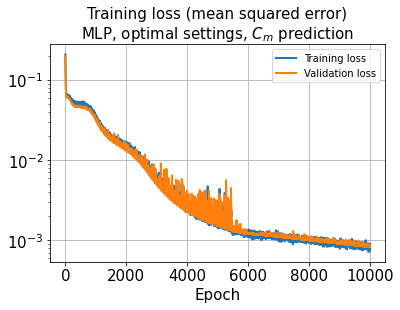

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

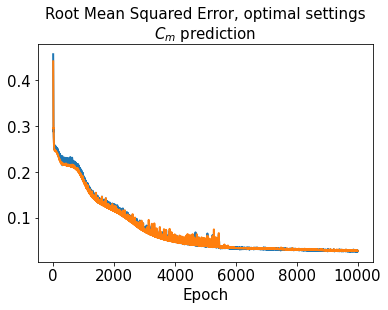

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

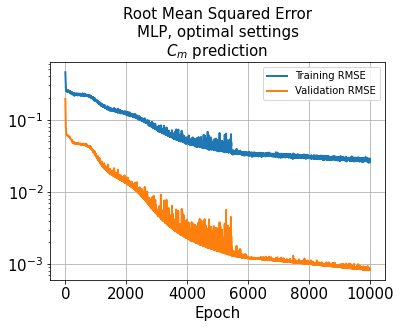

In [33]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [34]:
train_results = model.evaluate(x_train, y_train)

110/110 [==============================] - 0s 4ms/step - loss: 8.1409e-04 - rmse: 0.0273


In [35]:
val_results = model.evaluate(x_val, y_val)

32/32 [==============================] - 0s 4ms/step - loss: 8.2624e-04 - rmse: 0.0275


In [36]:
test_results = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 4ms/step - loss: 8.4283e-04 - rmse: 0.0278


In [37]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

16/16 [==============================] - 0s 2ms/step


In [38]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [39]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [40]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [41]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [42]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [43]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.058658964336118884
1.7218211761219313


In [44]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.059578526662433746
1.773678671418497


In [45]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.061474434337719784
1.841605213647909


In [46]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [47]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [48]:
model_directory = "D:\\TrainedModels\\20221229"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221229unsteadyValidation_MLP_WithoutParameters_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [49]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [50]:
os.chdir(storage_dir)

In [51]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [52]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [53]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [54]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [55]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [56]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [57]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

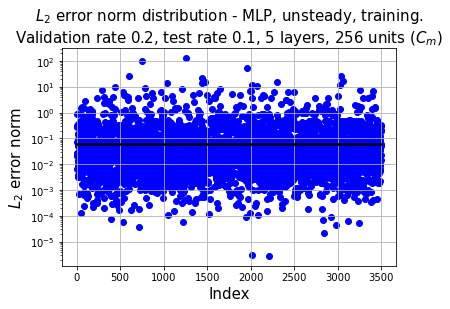

In [58]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

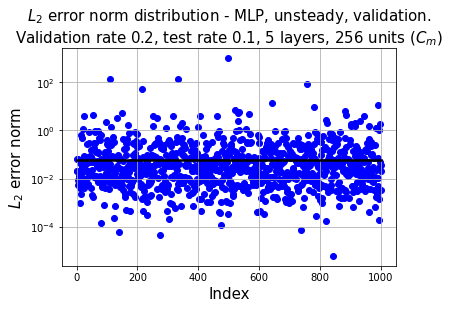

In [59]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

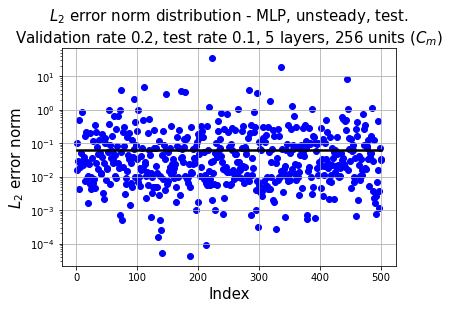

In [60]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [61]:
predicted = model.predict(x)

157/157 [==============================] - 0s 2ms/step


In [62]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [63]:
index_train.shape

(3499,)

In [64]:
max(predicted)

array([1.024845], dtype=float32)

In [65]:
l2_error(denormalize(predicted), denormalize(y))

0.0821256216068616

In [66]:
l2_error(predicted, y)

0.059116485031583066

In [67]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [68]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [69]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [70]:
x[:,0] *= 5
x[:,0] += 10

L2 error of Cm: 0.0591


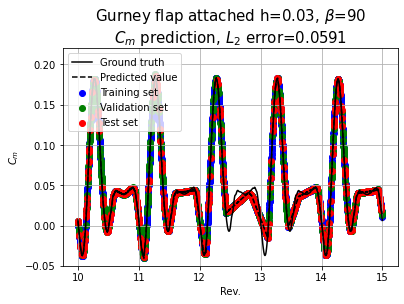

In [71]:
h = [0.03]
beta = [90]
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [72]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0591


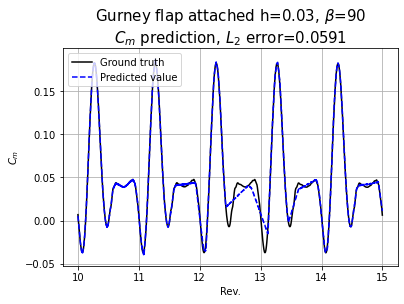

In [73]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0591


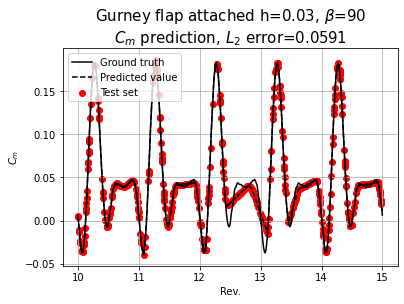

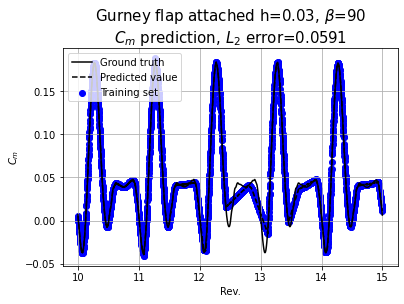

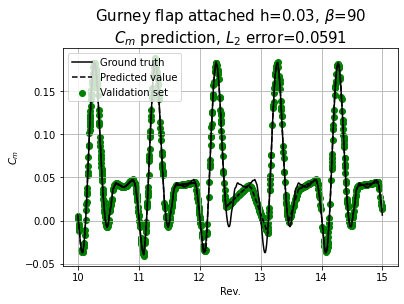

In [74]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
#     Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()